# Разработка модели машинного обучения на основе данных Интернет-магазина «В один клик»

### Загрузка данных

In [1]:
!pip install phik -q
!pip install shap -q

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import phik
import shap
import scipy.stats as st
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, confusion_matrix,
                             recall_score, precision_score, mean_absolute_error, roc_auc_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

Данные представленны в 4 файлах, прочитаем их и сохраним

In [3]:
df_mf = pd.read_csv('https://raw.githubusercontent.com/KonstantinPla/first-project/master/csv/market_file.csv', sep = ',')
df_mm = pd.read_csv('https://raw.githubusercontent.com/KonstantinPla/first-project/master/csv/market_money.csv', sep=',')
df_mt = pd.read_csv('https://raw.githubusercontent.com/KonstantinPla/first-project/master/csv/market_time.csv', sep=',')
df_m = pd.read_csv('https://raw.githubusercontent.com/KonstantinPla/first-project/master/csv/money.csv', sep=';', decimal = ',')

In [4]:
df_mf.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

Приведем названия колонок к однотипной форме записи

In [5]:
df_mf = df_mf.rename(columns={'Покупательская активность': 'покупательская_активность', 'Тип сервиса':'тип_сервиса',
                              'Разрешить сообщать':'разрешить_сообщать', 'Маркет_актив_6_мес':'маркет_актив_6_мес',
                              'Маркет_актив_тек_мес':'маркет_актив_тек_мес', 'Длительность':'длительность',
                              'Акционные_покупки':'акционные_покупки','Популярная_категория':'популярная_категория',
                              'Средний_просмотр_категорий_за_визит':'средний_просмотр_категорий_за_визит',
                              'Неоплаченные_продукты_штук_квартал':'неоплаченные_продукты_штук_квартал',
                              'Ошибка_сервиса':'ошибка_сервиса', 'Страниц_за_визит':'cтраниц_за_визит'})

In [6]:
df_mf.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  cтраниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [7]:
df_mf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

В первой таблице 4 колонки типа object: покупательская_активность, тип_сервиса, разрешить_сообщать, популярная_категория;

7 колонок типа int: id, маркет_актив_тек_мес, длительность, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, ошибка_сервиса, cтраниц_за_визит

2 колонки типа float: маркет_актив_6_мес, акционные_покупки

In [8]:
df_mm.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [9]:
df_mm = df_mm.rename(columns={'Период': 'период', 'Выручка':'выручка'})

In [10]:
df_mm.head()

id               период  выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [11]:
df_mm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Во второй таблице колонка типа object (период), колонка типа int (id) и колонка типа float (выручка)

In [12]:
df_mt.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [13]:
df_mt = df_mt.rename(columns={'Период': 'период'})

In [14]:
df_mt.head()

id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [15]:
df_mt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


В третьей таблице колонка типа object (период) и  2 колонки типа int (id, минут)

In [16]:
df_m.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

In [17]:
df_m = df_m.rename(columns={'Прибыль': 'прибыль'})

In [18]:
df_m.head()

id  прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

In [19]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


В четвертой таблице колонка типа float (прибыль) и колонка типа int (id)

### Предобработка данных

#### Пропуски и дубликаты

Проверим наличие пропусков в данных

In [20]:
df_mf.isna().mean()

id                                     0.0
покупательская_активность              0.0
тип_сервиса                            0.0
разрешить_сообщать                     0.0
маркет_актив_6_мес                     0.0
маркет_актив_тек_мес                   0.0
длительность                           0.0
акционные_покупки                      0.0
популярная_категория                   0.0
средний_просмотр_категорий_за_визит    0.0
неоплаченные_продукты_штук_квартал     0.0
ошибка_сервиса                         0.0
cтраниц_за_визит                       0.0
dtype: float64

In [21]:
df_mm.isna().mean()

id         0.0
период     0.0
выручка    0.0
dtype: float64

In [22]:
df_mt.isna().mean()

id        0.0
период    0.0
минут     0.0
dtype: float64

In [23]:
df_m.isna().mean()

id         0.0
прибыль    0.0
dtype: float64

Пропусков не обнаружено

Проверим дубликаты в данных

In [24]:
df_mf.duplicated().sum()

0

In [25]:
df_mm.duplicated().sum()

0

In [26]:
df_mt.duplicated().sum()

0

In [27]:
df_m.duplicated().sum()

0

Явных дубликатов нет

#### Неявные дубликаты

Проверим уникальные значения категориальных переменных

In [28]:
df_mf['покупательская_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [29]:
df_mf['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Наблюдаем что значения перемененной 'стандартт' и 'стандарт' означает то же самое, обработаем их

In [30]:
df_mf['тип_сервиса'] = df_mf['тип_сервиса'].apply(lambda x: 'стандарт' if x == 'стандарт' or x == 'стандартт' else 'премиум')

In [31]:
df_mf['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [32]:
df_mf['разрешить_сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [33]:
df_mf['популярная_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

Проверим не появилось ли дубликатов после обработки значений категориальных переменных 1-го фрейма

In [34]:
df_mf.duplicated().sum()

0

In [35]:
df_mm['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Значение переменной 'препредыдущий_месяц' похоже на опечатку, проверим его

In [36]:
len(df_mm['id'].unique())

1300

Соберем значения выручки у пользователей периода-'препредыдущий_месяц' и периода-'предыдущий_месяц', сравним их

In [37]:
df_previous = pd.merge(df_mm[df_mm['период'] == 'предыдущий_месяц'][['id', 'выручка']],
                        df_mm[df_mm['период'] == 'препредыдущий_месяц'][['id', 'выручка']],
                       left_on='id',right_on='id')

In [38]:
df_previous.head()

id  выручка_x  выручка_y
0  215348        0.0        0.0
1  215349     5216.0     4472.0
2  215350     5457.5     4826.0
3  215351     6158.0     4793.0
4  215352     5807.5     4594.0

Наблюдаем разные значения выручки, получается 'препредыдущий_месяц' это уникальное значение категориальной переменной

In [39]:
df_mt['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Значение 'предыдцщий_месяц' явно носит грамматическую ошибку, исправим это

In [40]:
df_mt['период'] = df_mt['период'].apply(lambda x: 'предыдущий_месяц' if x == 'предыдцщий_месяц' else 'текущий_месяц')

In [41]:
df_mt['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

#### Масштаб и типы данных

In [42]:
pd.concat([df_m['прибыль'], df_mm['выручка']], axis=1).head()

прибыль  выручка
0     0.98      0.0
1     4.16   3293.1
2     3.13      0.0
3     4.87   4472.0
4     4.21   4971.6

Из учета что выручка у нас представленна в единицах корректно представить прибыль в тех же масштабах (вряд ли разница между доходами и расходами представленна в единицах, скорее тыс.единицах)

In [43]:
df_m['прибыль'] = df_m['прибыль'].apply(lambda x: x*1000)
df_m['прибыль'].head()

0     980.0
1    4160.0
2    3130.0
3    4870.0
4    4210.0
Name: прибыль, dtype: float64

Проверим типы данных

In [44]:
df_mf.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  cтраниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [45]:
df_mf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [46]:
df_mm.head()

id               период  выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [47]:
df_mm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [48]:
df_mt.head()

id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдущий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдущий_месяц     12
4  215350     текущий_месяц     13

In [49]:
df_mt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [50]:
df_m.head()

id  прибыль
0  215348    980.0
1  215349   4160.0
2  215350   3130.0
3  215351   4870.0
4  215352   4210.0

In [51]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Типы данных в фреймах представленны корректно

### Исследовательский анализ данных

#### Рассчитанный класс покупательской активности

Создадим св.таблицу и построим круговую диаграмму для наглядности баланса классов категориального признака

In [52]:
t = df_mf.groupby('покупательская_активность')['id'].count()
t = t/len(df_mf) * 100
t

покупательская_активность
Прежний уровень    61.692308
Снизилась          38.307692
Name: id, dtype: float64

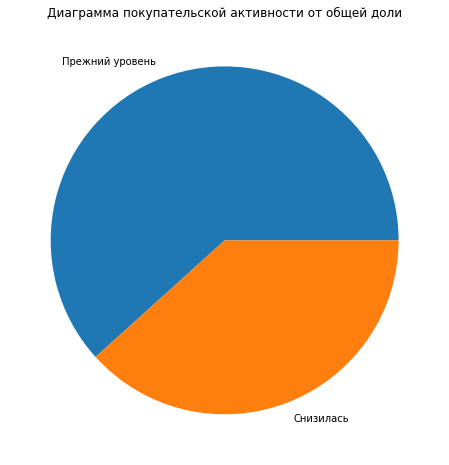

In [53]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма покупательской активности от общей доли').legend = False

Наблюдаем что большинство покупателей находятся на 'Прежнем уровне' (61.69%) у меньшего числа покупательская активность 'Снизилась' (38.3%)

#### Уровень сервиса

In [54]:
t = df_mf.groupby('тип_сервиса')['id'].count()
t = t/len(df_mf) * 100
t

тип_сервиса
премиум     28.923077
стандарт    71.076923
Name: id, dtype: float64

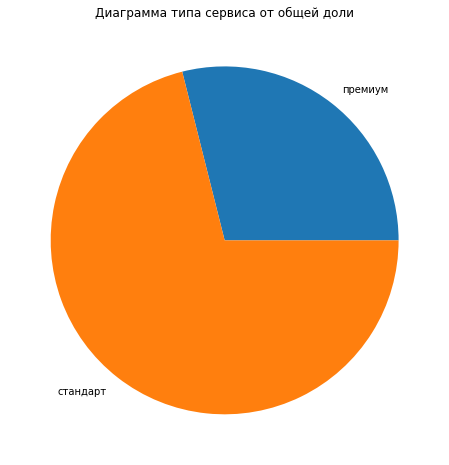

In [55]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма типа сервиса от общей доли').legend = False

У большинства покупателей сервис 'стандартного' уровня (71.07%) у меньшего числа покупателей 'премиум' (28.92%)

#### Информация о том, можно ли присылать покупателю дополнительные предложения о товаре

In [56]:
t = df_mf.groupby('разрешить_сообщать')['id'].count()
t = t/len(df_mf) * 100
t

разрешить_сообщать
да     74.0
нет    26.0
Name: id, dtype: float64

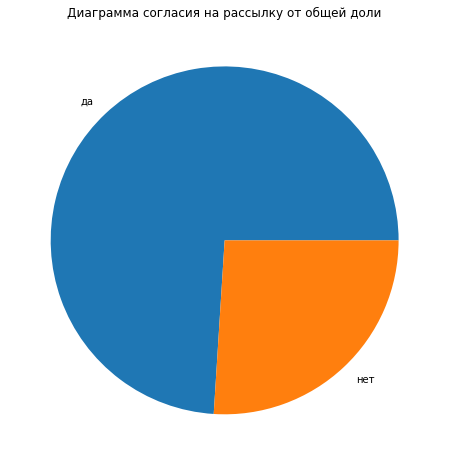

In [57]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма согласия на рассылку от общей доли').legend = False

Большинства покупателей дали согласие на рассылку (74%), меньшинство отказалось (26%)

#### Cр.месячное значение маркетинговых коммуникаций компании,  на покупателя за 6 месяцев

Для количественных признаков построим гистограмму распределения, посмотрим на основные метрики зачения и взглянем на боксплот чтобы оценить "аномальность" переменной

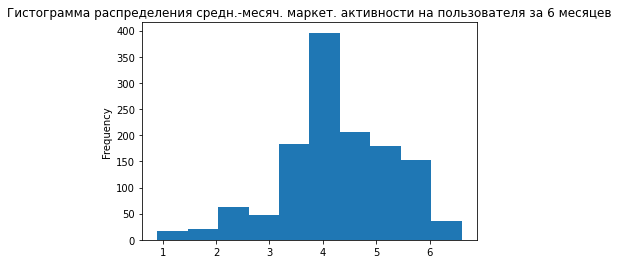

In [58]:
df_mf['маркет_актив_6_мес'].plot(kind='hist',
                                 title = 'Гистограмма распределения средн.-месяч. маркет. активности на пользователя за 6 месяцев'
                                ).legend = False

In [59]:
df_mf['маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

Гистограмма напомминает нормальное распределение чуть скошенное вправо, разброс наблюдается от 0.9 до 6.6, в среднем на покупателя 4.25 коммуникации, медианное значение слегка отличается (4.2) от среднего из-за 'скоса вправо'

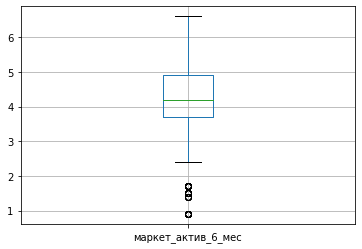

In [60]:
df_mf.boxplot(column=['маркет_актив_6_мес']).legend = False

Наблюдаем выход некоторых значений за границы межквартильного размаха, не столь экстремальные чтобы делать с ними что-то, вероятнее всего данные соответствуют реальности

#### Количество маркетинговых коммуникаций в текущем месяце

In [61]:
df_mf['маркет_актив_тек_мес'].unique()

array([5, 4, 3])

Рассматриваем как категориальный признак

In [62]:
t = df_mf.groupby('маркет_актив_тек_мес')['id'].count()
t = t/len(df_mf) * 100
t

маркет_актив_тек_мес
3    23.692308
4    51.461538
5    24.846154
Name: id, dtype: float64

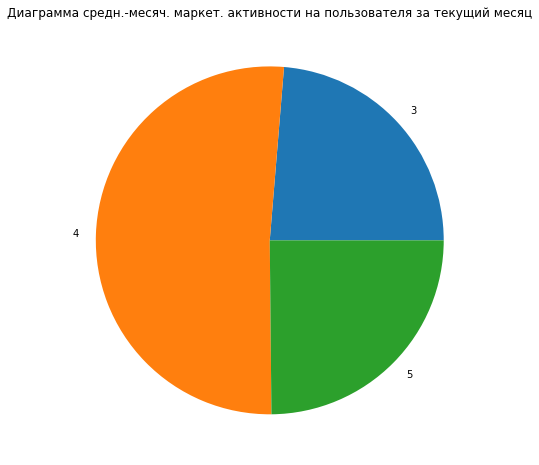

In [63]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма средн.-месяч. маркет. активности на пользователя за текущий месяц').legend = False

Большинство покупателей сталкиваются с 4-мя коммуникациями за месяц (51.46%), меньше покупателей сталкиваются с 5 коммуникациями (24.84%) и с 3 сталкиваются (23.69%) пользователей

#### Cколько дней прошло с момента регистрации

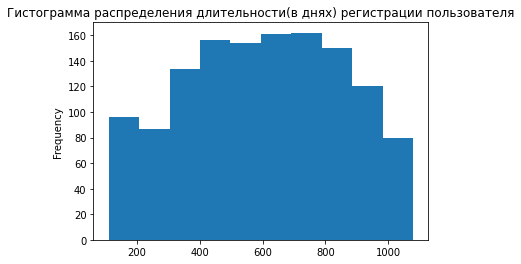

In [64]:
df_mf['длительность'].plot(kind='hist',
                                 title = 'Гистограмма распределения длительности(в днях) регистрации пользователя'
                                ).legend = False

In [65]:
df_mf['длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

Гистограмма напоминает нормальное распределение, разброс дней варьируется от 110 до 1079, в среднем 601 дней прошло с момента регистрации покупателя

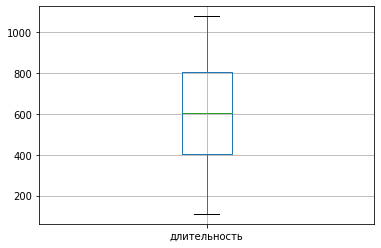

In [66]:
df_mf.boxplot(column=['длительность']).legend = False

Аномальных значений не наблюдаем

#### Ср.месячная доля покупок по акции

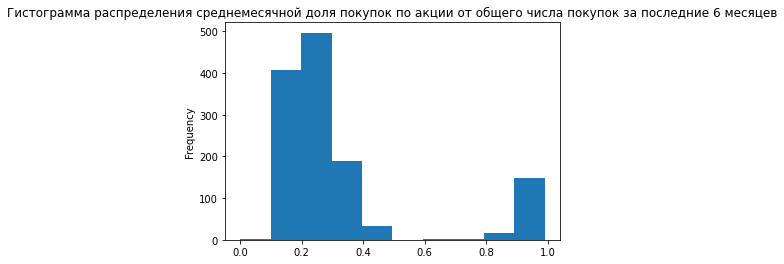

In [67]:
df_mf['акционные_покупки'].plot(kind='hist',
                                 title = 'Гистограмма распределения среднемесячной доля покупок по акции от общего числа покупок за последние 6 месяцев'
                                ).legend = False

In [68]:
df_mf['акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

Напоминает распределение Пуасона со 'скосом' к левому краю с провалом на значениях ~0.5-0.8 разброс доли покупок варьируется от 0 до 0.99, в среднем 0.31

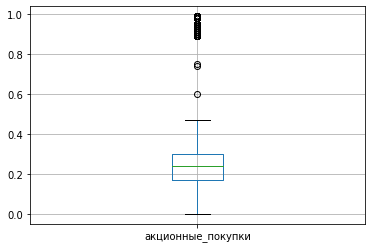

In [69]:
df_mf.boxplot(column=['акционные_покупки']).legend = False

Значения находящиеся в правой части слегка выбиваются из общей массы значений, не будем принимать эти значения аномалльными т.к. они похоже на истинные

####  Cамая популярная категория товаров

In [70]:
t = df_mf.groupby('популярная_категория')['id'].count()
t = t/len(df_mf) * 100
t

популярная_категория
Домашний текстиль                       19.307692
Косметика и аксесуары                   17.153846
Кухонная посуда                         10.615385
Мелкая бытовая техника и электроника    13.384615
Техника для красоты и здоровья          14.153846
Товары для детей                        25.384615
Name: id, dtype: float64

Построим столбчатую диаграмму, для корректного отображения значений категориальной пременной больших 4

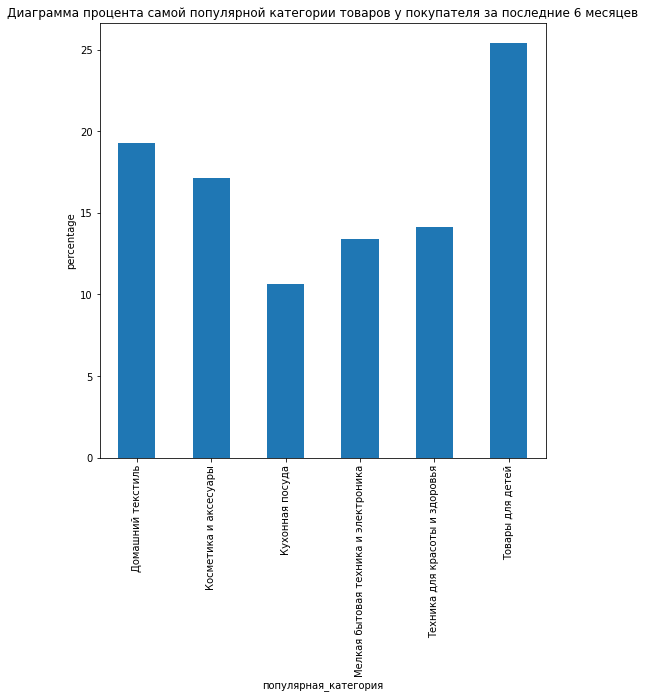

In [71]:
t.plot(kind='bar', rot=90, 
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента самой популярной категории товаров у покупателя за последние 6 месяцев'
      ).legend = False

По диаграмме видим что больше всего популярностью у покупателей пользуется Товары для детей(25.38%) по убыванию: Домашний текстиль(19.3%), Косметика и аксесуары(17.15%), Техника для красоты и здоровья(14.15%), Мелкая бытовая техника и электроника(13.38%), Кухонная посуда(10.61%)

#### Cколько в среднем категорий покупатель просмотрел за визит

In [72]:
t = df_mf.groupby('средний_просмотр_категорий_за_визит')['id'].count()
t = t/len(df_mf) * 100
t

средний_просмотр_категорий_за_визит
1     8.153846
2    24.000000
3    27.384615
4    20.230769
5    13.615385
6     6.615385
Name: id, dtype: float64

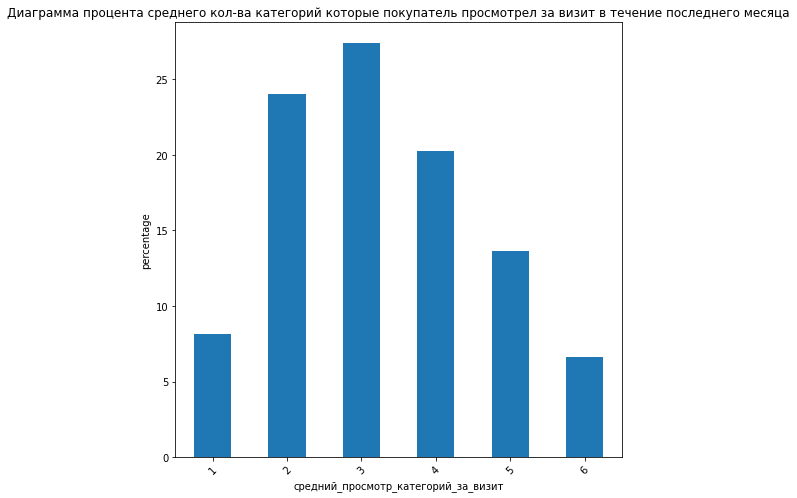

In [73]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента среднего кол-ва категорий которые покупатель просмотрел за визит в течение последнего месяца'
      ).legend = False

В среднем 3 категории просматривают (27.38%) пользователей за визит, 2 категории(24%), 4 категории(20.23%), 5 категорий(13.61%), 1 категорию(8.15%) и 6 категорий(6.61%). Напоминает нормальное распределение

#### Общее число неоплаченных товаров в корзине за 3 месяца

In [74]:
t = df_mf.groupby('неоплаченные_продукты_штук_квартал')['id'].count()
t = t/len(df_mf) * 100
t

неоплаченные_продукты_штук_квартал
0      8.923077
1     20.076923
2     20.076923
3     16.769231
4     15.153846
5     10.384615
6      3.384615
7      2.615385
8      1.538462
9      0.769231
10     0.307692
Name: id, dtype: float64

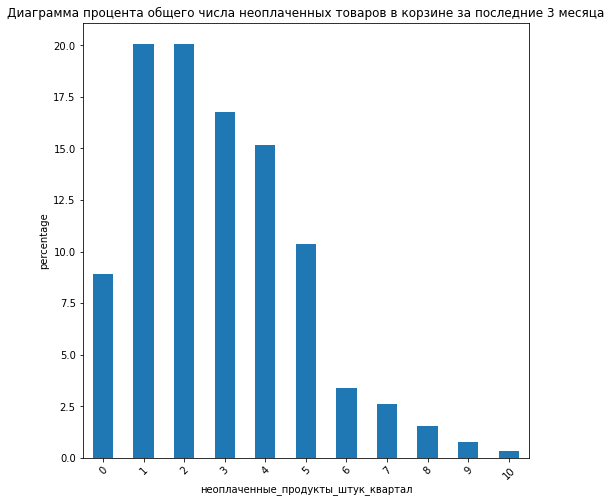

In [75]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента общего числа неоплаченных товаров в корзине за последние 3 месяца'
      ).legend = False

Большинство покупателей оставляют неоплаченными в корзине 1 (20.07%) и 2 (20.07%) товара, 3 товара (16.76%), 4 (15.15%), 5 (10.38%), 0 (8.92%), 6 (3.38%), 7 (2.61%), 8 (1.53%), 9 (0.76%) и меньше всего 10 (0.3%) товаров, напоминает распределение Пуассоа смещенное влево

#### Число сбоев

In [76]:
t = df_mf.groupby('ошибка_сервиса')['id'].count()
t = t/len(df_mf) * 100
t

ошибка_сервиса
0     1.307692
1     5.692308
2    14.538462
3    17.384615
4    19.769231
5    16.000000
6    12.000000
7     7.076923
8     5.076923
9     1.153846
Name: id, dtype: float64

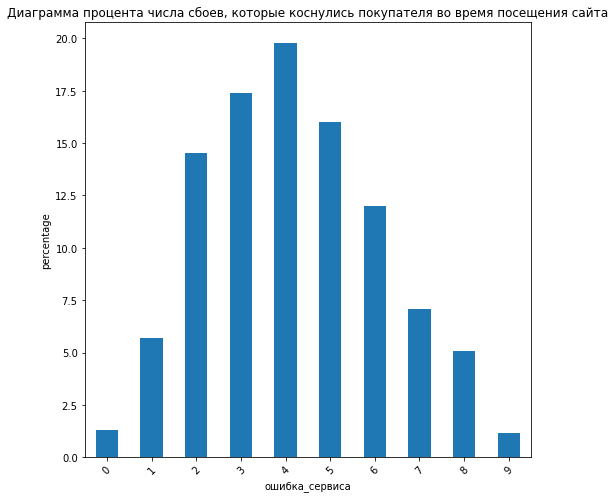

In [77]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента числа сбоев, которые коснулись покупателя во время посещения сайта'
      ).legend = False

Большинства покупателей преследует 4 (20.07%) сбоя, 3 сбоя(17.38%), 5 (16%), 2 (14.53%), 6 (12%), 7 (7.07%), 1 (5.69%), 8 (5.07%), 0 (1.3%) и 9 (1.15%) у меньше всего пользователей, напоминает нормальное распределение

#### Cреднее количество страниц за один визит на сайт

In [78]:
t = df_mf.groupby('cтраниц_за_визит')['id'].count()
t = t/len(df_mf) * 100
t

cтраниц_за_визит
1     1.538462
2     4.461538
3     5.846154
4     8.615385
5     8.846154
6     9.769231
7     7.846154
8     8.384615
9     8.307692
10    8.000000
11    7.076923
12    5.615385
13    4.692308
14    4.076923
15    2.769231
16    1.615385
17    1.461538
18    0.538462
19    0.384615
20    0.153846
Name: id, dtype: float64

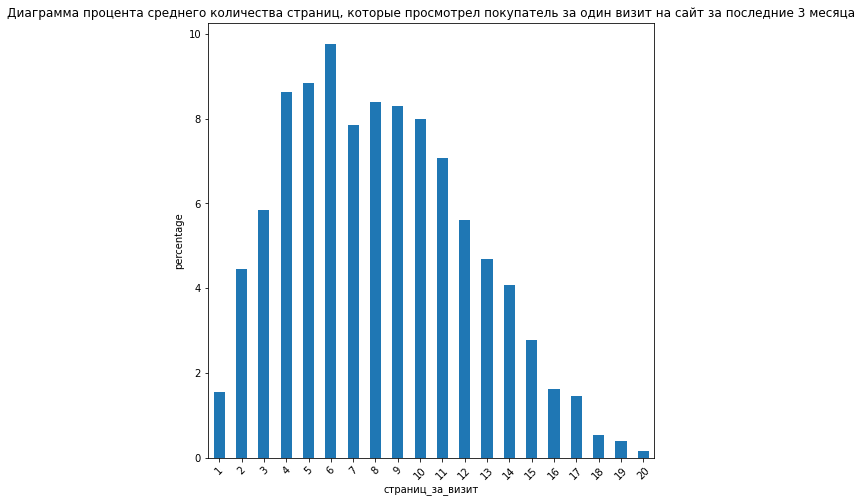

In [79]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца'
      ).legend = False

In [80]:
t.sort_values(ascending=False)

cтраниц_за_визит
6     9.769231
5     8.846154
4     8.615385
8     8.384615
9     8.307692
10    8.000000
7     7.846154
11    7.076923
3     5.846154
12    5.615385
13    4.692308
2     4.461538
14    4.076923
15    2.769231
16    1.615385
1     1.538462
17    1.461538
18    0.538462
19    0.384615
20    0.153846
Name: id, dtype: float64

Чаще всего покупатели посещают 6(9.76%) страниц за визит на сайт, (8.8-7%) пользователей посещают: 5, 4, 8, 9, 10, 7, 11 страниц соответственно; (5.8-4%) посещают: 3, 12, 13, 2, 14 страниц; меньше всего (2.7-0%) пользователей посещают: 15, 16, 1, 17, 18, 19, 20 страниц. Напоминает нормальное распределение со слегка выбивающиемся значениями 4, 5, 6 страниц за визит

#### Периода во время которого зафиксирована выручка

In [81]:
t = df_mm.groupby('период')['id'].count()
t = t/len(df_mm) * 100
t

период
предыдущий_месяц       33.333333
препредыдущий_месяц    33.333333
текущий_месяц          33.333333
Name: id, dtype: float64

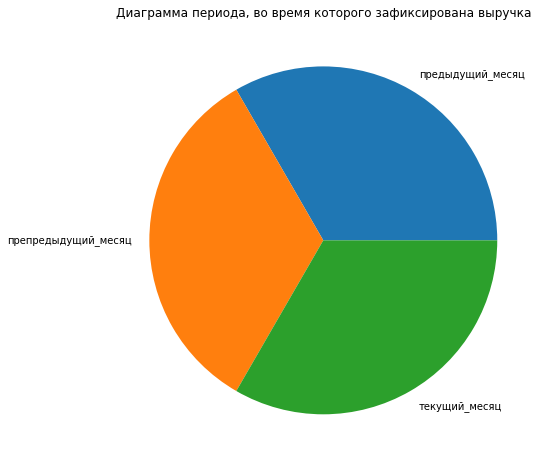

In [82]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма периода, во время которого зафиксирована выручка').legend = False

In [83]:
df_mm[(df_mm['id'] == 215348) | (df_mm['id'] == 215349) | (df_mm['id'] == 215350) | (df_mm['id'] == 215351)]

id               период  выручка
0   215348  препредыдущий_месяц      0.0
1   215348        текущий_месяц   3293.1
2   215348     предыдущий_месяц      0.0
3   215349  препредыдущий_месяц   4472.0
4   215349        текущий_месяц   4971.6
5   215349     предыдущий_месяц   5216.0
6   215350  препредыдущий_месяц   4826.0
7   215350        текущий_месяц   5058.4
8   215350     предыдущий_месяц   5457.5
9   215351        текущий_месяц   6610.4
10  215351     предыдущий_месяц   6158.0
11  215351  препредыдущий_месяц   4793.0

На диаграмме наблюдаем что значения периода делятся на 3 равные части, что правильно т.к. у нас для каждого id 3 значения периода и эти значения делят выборку на 3 равных части

#### Cумма выручки за период

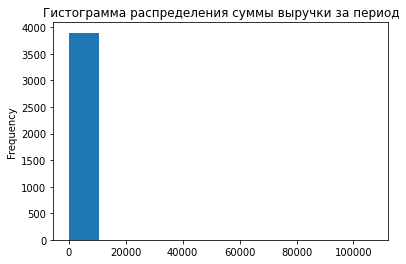

In [84]:
df_mm['выручка'].plot(kind='hist',
                                 title = 'Гистограмма распределения суммы выручки за период'
                                ).legend = False

In [85]:
df_mm['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

На гистограмме распределения наблюдаем 'тяжелый хвост', что нам говорит о наличии аномалий в данных и что искажает визуализацию

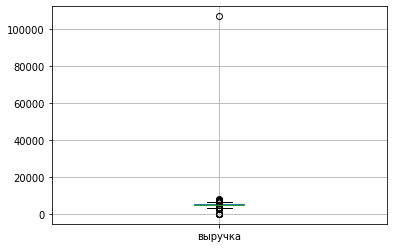

In [86]:
df_mm.boxplot(column=['выручка']).legend = False

На боксплоте наблюдаем аномальное значение в верхней части, поправим его

In [87]:
df_mm['выручка'].quantile(0.995)

7160.4545

По значению 0.995 квантиля отфильтруем и посмотрим на это выбивающиеся значение

In [88]:
df_mm[df_mm['выручка'] > 7160]

id         период   выручка
98    215380  текущий_месяц  106862.2
262   215435  текущий_месяц    7605.3
435   215493  текущий_месяц    7799.4
566   215536  текущий_месяц    7467.9
631   215558  текущий_месяц    7212.3
843   215629  текущий_месяц    7160.9
1003  215682  текущий_месяц    7401.6
1247  215763  текущий_месяц    7208.8
1250  215764  текущий_месяц    7325.4
1392  215812  текущий_месяц    7167.4
1481  215841  текущий_месяц    7557.0
1573  215872  текущий_месяц    7374.0
1632  215892  текущий_месяц    7401.6
1770  215938  текущий_месяц    7338.2
1925  215989  текущий_месяц    7310.0
2205  216083  текущий_месяц    7182.2
2266  216103  текущий_месяц    7410.0
2388  216144  текущий_месяц    7547.8
2621  216221  текущий_месяц    7314.0
2922  216322  текущий_месяц    7370.6

Наблюдаем значение которое значительно выбивается от остальных (106862), приведем это значения к 'усам' боксплота

In [89]:
Q1 = df_mm['выручка'].quantile(0.25)
Q3 = df_mm['выручка'].quantile(0.75)
IQR = Q3 - Q1
max_q = Q3+1.5*IQR
df_mm['выручка'] = df_mm['выручка'].apply(lambda x: max_q if x>8000 else x)

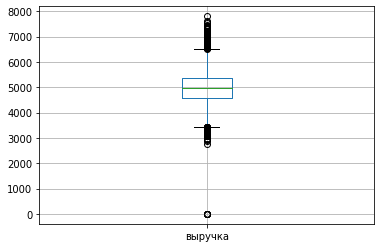

In [90]:
df_mm.boxplot(column=['выручка']).legend = False

Наблюдаем улучшение визуальной составляющей графика после обработки аномального значения, слегка выбивающиеся значения по обе стороны графика, есть нулевые значения

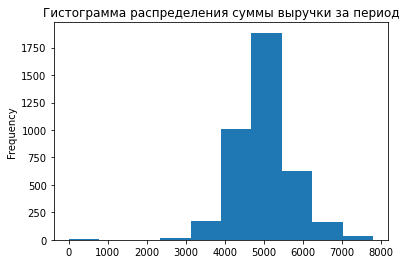

In [91]:
df_mm['выручка'].plot(kind='hist',
                                 title = 'Гистограмма распределения суммы выручки за период'
                                ).legend = False

In [92]:
df_mm['выручка'].describe()

count    3900.000000
mean     4999.967865
std       707.329588
min         0.000000
25%      4590.150000
50%      4957.500000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64

Напоминает нормальное распределение с 'хвостом' по левому краю, разброс выручки варьируется от 0 до 7799.4, в среднем выручка на покупателя 4999.96

#### Период, во время которого зафиксировано общее время

In [93]:
t = df_mt.groupby('период')['id'].count()
t = t/len(df_mt) * 100
t

период
предыдущий_месяц    50.0
текущий_месяц       50.0
Name: id, dtype: float64

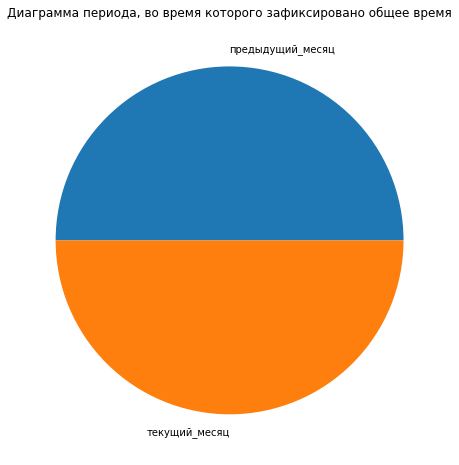

In [94]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма периода, во время которого зафиксировано общее время').legend = False

Значения периода делятся на 2 равные части,на каждый id 2 значения периода и эти значения делят выборку на 2 равных части

#### Значение времени, проведённого на сайте, в минутах

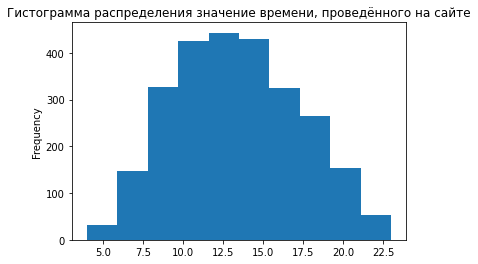

In [95]:
df_mt['минут'].plot(kind='hist',
                                 title = 'Гистограмма распределения значение времени, проведённого на сайте'
                                ).legend = False

In [96]:
df_mt['минут'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

Напоминает нормальное распределение, разброс времени варьируется от 4 до 23 минут, в среднем покупатели проводят на сайте 13.33 минут

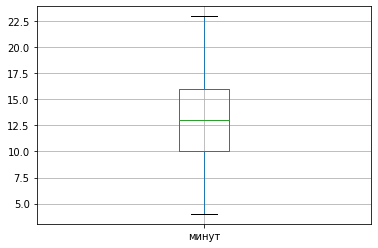

In [97]:
df_mt.boxplot(column=['минут']).legend = False

Аномалий не наблюдается

#### Значение прибыли

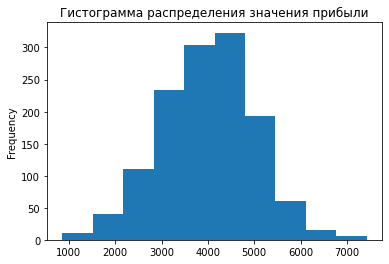

In [98]:
df_m['прибыль'].plot(kind='hist',
                                 title = 'Гистограмма распределения значения прибыли'
                                ).legend = False

In [99]:
df_m['прибыль'].describe()

count    1300.000000
mean     3996.630769
std      1013.722112
min       860.000000
25%      3300.000000
50%      4045.000000
75%      4670.000000
max      7430.000000
Name: прибыль, dtype: float64

Напоминает нормальное распределение, разброс прибыли варьируется от 860 до 7430, в среднем прибыль на покупателя составляет 3996.63

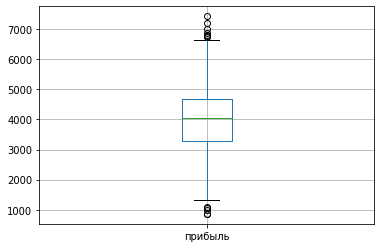

In [100]:
df_m.boxplot(column=['прибыль']).legend = False

Наблюдаем слегка выбивающиеся значения

### Объединение таблиц

Выведем информацию о таблицах перед объединением

In [101]:
df_mf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [102]:
df_mm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [103]:
df_mt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Выделим отдельные таблицы с 'выручкой' и 'минутами' за каждый период который есть в исходных таблицах, объединять будем по 'id'

In [104]:
df_mm_current = df_mm[df_mm['период'] == 'текущий_месяц'][['id', 'выручка']]
df_mm_current = df_mm_current.rename(columns={'выручка': 'выручка_текущий_месяц'})
df_mm_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 1 to 3899
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1300 non-null   int64  
 1   выручка_текущий_месяц  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 30.5 KB


In [105]:
df_mm_previous = df_mm[df_mm['период'] == 'предыдущий_месяц'][['id', 'выручка']]
df_mm_previous = df_mm_previous.rename(columns={'выручка': 'выручка_предыдущий_месяц'})
df_mm_previous.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 2 to 3897
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1300 non-null   int64  
 1   выручка_предыдущий_месяц  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 30.5 KB


In [106]:
df_mm_preprevious = df_mm[df_mm['период'] == 'препредыдущий_месяц'][['id', 'выручка']]
df_mm_preprevious = df_mm_preprevious.rename(columns={'выручка': 'выручка_препредыдущий_месяц'})
df_mm_preprevious.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 3898
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1300 non-null   int64  
 1   выручка_препредыдущий_месяц  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 30.5 KB


In [107]:
df_mt_current = df_mt[df_mt['период'] == 'текущий_месяц'][['id', 'минут']]
df_mt_current = df_mt_current.rename(columns={'минут': 'минут_текущий_месяц'})
df_mt_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 2598
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   id                   1300 non-null   int64
 1   минут_текущий_месяц  1300 non-null   int64
dtypes: int64(2)
memory usage: 30.5 KB


In [108]:
df_mt_previous = df_mt[df_mt['период'] == 'предыдущий_месяц'][['id', 'минут']]
df_mt_previous = df_mt_previous.rename(columns={'минут': 'минут_предыдущий_месяц'})
df_mt_previous.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 1 to 2599
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   id                      1300 non-null   int64
 1   минут_предыдущий_месяц  1300 non-null   int64
dtypes: int64(2)
memory usage: 30.5 KB


Собираем все в единую таблицу поочередно соединяя все таблицы методом 'merge'

In [109]:
df = df_mf.merge(df_mm_current,on='id', how='outer'
                ).merge(df_mm_previous,on='id', how='outer'
                       ).merge(df_mm_preprevious,on='id', how='outer'
                              ).merge(df_mt_current,on='id', how='outer'
                                     ).merge(df_mt_previous,on='id', how='outer')

Проверяем значения получившееся таблицы

In [110]:
df.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  cтраниц_за_визит  \
0                                   2               1                 5   
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   

   выручка_текущий_месяц  выручка_предыдущий_месяц  \
0                 3293.1                       0.0   
1                 4971.6                    5216.0   
2                 5058.4                    5457.5   
3                 6610.4                    6158.0   
4                 5872.5                    5807.5   

   выручка_препредыдущий_месяц  минут_текущий_месяц  минут_предыдущий_месяц  
0                          0.0                   14                      13  
1                       4472.0                   10                      12  
2                       4826.0                   13                       8  
3                       4793.0                   13                      11  
4                       4594.0                   11                       8

In [111]:
df.isna().mean()

id                                     0.0
покупательская_активность              0.0
тип_сервиса                            0.0
разрешить_сообщать                     0.0
маркет_актив_6_мес                     0.0
маркет_актив_тек_мес                   0.0
длительность                           0.0
акционные_покупки                      0.0
популярная_категория                   0.0
средний_просмотр_категорий_за_визит    0.0
неоплаченные_продукты_штук_квартал     0.0
ошибка_сервиса                         0.0
cтраниц_за_визит                       0.0
выручка_текущий_месяц                  0.0
выручка_предыдущий_месяц               0.0
выручка_препредыдущий_месяц            0.0
минут_текущий_месяц                    0.0
минут_предыдущий_месяц                 0.0
dtype: float64

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

### Анализ клиентов с покупательской способностью не менее трёх месяцев

In [113]:
len(df_m[df_m['прибыль'] == 0])

0

In [114]:
len(df[(df['выручка_текущий_месяц'] == 0) | (df['выручка_предыдущий_месяц'] == 0) | (df['выручка_препредыдущий_месяц'] == 0)])

3

In [115]:
df = df[(df['выручка_текущий_месяц'] != 0) & (df['выручка_предыдущий_месяц'] != 0
                                             ) & (df['выручка_препредыдущий_месяц'] != 0)]
len(df)

1297

"Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период" - размашляя от обратного и убедившись что отбор клиентов которые в значении 'выручки' имели бы 0 в один из 3 месяцев не выделил отдельного кластера, как и фильтрация по 0-му значению прибыли. Прихожу к выводу что имеет смысл выделить клиентов по значению 'Прежний уровень' целевой переменной 'покупательская_активность' и проанализировать их

In [116]:
df_pre_level = df[df['покупательская_активность'] == 'Прежний уровень']
df_pre_level

id покупательская_активность тип_сервиса разрешить_сообщать  \
400   215748           Прежний уровень    стандарт                нет   
401   215749           Прежний уровень     премиум                 да   
402   215750           Прежний уровень    стандарт                 да   
403   215751           Прежний уровень    стандарт                 да   
404   215752           Прежний уровень    стандарт                нет   
...      ...                       ...         ...                ...   
1295  216643           Прежний уровень    стандарт                 да   
1296  216644           Прежний уровень    стандарт                нет   
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
400                  4.3                     4           534   
401                  5.8                     5           624   
402                  4.8                     5           634   
403                  4.1                     4           957   
404                  4.0                     4           475   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      акционные_покупки                  популярная_категория  \
400                0.18                       Кухонная посуда   
401                0.30        Техника для красоты и здоровья   
402                0.21                      Товары для детей   
403                0.17        Техника для красоты и здоровья   
404                0.30  Мелкая бытовая техника и электроника   
...                 ...                                   ...   
1295               0.24        Техника для красоты и здоровья   
1296               0.21                     Домашний текстиль   
1297               0.20                     Домашний текстиль   
1298               0.12        Техника для красоты и здоровья   
1299               0.94        Техника для красоты и здоровья   

      средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
400                                     3                                   1   
401                                     4                                   3   
402                                     4                                   5   
403                                     5                                   2   
404                                     3                                   3   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      ошибка_сервиса  cтраниц_за_визит  выручка_текущий_месяц  \
400                4                10                 5673.2   
401                6                14                 5092.5   
402                3                10                 4672.3   
403                6                 9                 5021.5   
404                7                 7                 5798.2   
...              ...               ...                    ...   
1295               3                11                 4741.7   
1296               3                 9                 5353.0   
1297               5     

#### Уровень сервиса

In [117]:
t = df_pre_level.groupby('тип_сервиса')['id'].count()
t = t/len(df_pre_level) * 100
t

тип_сервиса
премиум     25.685786
стандарт    74.314214
Name: id, dtype: float64

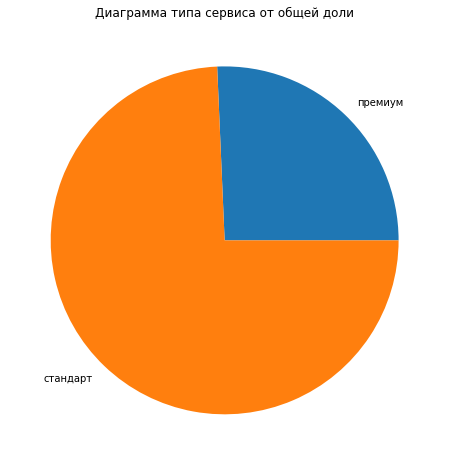

In [118]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма типа сервиса от общей доли').legend = False

Общее: У большинства покупателей сервис 'стандартного' уровня (71.07%) у меньшего числа покупателей 'премиум' (28.92%)

Различие: Чуть больше покупателей сервиса 'стандартного' уровня (74.31%) и меньше покупателей 'премиум'(25.68%)

#### Информация о том, можно ли присылать покупателю дополнительные предложения о товаре

In [119]:
t = df_pre_level.groupby('разрешить_сообщать')['id'].count()
t = t/len(df_pre_level) * 100
t

разрешить_сообщать
да     73.690773
нет    26.309227
Name: id, dtype: float64

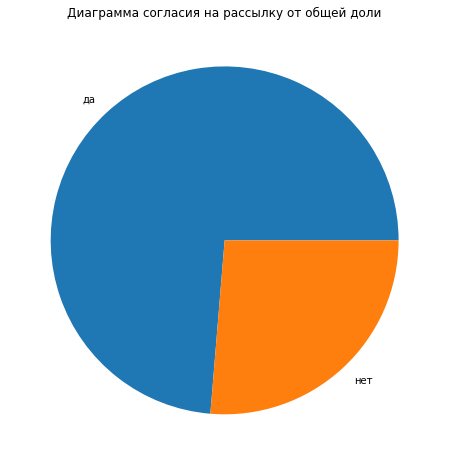

In [120]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма согласия на рассылку от общей доли').legend = False

Общее: Большинства покупателей дали согласие на рассылку (74%), меньшинство отказалось (26%)

Различие: Соотношение незначительно поменялось покупателей дали согласие на рассылку (73.69%), отказалось (26.3%)

#### Cр.месячное значение маркетинговых коммуникаций компании,  на покупателя за 6 месяцев

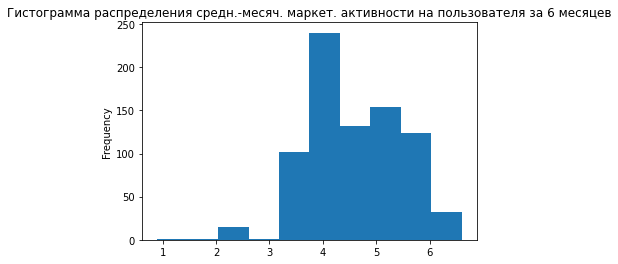

In [121]:
df_pre_level['маркет_актив_6_мес'].plot(kind='hist',
                                 title = 'Гистограмма распределения средн.-месяч. маркет. активности на пользователя за 6 месяцев'
                                ).legend = False

In [122]:
df_pre_level['маркет_актив_6_мес'].describe()

count    802.000000
mean       4.570075
std        0.848618
min        0.900000
25%        4.000000
50%        4.400000
75%        5.275000
max        6.600000
Name: маркет_актив_6_мес, dtype: float64

Общее: Гистограмма напомминает нормальное распределение чуть скошенное вправо, разброс наблюдается от 0.9 до 6.6, в среднем на покупателя 4.25 коммуникации, медианное значение слегка отличается (4.2) от среднего из-за 'скоса вправо'

Различие: Среднее значение слегка смещено в большую сторону (4.57) как и медиана (4.4)

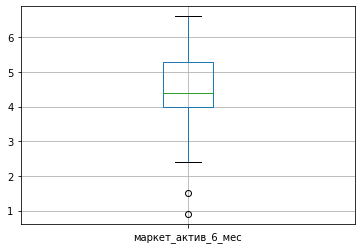

In [123]:
df_pre_level.boxplot(column=['маркет_актив_6_мес']).legend = False

Общее: Наблюдаем выход некоторых значений за границы межквартильного размаха, не столь экстремальные чтобы делать с ними что-то, вероятнее всего данные соответствуют реальности

Различие: аналогично

#### Количество маркетинговых коммуникаций в текущем месяце

In [124]:
t = df_pre_level.groupby('маркет_актив_тек_мес')['id'].count()
t = t/len(df_pre_level) * 100
t

маркет_актив_тек_мес
3    23.192020
4    52.493766
5    24.314214
Name: id, dtype: float64

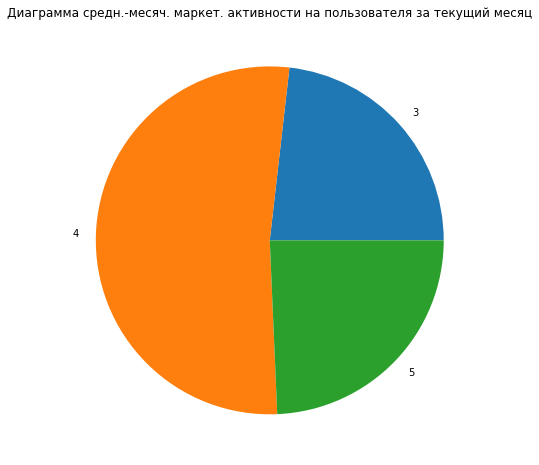

In [125]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма средн.-месяч. маркет. активности на пользователя за текущий месяц').legend = False

Общее: Большинство покупателей сталкиваются с 4-мя коммуникациями за месяц (51.46%), меньше покупателей сталкиваются с 5 коммуникациями (24.84%) и с 3 сталкиваются (23.69%) пользователей

Различие: Соотношение слегка отличается 4-мя(52.49%), 5(24.31%) и 3-мя(23.19%)

#### Cколько дней прошло с момента регистрации

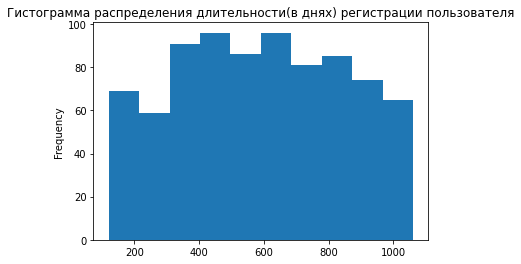

In [126]:
df_pre_level['длительность'].plot(kind='hist',
                                 title = 'Гистограмма распределения длительности(в днях) регистрации пользователя'
                                ).legend = False

In [127]:
df_pre_level['длительность'].describe()

count     802.000000
mean      590.730673
std       255.330179
min       121.000000
25%       382.500000
50%       590.000000
75%       798.750000
max      1061.000000
Name: длительность, dtype: float64

Общее: Гистограмма напоминает нормальное распределение, разброс дней варьируется от 110 до 1079, в среднем 601 дней прошло с момента регистрации покупателя

Различие: Незначительно поменялся разброс от 121 до 1061 и ср.значение 590.73

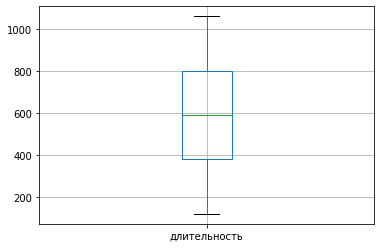

In [128]:
df_pre_level.boxplot(column=['длительность']).legend = False

Общее: Аномальных значений не наблюдаем

Различие: аналогично

#### Ср.месячная доля покупок по акции

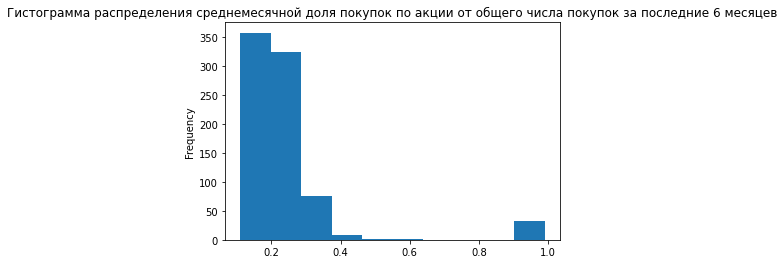

In [129]:
df_pre_level['акционные_покупки'].plot(kind='hist',
                                 title = 'Гистограмма распределения среднемесячной доля покупок по акции от общего числа покупок за последние 6 месяцев'
                                ).legend = False

In [130]:
df_pre_level['акционные_покупки'].describe()

count    802.000000
mean       0.238367
std        0.160599
min        0.110000
25%        0.150000
50%        0.210000
75%        0.260000
max        0.990000
Name: акционные_покупки, dtype: float64

Общее: Напоминает распределение Пуасона со 'скосом' к левому краю с провалом на значениях ~0.5-0.8 разброс доли покупок варьируется от 0 до 0.99, в среднем 0.31

Различие: Изменение провала на значениях ~0.5-0.9, среднее значение значимо сместилось (0.23) 

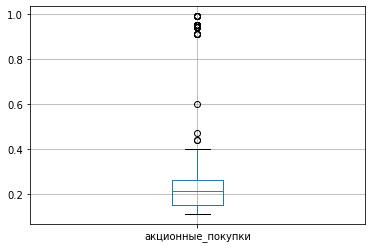

In [131]:
df_pre_level.boxplot(column=['акционные_покупки']).legend = False

Общее: Значения находящиеся в правой части слегка выбиваются из общей массы значений, не будем принимать эти значения аномалльными т.к. они похоже на истинные

Различие: аналогично

####  Cамая популярная категория товаров

In [132]:
t = df_pre_level.groupby('популярная_категория')['id'].count()
t = t/len(df_pre_level) * 100
t

популярная_категория
Домашний текстиль                       18.578554
Косметика и аксесуары                   14.713217
Кухонная посуда                          8.977556
Мелкая бытовая техника и электроника    18.329177
Техника для красоты и здоровья          16.458853
Товары для детей                        22.942643
Name: id, dtype: float64

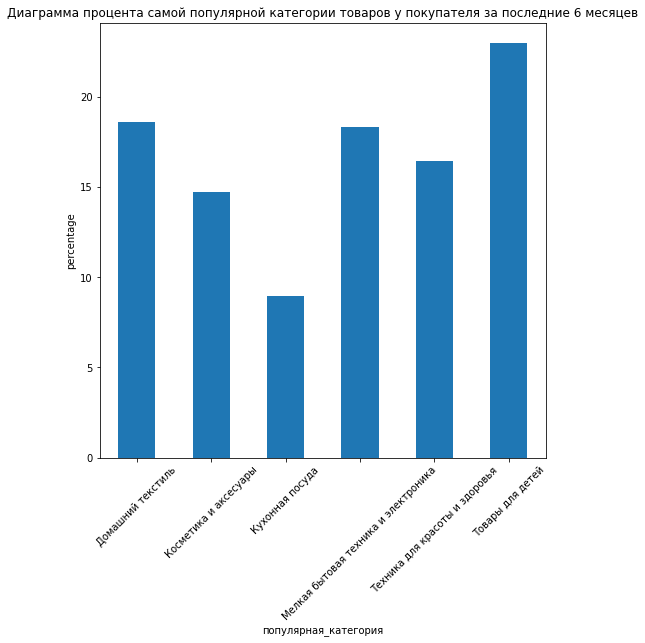

In [133]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента самой популярной категории товаров у покупателя за последние 6 месяцев'
      ).legend = False

Общее: По диаграмме видим что больше всего популярностью у покупателей пользуется Товары для детей(25.38%) по убыванию: Домашний текстиль(19.3%), Косметика и аксесуары(17.15%), Техника для красоты и здоровья(14.15%), Мелкая бытовая техника и электроника(13.38%), Кухонная посуда(10.61%)

Различие: Наблюдаем изменение в соотношении популярных категорий товаров. Товары для детей(22.94%) по убыванию: Домашний текстиль(18.57%), Мелкая бытовая техника и электроника(18.32%), Техника для красоты и здоровья(16.45%), Косметика и аксесуары(14.71%), Кухонная посуда(8.97%)

#### Cколько в среднем категорий покупатель просмотрел за визит

In [134]:
t = df_pre_level.groupby('средний_просмотр_категорий_за_визит')['id'].count()
t = t/len(df_pre_level) * 100
t

средний_просмотр_категорий_за_визит
1     2.743142
2    16.957606
3    27.680798
4    24.937656
5    18.952618
6     8.728180
Name: id, dtype: float64

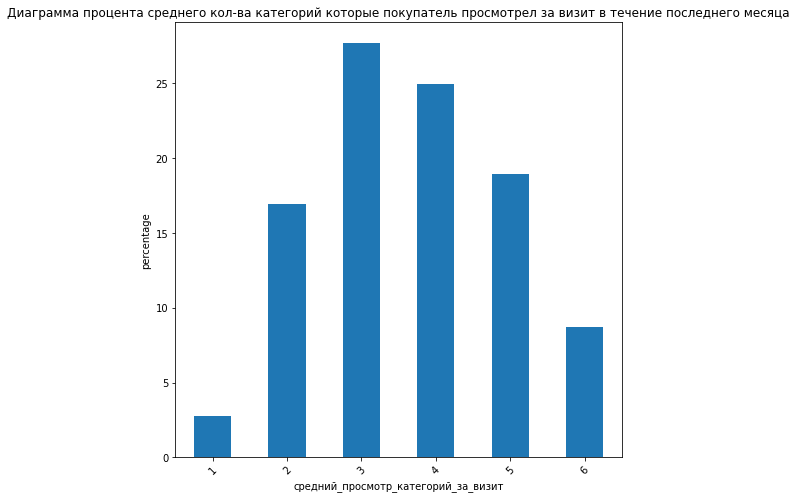

In [135]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента среднего кол-ва категорий которые покупатель просмотрел за визит в течение последнего месяца'
      ).legend = False

Общее: В среднем 3 категории просматривают (27.38%) пользователей за визит, 2 категории(24%), 4 категории(20.23%), 5 категорий(13.61%), 1 категорию(8.15%) и 6 категорий(6.61%). Напоминает нормальное распределение

Различие: Изменение в соотношении кол-ва категорий которые просматривает покупатель за визит. 3 категории просматривают (27.68%) пользователей за визит, 2 категории(16.95%), 4 категории(24.93%), 5 категорий(18.95%), 1 категорию(2.74%) и 6 категорий(8.72%)

#### Общее число неоплаченных товаров в корзине за 3 месяца

In [136]:
t = df_pre_level.groupby('неоплаченные_продукты_штук_квартал')['id'].count()
t = t/len(df_pre_level) * 100
t

неоплаченные_продукты_штук_квартал
0    10.847880
1    24.937656
2    22.194514
3    18.079800
4    15.211970
5     7.980050
6     0.374065
7     0.249377
8     0.124688
Name: id, dtype: float64

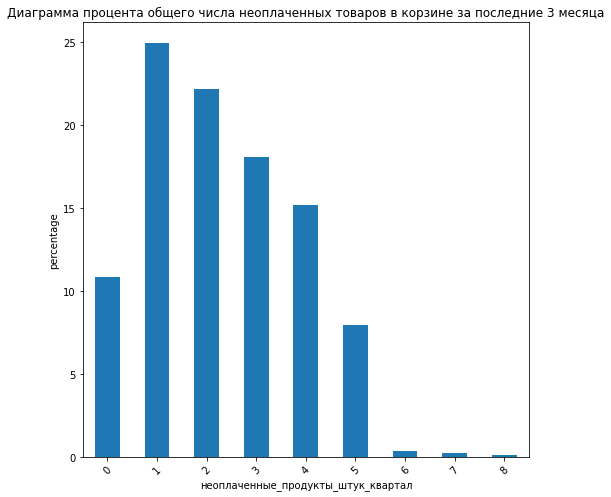

In [137]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента общего числа неоплаченных товаров в корзине за последние 3 месяца'
      ).legend = False

Общее: Большинство покупателей оставляют неоплаченными в корзине 1 (20.07%) и 2 (20.07%) товара, 3 товара (16.76%), 4 (15.15%), 5 (10.38%), 0 (8.92%), 6 (3.38%), 7 (2.61%), 8 (1.53%), 9 (0.76%) и меньше всего 10 (0.3%) товаров, напоминает распределение Пуассоа смещенное влево

Различие: Изменение в соотношении числа неоплаченных товаров в корзине. 1 (24.93%) и 2 (22.19%) товара, 3 товара (18.07%), 4 (15.21%), 5 (7.98%), 0 (10.84%), 6 (0.37%), 7 (0.24%) и меньше всего 8 (0.12%) товаров

#### Число сбоев

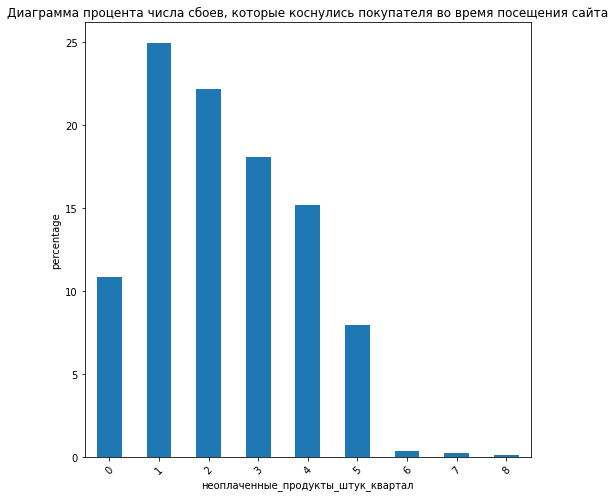

In [138]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента числа сбоев, которые коснулись покупателя во время посещения сайта'
      ).legend = False

In [139]:
t = df_pre_level.groupby('ошибка_сервиса')['id'].count()
t = t/len(df_pre_level) * 100
t

ошибка_сервиса
0     2.119701
1     5.236908
2    11.596010
3    14.962594
4    20.324190
5    17.830424
6    14.089776
7     6.982544
8     5.361596
9     1.496259
Name: id, dtype: float64

Общее: Большинства покупателей преследует 4 (20.07%) сбоя, 3 сбоя(17.38%), 5 (16%), 2 (14.53%), 6 (12%), 7 (7.07%), 1 (5.69%), 8 (5.07%), 0 (1.3%) и 9 (1.15%) у меньше всего пользователей, напоминает нормальное распределение

Различие: Небольшие изменения в соотношении числа сбоев, которые коснулись покупателя во время посещения сайта. 4 (20.32%) сбоя, 3 сбоя(14.96%), 5 (17.83%), 2 (11.59%), 6 (14.08%), 7 (6.98%), 1 (5.23%), 8 (5.36%), 0 (2.11%) и 9 (1.49%) у меньше всего пользователей

#### Cреднее количество страниц за один визит на сайт

In [140]:
t = df_pre_level.groupby('cтраниц_за_визит')['id'].count()
t = t/len(df_pre_level) * 100
t

cтраниц_за_визит
3      0.997506
4      4.114713
5      4.364090
6      8.229426
7      8.104738
8     12.219451
9     11.596010
10    11.221945
11     9.476309
12     7.855362
13     6.608479
14     5.985037
15     3.865337
16     2.119701
17     1.620948
18     0.748130
19     0.623441
20     0.249377
Name: id, dtype: float64

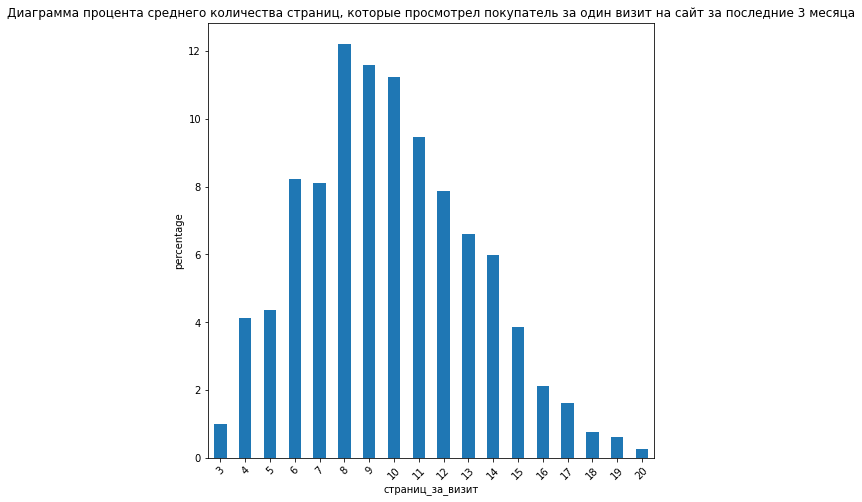

In [141]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца'
      ).legend = False

In [142]:
t.sort_values(ascending=False)

cтраниц_за_визит
8     12.219451
9     11.596010
10    11.221945
11     9.476309
6      8.229426
7      8.104738
12     7.855362
13     6.608479
14     5.985037
5      4.364090
4      4.114713
15     3.865337
16     2.119701
17     1.620948
3      0.997506
18     0.748130
19     0.623441
20     0.249377
Name: id, dtype: float64

Общее: Чаще всего покупатели посещают 6(9.76%) страниц за визит на сайт, (8.8-7%) пользователей посещают: 5, 4, 8, 9, 10, 7, 11 страниц соответственно; (5.8-4%) посещают: 3, 12, 13, 2, 14 страниц; меньше всего (2.7-0%) пользователей посещают: 15, 16, 1, 17, 18, 19, 20 страниц. Напоминает нормальное распределение со слегка выбивающиемся значениями 4, 5, 6 страниц за визит

Различие: Изменение в кол-ве посещенных страниц за один визит на сайт. Чаще всего покупатели посещают 8, 9, 10(12.21-11.22%) страниц за визит на сайт, (9.47-7.85%) пользователей посещают: 11, 6, 7, 12 страниц соответственно; (6.6-3.8%) посещают: 13, 14, 5, 4, 15 страниц; меньше всего (2.11-0%) пользователей посещают: 16, 17, 3, 18, 19, 20 страниц. Слегка выбивается значение 8 страниц за визит из общего нормального распределения

#### Cумма выручки за текущий месяц

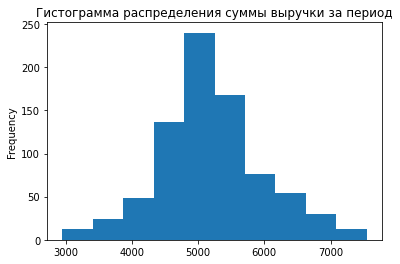

In [143]:
df_pre_level['выручка_текущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения суммы выручки за период'
                                ).legend = False

In [144]:
df_pre_level['выручка_текущий_месяц'].describe()

count     802.000000
mean     5197.704115
std       792.685086
min      2952.200000
25%      4726.475000
50%      5122.550000
75%      5612.800000
max      7547.800000
Name: выручка_текущий_месяц, dtype: float64

Гистограмма напомминает нормальное распределение, разброс выручки наблюдается от 2952 до 7547, в среднем выручка на пользователя с покупательской способностью за текущий месяц составляет 5197.7

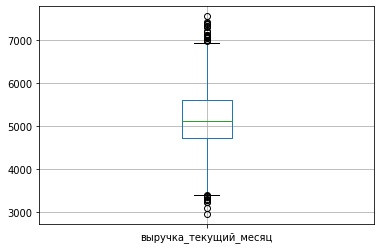

In [145]:
df_pre_level.boxplot(column=['выручка_текущий_месяц']).legend = False

Наблюдаем слегка выбивающиеся значения

#### Cумма выручки за предыдущий месяц

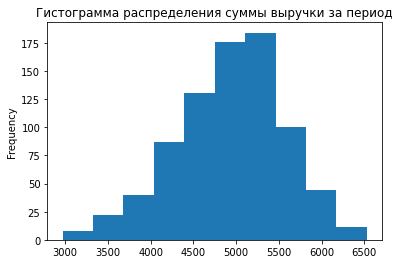

In [146]:
df_pre_level['выручка_предыдущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения суммы выручки за период'
                                ).legend = False

In [147]:
df_pre_level['выручка_предыдущий_месяц'].describe()

count     802.000000
mean     4932.559227
std       625.075845
min      2970.000000
25%      4507.500000
50%      4977.250000
75%      5349.500000
max      6531.000000
Name: выручка_предыдущий_месяц, dtype: float64

Гистограмма напомминает нормальное распределение чуть скошенное вправо,  разброс выручки наблюдается от 2970 до 6537, в среднем выручка на пользователя с покупательской способностью за предыдущий месяц составляет 4932

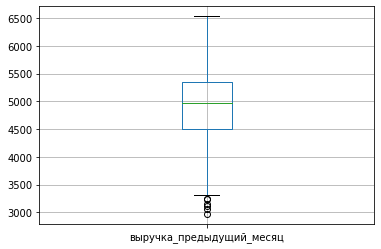

In [148]:
df_pre_level.boxplot(column=['выручка_предыдущий_месяц']).legend = False

Значения находящиеся в левой части распределения слегка выбиваются из общей массы значений

#### Cумма выручки за препредыдущий месяц

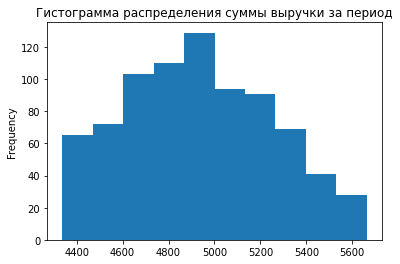

In [149]:
df_pre_level['выручка_препредыдущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения суммы выручки за период'
                                ).legend = False

In [150]:
df_pre_level['выручка_препредыдущий_месяц'].describe()

count     802.000000
mean     4933.475062
std       320.484850
min      4338.000000
25%      4683.250000
50%      4927.000000
75%      5172.500000
max      5663.000000
Name: выручка_препредыдущий_месяц, dtype: float64

Напоминает нормальное распределение со 'скосом' по левому краю, разброс выручки за препредыдущий месяц варьируется от 4338 до 5663, в среднем 4933

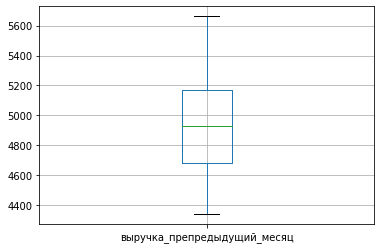

In [151]:
df_pre_level.boxplot(column=['выручка_препредыдущий_месяц']).legend = False

Аномальных значений не наблюдаем

#### Значение времени за текущий месяц, проведённого на сайте, в минутах

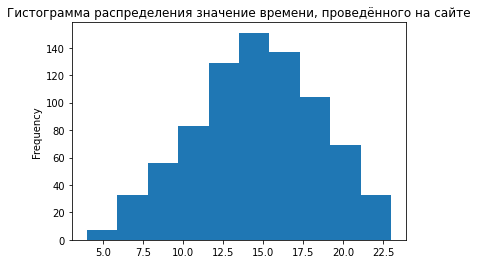

In [152]:
df_pre_level['минут_текущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения значение времени, проведённого на сайте'
                                ).legend = False

In [153]:
df_pre_level['минут_текущий_месяц'].describe()

count    802.000000
mean      14.604738
std        4.064355
min        4.000000
25%       12.000000
50%       15.000000
75%       18.000000
max       23.000000
Name: минут_текущий_месяц, dtype: float64

Нормальное распределение со 'скосом' к правому краю, разброс времени за текущий месяц: от 4 до 23, в среднем 14.6

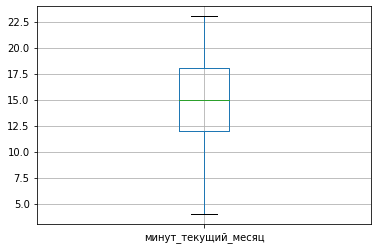

In [154]:
df_pre_level.boxplot(column=['минут_текущий_месяц']).legend = False

Аномальных значений не наблюдаем

#### Значение времени за предыдущий месяц, проведённого на сайте, в минутах

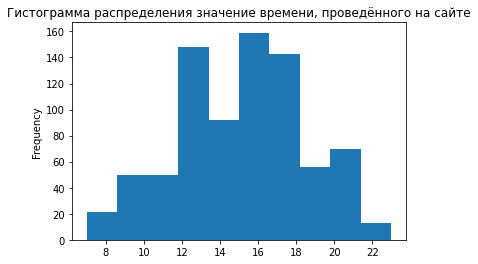

In [155]:
df_pre_level['минут_предыдущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения значение времени, проведённого на сайте'
                                ).legend = False

In [156]:
df_pre_level['минут_предыдущий_месяц'].describe()

count    802.000000
mean      15.029925
std        3.352991
min        7.000000
25%       13.000000
50%       15.000000
75%       18.000000
max       23.000000
Name: минут_предыдущий_месяц, dtype: float64

Напоминает нормальное распределение с 2-мя пиковыми значениями 13мин и 16 мин, разброс времени за предыдущий месяц варьируется от 7 до 23, в среднем 15

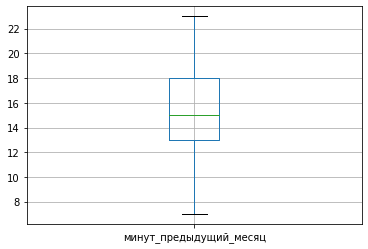

In [157]:
df_pre_level.boxplot(column=['минут_предыдущий_месяц']).legend = False

Аномальных значений не наблюдаем

#### Вывод по анализу клиентов с покупательской способностью:

Проведя анализ клиентов с покупательной способностью были найдены следующие отличительные черты этого кластера:

-чуть больше покупателей сервиса 'стандартного' уровня (74.31%) и меньше покупателей 'премиум'(25.68%)

-на распределении среднемесячной доля покупок по акции от общего числа покупок за последние 6 месяцев изменение провала на значениях ~0.5-0.9, среднее значение значимо сместилось (0.23)

-изменение в соотношении популярных категорий товаров. Товары для детей(22.94%) по убыванию: Домашний текстиль(18.57%), Мелкая бытовая техника и электроника(18.32%), Техника для красоты и здоровья(16.45%), Косметика и аксесуары(14.71%), Кухонная посуда(8.97%)

-изменение в соотношении кол-ва категорий которые просматривает покупатель за визит. 3 категории просматривают (27.68%) пользователей за визит, 2 категории(16.95%), 4 категории(24.93%), 5 категорий(18.95%), 1 категорию(2.74%) и 6 категорий(8.72%)

-изменение в соотношении числа неоплаченных товаров в корзине. 1 (24.93%) и 2 (22.19%) товара, 3 товара (18.07%), 4 (15.21%), 5 (7.98%), 0 (10.84%), 6 (0.37%), 7 (0.24%) и меньше всего 8 (0.12%) товаров

-небольшие изменения в соотношении числа сбоев, которые коснулись покупателя во время посещения сайта. 4 (20.32%) сбоя, 3 сбоя(14.96%), 5 (17.83%), 2 (11.59%), 6 (14.08%), 7 (6.98%), 1 (5.23%), 8 (5.36%), 0 (2.11%) и 9 (1.49%) у меньше всего пользователей

-изменение в кол-ве посещенных страниц за один визит на сайт. Чаще всего покупатели посещают 8, 9, 10(12.21-11.22%) страниц за визит на сайт, (9.47-7.85%) пользователей посещают: 11, 6, 7, 12 страниц соответственно; (6.6-3.8%) посещают: 13, 14, 5, 4, 15 страниц; меньше всего (2.11-0%) пользователей посещают: 16, 17, 3, 18, 19, 20 страниц. Слегка выбивается значение 8 страниц за визит из общего нормального распределения

Проанализированы распределения выручки (за текущий, предыдущий, препредыдущий месяц) и времени (за текущий, предыдущий месяц), проведенного на сайте для пользователей с покупательской способностью:

-выручка за текущий месяц напоминает нормальное распределение, разброс выручки наблюдается от 2952 до 7547, в среднем выручка на пользователя с покупательской способностью за текущий месяц составляет 5197.7

-выручка за предыдущий месяц напомминает нормальное распределение чуть скошенное вправо,  разброс выручки наблюдается от 2970 до 6537, в среднем выручка на пользователя с покупательской способностью за предыдущий месяц составляет 4932

-выручка за препредыдущий месяц напоминает нормальное распределение со 'скосом' по левому краю, разброс выручки за препредыдущий месяц варьируется от 4338 до 5663, в среднем 4933

-значение времени за текущий месяц напоминает нормальное распределение со 'скосом' к правому краю, разброс времени за текущий месяц: от 4 до 23, в среднем 14.6

-значение времени за предыдущий месяц напоминает нормальное распределение с 2-мя пиковыми значениями 13мин и 16 мин, разброс времени за предыдущий месяц варьируется от 7 до 23, в среднем 15

### Корреляционный анализ

Построим "хитмап" по матрице корреляций Фика, посмотрим на связь признаков с целевой переменной и для отслеживания мультиколлинеарности 

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'cтраниц_за_визит', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'минут_текущий_месяц', 'минут_предыдущий_месяц']


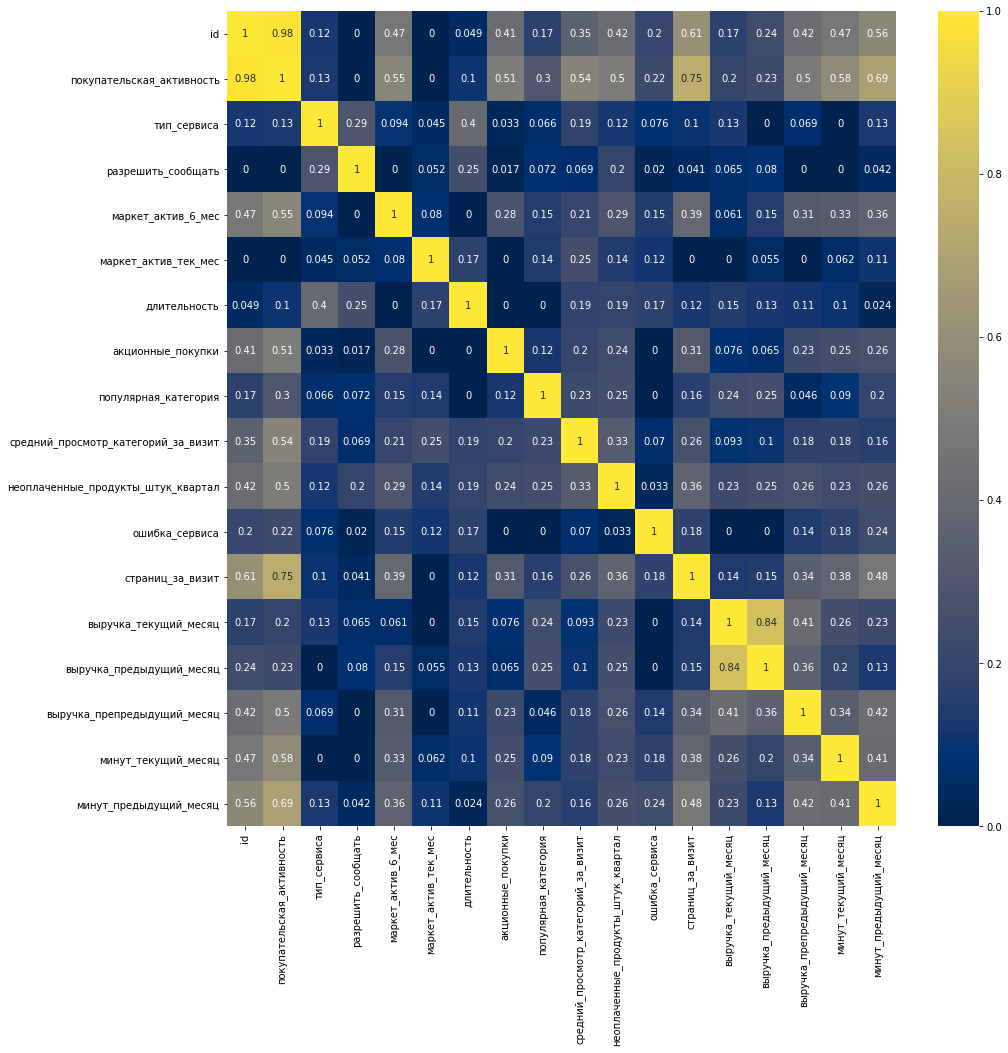

In [158]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.phik_matrix(), annot=True, cmap='cividis',).legend = False

Мультиколлинеарности в данных не прослеживается

Посмотрим отдельно на переменные которые имеют коффицент корриляции с целевым признаком выше 0.5, для формирования промежуточных итогов анализа

#### Ср. маркет. активности за 6 месяцев относительно покупательской активности

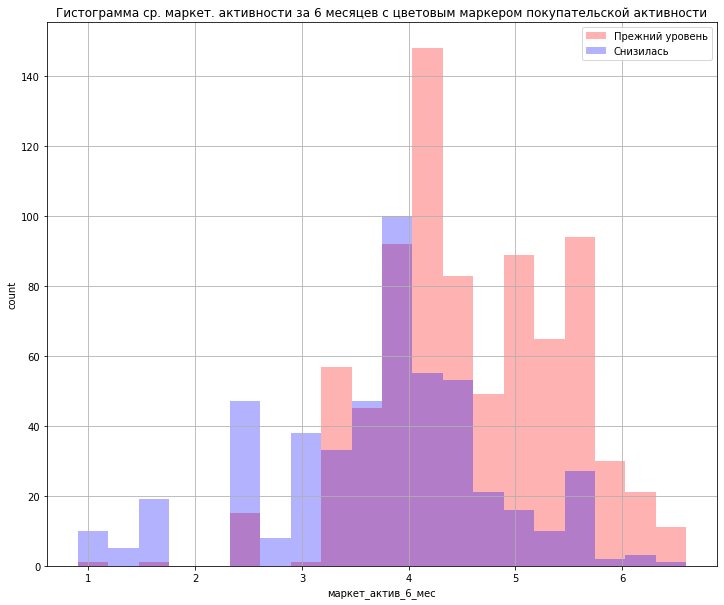

In [159]:
fig, ax = plt.subplots(figsize=(12, 10))
for color, row, leg in ['red', 'Прежний уровень', 'Прежний уровень'], ['blue', 'Снизилась', 'Снизилась']:
    x = df[df['покупательская_активность'] == row]['маркет_актив_6_мес']
    plt.hist(x, bins=20, color=color, alpha=0.3, label=leg)
plt.xlabel('маркет_актив_6_мес')
plt.ylabel('count')
plt.legend(loc="best")
plt.title('Гистограмма ср. маркет. активности за 6 месяцев с цветовым маркером покупательской активности')
plt.grid(True)
plt.show()

Можем наблюдать что у пользователей с коммуникацией ниже 4 в большенстве покупательская активность сниженная, нежели у пользователей с коммуникацией больше 4 - покупательская активность на прежнем уровне

#### Ср.месячная доля покупок по акции относительно покупательской активности

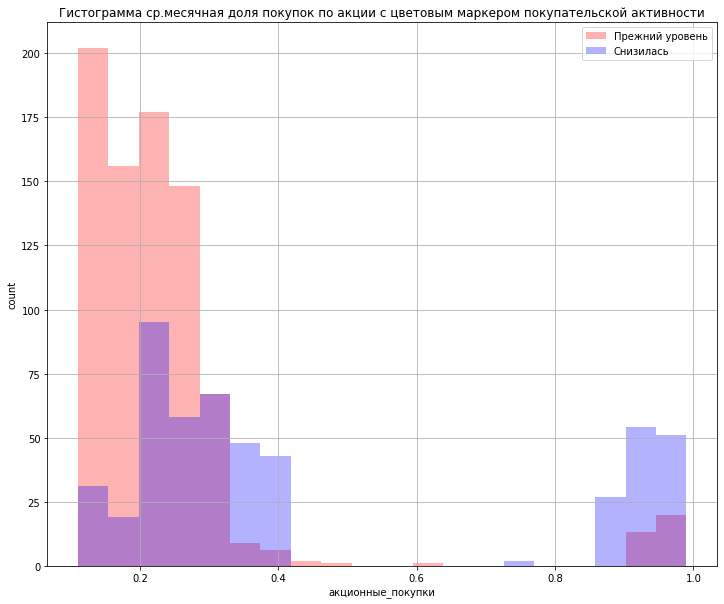

In [160]:
fig, ax = plt.subplots(figsize=(12, 10))
for color, row, leg in ['red', 'Прежний уровень', 'Прежний уровень'], ['blue', 'Снизилась', 'Снизилась']:
    x = df[df['покупательская_активность'] == row]['акционные_покупки']
    plt.hist(x, bins=20, color=color, alpha=0.3, label=leg)
plt.xlabel('акционные_покупки')
plt.ylabel('count')
plt.legend(loc="best")
plt.title('Гистограмма ср.месячная доля покупок по акции с цветовым маркером покупательской активности')
plt.grid(True)
plt.show()

Наблюдаем преобладание покупателей с покупательской активностью на прежнем уровне у пользователей которых доля покупок по акции ниже 0.3, при доле покупок по акции свыше ~0.35 идет перевес в сторону пользователей со сниженной покупательской активностью

#### Cколько категорий просмотрел за визит относительно покупательской активности

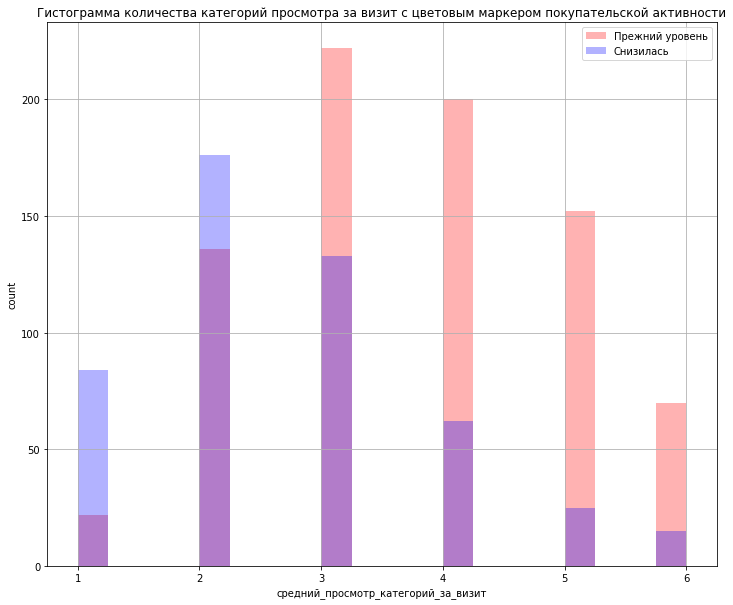

In [161]:
fig, ax = plt.subplots(figsize=(12, 10))
for color, row, leg in ['red', 'Прежний уровень', 'Прежний уровень'], ['blue', 'Снизилась', 'Снизилась']:
    x = df[df['покупательская_активность'] == row]['средний_просмотр_категорий_за_визит']
    plt.hist(x, bins=20, color=color, alpha=0.3, label=leg)
plt.xlabel('средний_просмотр_категорий_за_визит')
plt.ylabel('count')
plt.legend(loc="best")
plt.title('Гистограмма количества категорий просмотра за визит с цветовым маркером покупательской активности')
plt.grid(True)
plt.show()

Наблюдаем что при ср. просмотре категорий за визит равном 2 идет перевес в сторону сниженной покупательской активности и при снижении просмотра категорий повышается доля пользователей со сниженной покупателской активностью,  при ср. просмотре категорий за визит равном 3 идет перевес в сторону прежнего уровня покупательской активности и при повышении просмотра категорий повышается доля пользователей с прежним уровнем покупателской активности

#### Общее число неоплаченных товаров в корзине за 3 месяца относительно покупательской активности

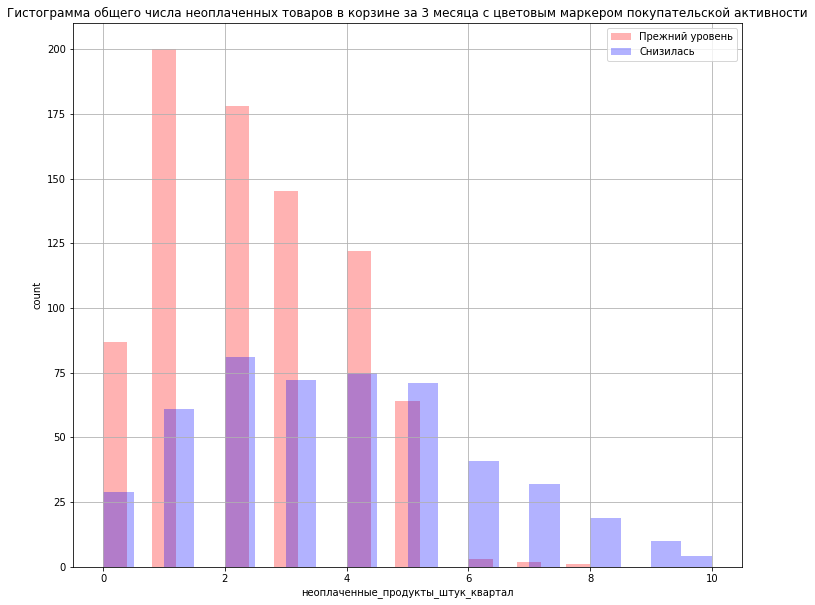

In [162]:
fig, ax = plt.subplots(figsize=(12, 10))
for color, row, leg in ['red', 'Прежний уровень', 'Прежний уровень'], ['blue', 'Снизилась', 'Снизилась']:
    x = df[df['покупательская_активность'] == row]['неоплаченные_продукты_штук_квартал']
    plt.hist(x, bins=20, color=color, alpha=0.3, label=leg)
plt.xlabel('неоплаченные_продукты_штук_квартал')
plt.ylabel('count')
plt.legend(loc="best")
plt.title('Гистограмма общего числа неоплаченных товаров в корзине за 3 месяца с цветовым маркером покупательской активности')
plt.grid(True)
plt.show()

при числе неоплаченных товаров в корзине за 3 месяца равных 5 доли покупателей со сниженной покупательской активностью и с покупательской активностью на прежнем уровне равные, при повышении неоплачнных продуктов преобладает синий цветовой маркер, при понижении красный цветовой маркер 

#### Cреднее количество страниц за один визит на сайт относительно покупательской активности

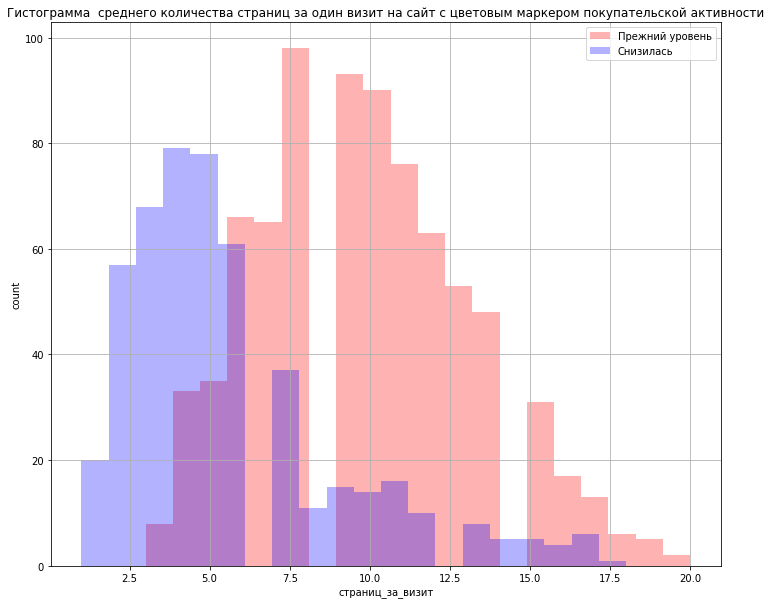

In [163]:
fig, ax = plt.subplots(figsize=(12, 10))
for color, row, leg in ['red', 'Прежний уровень', 'Прежний уровень'], ['blue', 'Снизилась', 'Снизилась']:
    x = df[df['покупательская_активность'] == row]['cтраниц_за_визит']
    plt.hist(x, bins=20, color=color, alpha=0.3, label=leg)
plt.xlabel('cтраниц_за_визит')
plt.ylabel('count')
plt.legend(loc="best")
plt.title('Гистограмма  cреднего количества страниц за один визит на сайт с цветовым маркером покупательской активности')
plt.grid(True)
plt.show()

Наблюдаем что при ср. количестве страниц за один визит на сайт равном 5 идет перевес в сторону сниженной покупательской активности и при снижении количества страниц повышается доля пользователей со сниженной покупателской активностью, при ср. количестве страниц за один визит на сайт равном 6 идет перевес в сторону прежнего уровня покупательской активности и при повышении количества страниц повышается доля пользователей с прежним уровнем покупательской активности

#### Времени за текущий месяц, проведённого на сайте относительно покупательской активности

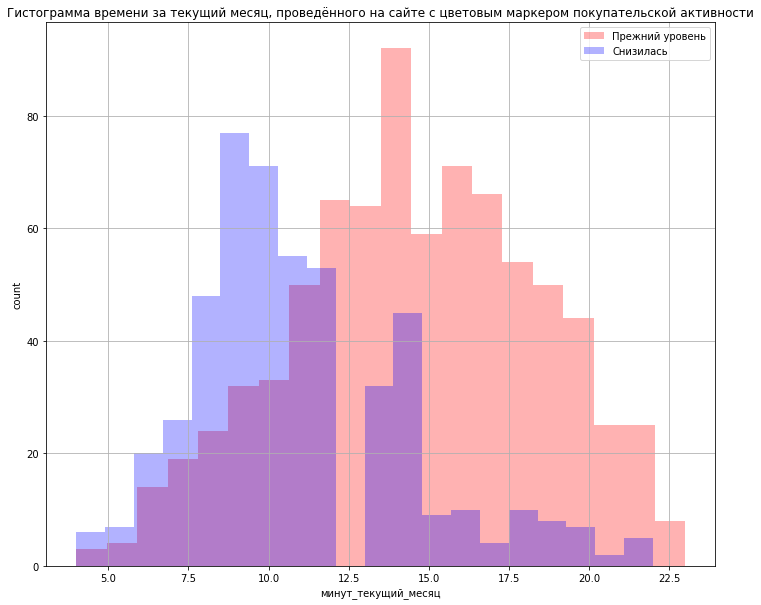

In [164]:
fig, ax = plt.subplots(figsize=(12, 10))
for color, row, leg in ['red', 'Прежний уровень', 'Прежний уровень'], ['blue', 'Снизилась', 'Снизилась']:
    x = df[df['покупательская_активность'] == row]['минут_текущий_месяц']
    plt.hist(x, bins=20, color=color, alpha=0.3, label=leg)
plt.xlabel('минут_текущий_месяц')
plt.ylabel('count')
plt.legend(loc="best")
plt.title('Гистограмма времени за текущий месяц, проведённого на сайте с цветовым маркером покупательской активности')
plt.grid(True)
plt.show()

Наблюдаем что при времени за текущий месяц, проведённого на сайте равном 10 минут идет перевес в сторону сниженной покупательской активности и при снижении времени повышается доля пользователей с прежним уровнем покупателской активности до значения ~равных долей, при времени равном 12 минут идет перевес в сторону прежнего уровня покупательской активности и при повышении времени повышается доля пользователей с прежним уровнем покупательской активности

#### Времени за предыдущий месяц, проведённого на сайте относительно покупательской активности

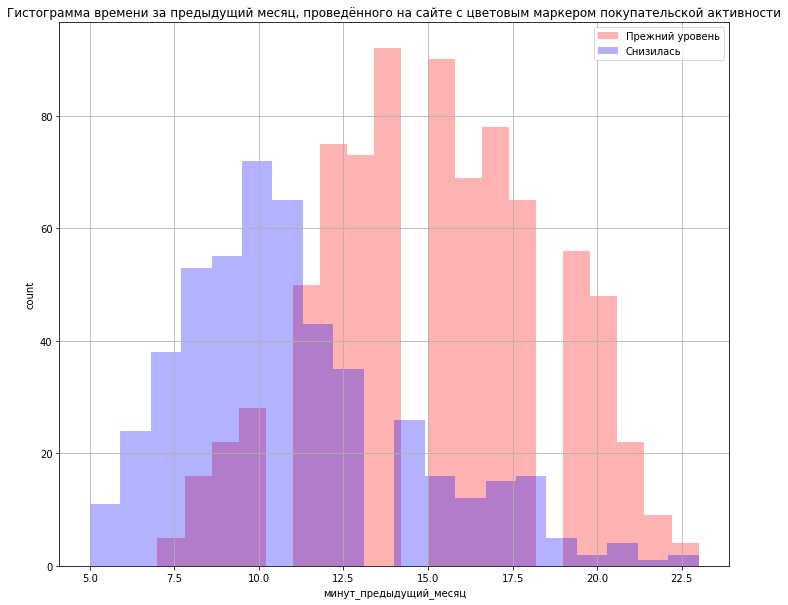

In [165]:
fig, ax = plt.subplots(figsize=(12, 10))
for color, row, leg in ['red', 'Прежний уровень', 'Прежний уровень'], ['blue', 'Снизилась', 'Снизилась']:
    x = df[df['покупательская_активность'] == row]['минут_предыдущий_месяц']
    plt.hist(x, bins=20, color=color, alpha=0.3, label=leg)
plt.xlabel('минут_предыдущий_месяц')
plt.ylabel('count')
plt.legend(loc="best")
plt.title('Гистограмма времени за предыдущий месяц, проведённого на сайте с цветовым маркером покупательской активности')
plt.grid(True)
plt.show()

Наблюдаем что при времени за предыдущий месяц, проведённого на сайте равном 11 минут идет перевес в сторону сниженной покупательской активности и при снижении времени повышается доля пользователей со сниженной покупателской активностью, при времени равном 12 минут идет перевес в сторону прежнего уровня покупательской активности и при повышении времени повышается доля пользователей с прежним уровнем покупательской активности

### Использование пайплайнов

Выделим 'фичи' и целевую переменную, разделим данные на тренировочные и тестовые в соотношении 3:1

In [166]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность','id'], axis=1),
    df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность'])

Создаем списки с названиями признаков для масштабирования и кодирования

In [167]:
ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
ord_columns = ['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'cтраниц_за_визит']
num_columns = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'выручка_текущий_месяц',
               'выручка_препредыдущий_месяц', 'минут_текущий_месяц', 
              'минут_предыдущий_месяц']

Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование

In [168]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
    )

Создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование

In [169]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    [3, 4, 5], 
                    [1, 2, 3, 4, 5, 6],
                    [0 ,1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

Создаём общий пайплайн для подготовки данных

In [170]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Создаём итоговый пайплайн: подготовка данных и модель

In [171]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Задаем параметры для кросс-валидации и перебора моделей с гиперпараметрами

In [172]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            kernel = 'poly'
        )],
        'models__degree': range(1, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

В качестве метрики будем использовать ROC-AUC т.к. необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности и класса объекта

In [173]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImpute

Лучшей моделью на кросс-валидации получилась логистическая регрессия с лассо-регуляризацией и  силой регуляризации равной 7

### Анализ важности признаков

#### Базовая модель

Преобразуем данные для обучения и обучим лучшую модель что получилась на кросс-валидации

Подготовка признаков (масштабирование и кодирование)

In [174]:
encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])

encoder_col_names = encoder.get_feature_names()

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_sub = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_sub = pd.concat([X_test_ohe, X_test_scaled], axis=1)

ordered_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=np.nan, 
    categories=[
                    [3, 4, 5], 
                    [1, 2, 3, 4, 5, 6],
                    [0 ,1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
                ]
)

X_train_ord = ordered_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ordered_encoder.transform(X_test[ord_columns])

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_columns)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_columns)

basic_X_train = pd.concat([X_train_sub, X_train_ord], axis=1)
basic_X_test = pd.concat([X_test_sub, X_test_ord], axis=1)
basic_y_train = y_train
basic_y_test = y_test

Обучение модели

In [175]:
basic_model = LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
            C=7
        )
basic_model = basic_model.fit(basic_X_train, basic_y_train)

Получение предсказания на тестовых данных и расчет метрики ROC-AUC

In [176]:
y_test_pred = basic_model.predict(basic_X_test)
y_test_bi = basic_y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Метрика ROC-AUC на тестовой выборке: 0.8854718343765046


Взглянем на коэффициенты обученной модели и оценим вес признаков

In [ ]:
coefficients = basic_model.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': basic_X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)).legend = False

Наблюдаем что модель преимущественно ориентируется, при оценки класса целевого признака, на количественные входные признаки, меньший вес имеет значение 2-ой ('популярная_категория') категориальной переменной. Категориальные признаки порядкового значения имеют наименьший вес

Оценим вклад каждого признака в классификацию всех наблюдений, построим диаграмму Шепли

In [ ]:
explainer = shap.LinearExplainer(basic_model, basic_X_train)
shap_values = explainer(basic_X_train)

shap.plots.beeswarm(shap_values)

На диаграмме можем оценить вклад каждого признака на результат, как при положительных или отрицательных значениях входных признаков модель принимает решение о принадлежности значения целевого признака к определенному классу(цветовая маркировка от синего к красному)

In [ ]:
shap.plots.bar(shap_values) 

2-ая диаграмма иллюстрирует важность признаков. Значения Шепли взято по модулю, чтобы положительные и отрицательные значения не сводили друг друга к нулю. Наблюдаем топ значимости признаков для нашей модели по Шепли, по убыванию значимость признаков:страниц_за_визит, средний_просмотр_категорий_за_визит, минут_предыдущий_месяц, минут_текущий_месяц и тд

Попробуем отобрать самые весомы признаки по значениям Шепли

#### Отсеивание входных признаков

Оставим только самые весомые признаки и попытаемся добиться лучшего качества модели

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность','id'], axis=1),
    df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность'])



ohe_columns = ['популярная_категория']
ord_columns = ['средний_просмотр_категорий_за_визит', 'cтраниц_за_визит', 'неоплаченные_продукты_штук_квартал']
num_columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц', 'акционные_покупки','маркет_актив_6_мес']

Масштабирование и кодирование

In [ ]:
encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])

encoder_col_names = encoder.get_feature_names()

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

X_train_sub = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_sub = pd.concat([X_test_ohe, X_test_scaled], axis=1)

ordered_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=np.nan, 
    categories=[
                    [1, 2, 3, 4, 5, 6],
                    range(1, 21),
                    [0 ,1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                ]
)

X_train_ord = ordered_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ordered_encoder.transform(X_test[ord_columns])

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_columns)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_columns)

X_train = pd.concat([X_train_sub, X_train_ord], axis=1)
X_test = pd.concat([X_test_sub, X_test_ord], axis=1)

Обучение модели

In [ ]:
model = LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
            C=7
        )
model = model.fit(X_train, y_train)

In [ ]:
y_test_pred = model.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Наблюдаем падение качества модели на метрике ROC-AUC, исходное значение метрики 0.883

In [ ]:
coefficients = model.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)).legend = False

Значения коэффицентов регрессии модели поменялись и входные признаки имеют иной вес

Было(по убыванию коэффиценты): выручка_препредыдущий_месяц, маркет_актив_6_мес, акционные_покупки, минут_предыдущий_месяц, минут_текущий_месяц, x2_Мелкая бытовая техника и электроника(признак 'популярная_категория'), x2_Техника для красоты и здоровья(признак 'популярная_категория'), средний_просмотр_категорий_за_визит и тд

Стало(по убыванию коэффиценты): минут_предыдущий_месяц, маркет_актив_6_мес, акционные_покупки, минут_текущий_месяц, x0_Мелкая бытовая техника и электроника(признак 'популярная_категория'), x0_Техника для красоты и здоровья(признак 'популярная_категория') и тд

In [ ]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values) 

Приоритет веса признаков для модели по диаграмме Шепли не поменялся, слегка сместились коэффициенты

Посмотрим как на новых входных данных обучатся модели с подобранными гиперпараметрами под кросс-валидацией, с целью получения лучшего качества модели

In [ ]:
model = LogisticRegression(random_state=RANDOM_STATE)

parameters = {
    'C': [i*0.1 for i in range(1, 10)]+[i for i in range(1, 30)],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['saga', 'liblinear']
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

In [ ]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

parameters = {
    'max_depth': range(1, 30),
    'max_features': range(1, 30),
    'min_samples_split': range(1, 50, 3)
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

In [ ]:
model = KNeighborsClassifier()

parameters = {
    'n_neighbors': range(1, 1000, 10),
    'metric': ['cityblock', 'euclidean']
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

In [ ]:
model = SVC(kernel='rbf')

parameters = {
    'C': range(0, 101, 5)
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Наблюдаем на всех моделях 'недотягивания' до желаемого качества, хуже чем у базовой модели ROC-AUC=0.883

Попробуем ввести полиномиальные признаки 2го порядка (возможно линейные модели лучше будут улавливать связь)

#### Полиномиальные признаки

Возвращаем исходные названия признаков для масштабирования и кодирования

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность','id'], axis=1),
    df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность'])



ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
ord_columns = ['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'cтраниц_за_визит']
num_columns = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'выручка_текущий_месяц',
               'выручка_препредыдущий_месяц', 'выручка_препредыдущий_месяц', 'минут_текущий_месяц', 
              'минут_предыдущий_месяц']

Масштабирование, кодирование, добавление полиномиальных признаков 2-го порядка

In [ ]:
encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])

encoder_col_names = encoder.get_feature_names()

X_train_num = X_train[num_columns]
X_test_num = X_test[num_columns]

poly = PolynomialFeatures(2)
X_train_num = poly.fit_transform(X_train_num)
X_test_num = poly.transform(X_test_num)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=poly.get_feature_names())
X_test_scaled = pd.DataFrame(X_test_scaled, columns=poly.get_feature_names())

X_train_sub = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_sub = pd.concat([X_test_ohe, X_test_scaled], axis=1)

ordered_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=np.nan, 
    categories=[
                    [3, 4, 5], 
                    [1, 2, 3, 4, 5, 6],
                    [0 ,1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
                ]
)

X_train_ord = ordered_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ordered_encoder.transform(X_test[ord_columns])

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_columns)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_columns)

X_train = pd.concat([X_train_sub, X_train_ord], axis=1)
X_test = pd.concat([X_test_sub, X_test_ord], axis=1)

In [ ]:
X_train.info()

Суммарно получилось 57 входных признаков

Обучение модели

In [ ]:
model = LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
            C=7
        )
model = model.fit(X_train, y_train)

In [ ]:
y_test_pred = model.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Наблюдаем снижение целевой метрики, видимо много равнозначных признаков что ухудшает качество модели

In [ ]:
coefficients = model.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 30)).legend = False

Наблюдаем что за исключением x7 основной вес имеют полиномиальные признаки, часть признаков имеет 0-ой коэффициент т.к. мы используем лассо-регуляризацию

In [ ]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values) 

Наблюдаем идентичную оценку важности признаков у значения Шепли как у коэффициентов регрессии что касается x7, x6 и полиномов, а вот ранговые признаки(средний_просмотр_категорий_за_визит, страниц_за_визит) имеют больший вес по мнению Шепли

Проверим как модели с подбором гиперпараметров под кросс-валидацией справятся с новыми данными

In [ ]:
model = LogisticRegression(random_state=RANDOM_STATE)

parameters = {
    'C': [i*0.1 for i in range(1, 10)]+[i for i in range(1, 30)],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['saga', 'liblinear']
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

In [ ]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

parameters = {
    'max_depth': range(1, 30),
    'max_features': range(1, 30),
    'min_samples_split': range(1, 50, 3)
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

In [ ]:
model = KNeighborsClassifier()

parameters = {
    'n_neighbors': range(1, 1000, 10),
    'metric': ['cityblock', 'euclidean']
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

In [ ]:
model = SVC(kernel='rbf')

parameters = {
    'C': range(0, 101, 5)
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Все модели показали на тестовой выборке результат хуже чем у бызовой модели, в отличии от валидационной выборки(почти у всех 0.9), что нам говорит о данных которые склонны переобучать модель

Отфильтруем полиномиальные признаки

#### Применение селектора на количественные признаки

Подготовка данных

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность','id'], axis=1),
    df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность'])



ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
ord_columns = ['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'cтраниц_за_визит']
num_columns = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'выручка_текущий_месяц',
               'выручка_препредыдущий_месяц', 'выручка_препредыдущий_месяц', 'минут_текущий_месяц', 
              'минут_предыдущий_месяц']

Масштабирование и кодирование

In [ ]:
encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])

encoder_col_names = encoder.get_feature_names()

X_train_num = X_train[num_columns]
X_test_num = X_test[num_columns]

poly = PolynomialFeatures(2)
X_train_num = poly.fit_transform(X_train_num)
X_test_num = poly.transform(X_test_num)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=poly.get_feature_names())
X_test_scaled = pd.DataFrame(X_test_scaled, columns=poly.get_feature_names())


ordered_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=np.nan, 
    categories=[
                    [3, 4, 5], 
                    [1, 2, 3, 4, 5, 6],
                    [0 ,1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
                ]
)

X_train_ord = ordered_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ordered_encoder.transform(X_test[ord_columns])

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_columns)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_columns)

Перебор используемых количественных признаков, с целью подбора k селектора(сколько будет использоваться входных признаков) при котором целевая метрика будет максимальна на базовой модели

In [ ]:
for i in range(len(X_test_scaled.columns)):

    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train_scaled, y_train)
    features_names = X_train_scaled.columns[selector.get_support(indices=True)]
    X_train_scaled1 = X_train_scaled[list(features_names)]
    X_test_scaled1 = X_test_scaled[list(features_names)]

    X_train_sub = pd.concat([X_train_ohe, X_train_scaled1], axis=1)
    X_test_sub = pd.concat([X_test_ohe, X_test_scaled1], axis=1)

    X_train = pd.concat([X_train_sub, X_train_ord], axis=1)
    X_test = pd.concat([X_test_sub, X_test_ord], axis=1)

    model = LogisticRegression(
                random_state=RANDOM_STATE, 
                solver='liblinear', 
                penalty='l1',
                C=7
            )

    model = model.fit(X_train, y_train)

    y_test_pred = model.predict(X_test)
    y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
    y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
    print(i)
    print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

При итерации когда k=9 значение ROC-AUC максимально, зафиксируем это

In [ ]:
selector = SelectKBest(f_classif, k=9)
selector.fit(X_train_scaled, y_train)
features_names = X_train_scaled.columns[selector.get_support(indices=True)]
X_train_scaled1 = X_train_scaled[list(features_names)]
X_test_scaled1 = X_test_scaled[list(features_names)]

X_train_sub = pd.concat([X_train_ohe, X_train_scaled1], axis=1)
X_test_sub = pd.concat([X_test_ohe, X_test_scaled1], axis=1)

X_train = pd.concat([X_train_sub, X_train_ord], axis=1)
X_test = pd.concat([X_test_sub, X_test_ord], axis=1)

Обучение модели (для проверки)

In [ ]:
model = LogisticRegression(
                random_state=RANDOM_STATE, 
                solver='liblinear', 
                penalty='l1',
                C=7
            )

model = model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Значение ROC-AUC соответствует ожидаемому, но не лучше чем у базовой модели

In [ ]:
model = LogisticRegression(random_state=RANDOM_STATE)

parameters = {
    'C': [i*0.1 for i in range(1, 10)]+[i for i in range(1, 30)],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['saga', 'liblinear']
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

In [ ]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

parameters = {
    'max_depth': range(1, 30),
    'max_features': range(1, 30),
    'min_samples_split': range(1, 50, 3)
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

In [210]:
model = KNeighborsClassifier()

parameters = {
    'n_neighbors': range(1, 1000, 10),
    'metric': ['cityblock', 'euclidean']
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 KNeighborsClassifier(metric='cityblock', n_neighbors=151)
Метрика лучшей модели на тренировочной выборке: 0.8783238304420123
Метрика ROC-AUC на тестовой выборке: 0.8817806130637137


In [211]:
model = SVC(kernel='rbf')

parameters = {
    'C': range(0, 101, 5)
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 SVC(C=10)
Метрика лучшей модели на тренировочной выборке: 0.8973512297421389
Метрика ROC-AUC на тестовой выборке: 0.8743179264965495


Все модели показали на тестовой выборке результат хуже чем у базовой модели

#### Применение селектора на все признаки

Подготовка данных

In [212]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность','id'], axis=1),
    df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность'])



ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
ord_columns = ['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'cтраниц_за_визит']
num_columns = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'выручка_текущий_месяц',
               'выручка_препредыдущий_месяц', 'выручка_препредыдущий_месяц', 'минут_текущий_месяц', 
              'минут_предыдущий_месяц']

Масштабирование и кодирование

In [213]:
encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])

encoder_col_names = encoder.get_feature_names()

X_train_num = X_train[num_columns]
X_test_num = X_test[num_columns]

poly = PolynomialFeatures(2)
X_train_num = poly.fit_transform(X_train_num)
X_test_num = poly.transform(X_test_num)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=poly.get_feature_names())
X_test_scaled = pd.DataFrame(X_test_scaled, columns=poly.get_feature_names())

X_train_sub = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_sub = pd.concat([X_test_ohe, X_test_scaled], axis=1)

ordered_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=np.nan, 
    categories=[
                    [3, 4, 5], 
                    [1, 2, 3, 4, 5, 6],
                    [0 ,1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
                ]
)

X_train_ord = ordered_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ordered_encoder.transform(X_test[ord_columns])

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_columns)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_columns)

X_train = pd.concat([X_train_sub, X_train_ord], axis=1)
X_test = pd.concat([X_test_sub, X_test_ord], axis=1)

Перебор всех входных признаков

In [214]:
for i in range(len(X_test.columns)):

    selector = SelectKBest(f_classif, k=i+1)
    selector.fit(X_train, y_train)
    features_names = X_train.columns[selector.get_support(indices=True)]
    X_train1 = X_train[list(features_names)]
    X_test1 = X_test[list(features_names)]


    model = LogisticRegression(
                random_state=RANDOM_STATE, 
                solver='liblinear', 
                penalty='l1',
                C=7
            )

    model = model.fit(X_train1, y_train)

    y_test_pred = model.predict(X_test1)
    y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
    y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
    print(i)
    print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

0
Метрика ROC-AUC на тестовой выборке: 0.8152985074626866
1
Метрика ROC-AUC на тестовой выборке: 0.8674570694912533
2
Метрика ROC-AUC на тестовой выборке: 0.8739768897448243
3
Метрика ROC-AUC на тестовой выборке: 0.8739768897448243
4
Метрика ROC-AUC на тестовой выборке: 0.8739768897448243
5
Метрика ROC-AUC на тестовой выборке: 0.8724321938693629
6
Метрика ROC-AUC на тестовой выборке: 0.8724321938693629
7
Метрика ROC-AUC на тестовой выборке: 0.8764644519338791
8
Метрика ROC-AUC на тестовой выборке: 0.8839271385010432
9
Метрика ROC-AUC на тестовой выборке: 0.8839271385010432
10
Метрика ROC-AUC на тестовой выборке: 0.8814395763119885
11
Метрика ROC-AUC на тестовой выборке: 0.8814395763119885
12
Метрика ROC-AUC на тестовой выборке: 0.8814395763119885
13
Метрика ROC-AUC на тестовой выборке: 0.8814395763119885
14
Метрика ROC-AUC на тестовой выборке: 0.8789520141229338
15
Метрика ROC-AUC на тестовой выборке: 0.8789520141229338
16
Метрика ROC-AUC на тестовой выборке: 0.8789520141229338
17
Метр

При итерации когда k=15 значение ROC-AUC максимальна

In [215]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
features_names = X_train.columns[selector.get_support(indices=True)]
X_train1 = X_train[list(features_names)]
X_test1 = X_test[list(features_names)]

model = LogisticRegression(
                random_state=RANDOM_STATE, 
                solver='liblinear', 
                penalty='l1',
                C=7
            )

model = model.fit(X_train1, y_train)

y_test_pred = model.predict(X_test1)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Метрика ROC-AUC на тестовой выборке: 0.8789520141229338


In [216]:
X_train = X_train1
X_test = X_test1

In [217]:
model = LogisticRegression(random_state=RANDOM_STATE)

parameters = {
    'C': [i*0.1 for i in range(1, 10)]+[i for i in range(1, 30)],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['saga', 'liblinear']
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 LogisticRegression(C=21, random_state=42, solver='liblinear')
Метрика лучшей модели на тренировочной выборке: 0.8725160400069492
Метрика ROC-AUC на тестовой выборке: 0.8829842721874498


In [218]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

parameters = {
    'max_depth': range(1, 30),
    'max_features': range(1, 30),
    'min_samples_split': range(1, 50, 3)
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 DecisionTreeClassifier(max_depth=28, max_features=13, min_samples_split=34,
                       random_state=42)
Метрика лучшей модели на тренировочной выборке: 0.8562041123768397
Метрика ROC-AUC на тестовой выборке: 0.8165824105280052


In [219]:
model = KNeighborsClassifier()

parameters = {
    'n_neighbors': range(1, 1000, 10),
    'metric': ['cityblock', 'euclidean']
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 KNeighborsClassifier(metric='cityblock', n_neighbors=151)
Метрика лучшей модели на тренировочной выборке: 0.8715830193830193
Метрика ROC-AUC на тестовой выборке: 0.8848700048146365


In [220]:
model = SVC(kernel='rbf')

parameters = {
    'C': range(0, 101, 5)
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 SVC(C=95)
Метрика лучшей модели на тренировочной выборке: 0.8887536371081826
Метрика ROC-AUC на тестовой выборке: 0.8923326913818007


Наблюдаем лучшее качество чем у базовой модели (ROC-AUC=0.883), улучшение качества на 0.03 по метрике ROC-AUC

Отфлильтруем самые коррелируемые признаки после применения селектора

#### Фильтрация признаков после селектора примененного на все признаки

Фит базовой модели после применения лучшего селектора на всех признаках(после полиномизации)

In [221]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
features_names = X_train.columns[selector.get_support(indices=True)]
X_train1 = X_train[list(features_names)]
X_test1 = X_test[list(features_names)]


model = LogisticRegression(
                random_state=RANDOM_STATE, 
                solver='liblinear', 
                penalty='l1',
                C=7
            )

model = model.fit(X_train1, y_train)

y_test_pred = model.predict(X_test1)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Метрика ROC-AUC на тестовой выборке: 0.8789520141229338


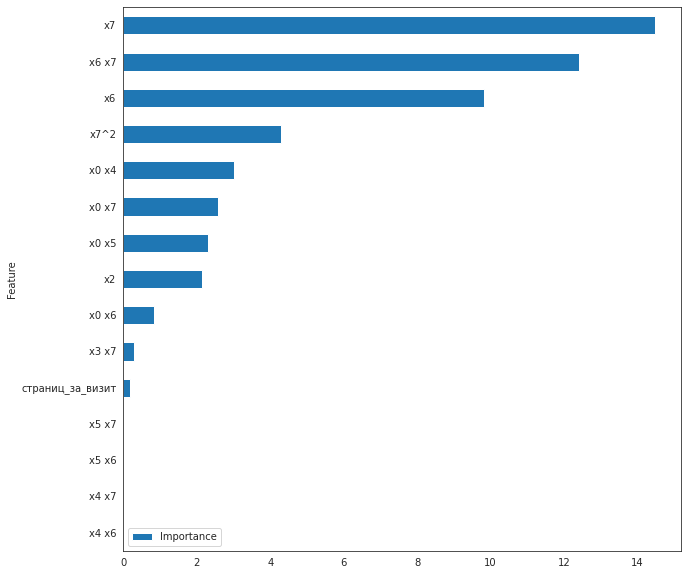

In [222]:
coefficients = model.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': X_train1.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 10)).legend = False

interval columns not set, guessing: ['x2', 'x6', 'x7', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x3 x7', 'x4 x6', 'x4 x7', 'x5 x6', 'x5 x7', 'x6 x7', 'x7^2', 'cтраниц_за_визит']


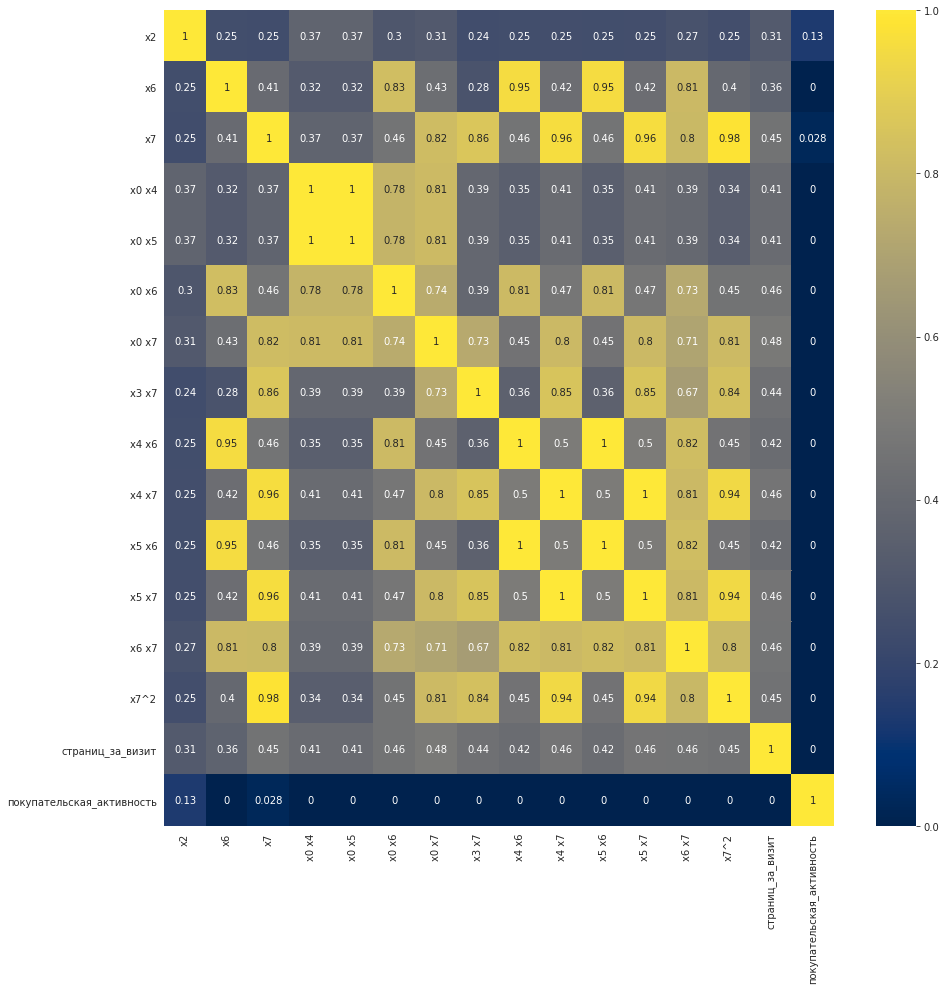

In [223]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(pd.concat([X_train1, y_train], axis=1).phik_matrix(), annot=True, cmap='cividis',).legend = False

In [224]:
X_train1.columns

Index(['x2', 'x6', 'x7', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x3 x7', 'x4 x6',
       'x4 x7', 'x5 x6', 'x5 x7', 'x6 x7', 'x7^2', 'cтраниц_за_визит'],
      dtype='object')

Отфильтруем графически по принципу удаления признаков с наименьшими коэффициентами регрессии и коэффициентами корреляции выше 0.9

In [225]:
X_train1 = X_train1[['x2', 'x6', 'x7', 'x0 x4', 'x0 x6', 'x0 x7', 'x3 x7',
'x6 x7', 'cтраниц_за_визит']]
X_test1 = X_test1[['x2', 'x6', 'x7', 'x0 x4', 'x0 x6', 'x0 x7', 'x3 x7',
'x6 x7', 'cтраниц_за_визит']]

In [226]:
model = LogisticRegression(
                random_state=RANDOM_STATE, 
                solver='liblinear', 
                penalty='l1',
                C=7
            )

model = model.fit(X_train1, y_train)

y_test_pred = model.predict(X_test1)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Метрика ROC-AUC на тестовой выборке: 0.8829842721874498


interval columns not set, guessing: ['x2', 'x6', 'x7', 'x0 x4', 'x0 x6', 'x0 x7', 'x3 x7', 'x6 x7', 'cтраниц_за_визит']


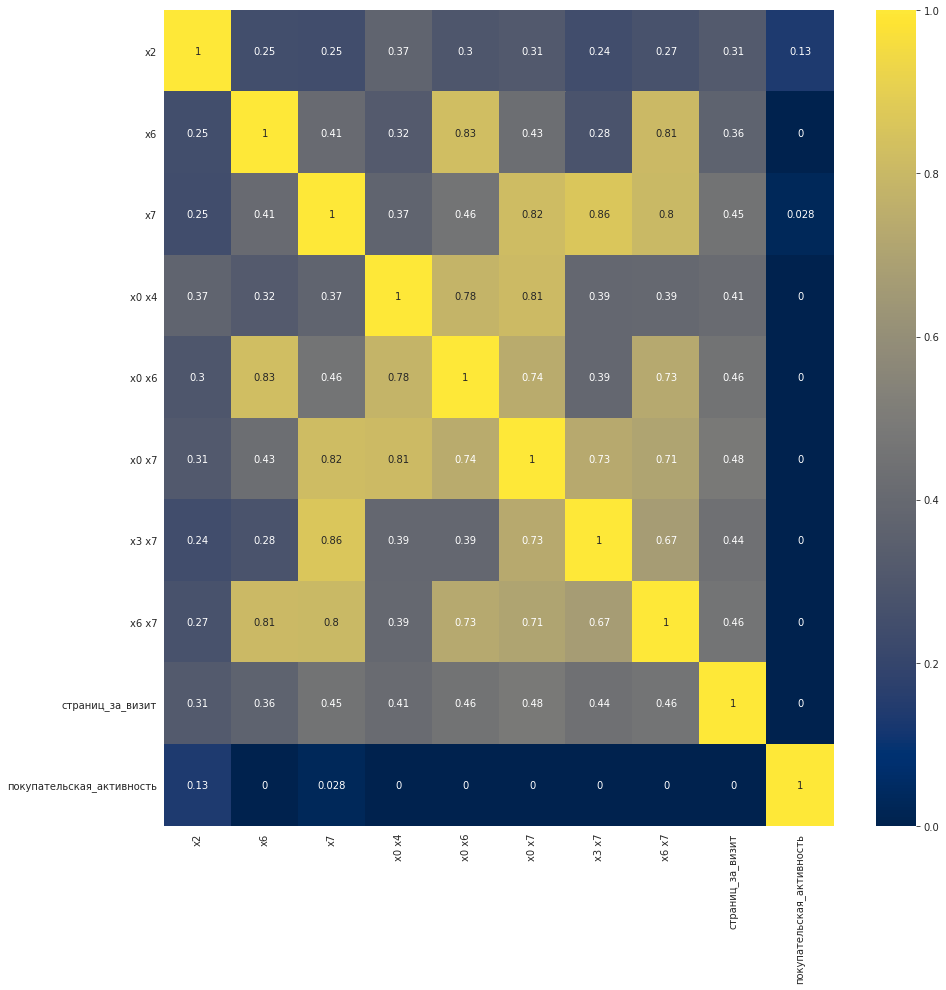

In [227]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(pd.concat([X_train1, y_train], axis=1).phik_matrix(), annot=True, cmap='cividis',).legend = False

Прогоним получившиеся признаки через модели 

In [228]:
X_train = X_train1

In [229]:
X_test = X_test1

In [230]:
model = LogisticRegression(random_state=RANDOM_STATE)

parameters = {
    'C': [i*0.1 for i in range(1, 10)]+[i for i in range(1, 30)],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['saga', 'liblinear']
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 LogisticRegression(C=24, penalty='l1', random_state=42, solver='liblinear')
Метрика лучшей модели на тренировочной выборке: 0.8732935100389646
Метрика ROC-AUC на тестовой выборке: 0.8804967099983951


In [231]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

parameters = {
    'max_depth': range(1, 30),
    'max_features': range(1, 30),
    'min_samples_split': range(1, 50, 3)
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 DecisionTreeClassifier(max_depth=25, max_features=8, min_samples_split=40,
                       random_state=42)
Метрика лучшей модели на тренировочной выборке: 0.869697801106892
Метрика ROC-AUC на тестовой выборке: 0.8286791847215536


In [232]:
model = KNeighborsClassifier()

parameters = {
    'n_neighbors': range(1, 1000, 10),
    'metric': ['cityblock', 'euclidean']
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 KNeighborsClassifier(metric='cityblock', n_neighbors=151)
Метрика лучшей модели на тренировочной выборке: 0.8675550815278088
Метрика ROC-AUC на тестовой выборке: 0.8724321938693629


In [233]:
model = SVC(kernel='rbf')

parameters = {
    'C': range(0, 101, 5)
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 SVC(C=95)
Метрика лучшей модели на тренировочной выборке: 0.8865344451889905
Метрика ROC-AUC на тестовой выборке: 0.8923326913818007


Есть прирост качества на 0.1 по метрике ROC-AUC у модели SVC(C=35) относительно базовой модели (ROC-AUC=0.883)

#### Фильтрация признаков после селектора примененного на кол-ые признаки

Подготовка данных

In [234]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность','id'], axis=1),
    df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность'])



ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
ord_columns = ['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'cтраниц_за_визит']
num_columns = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'выручка_текущий_месяц',
               'выручка_препредыдущий_месяц', 'выручка_препредыдущий_месяц', 'минут_текущий_месяц', 
              'минут_предыдущий_месяц']

Масштабирование и кодирование

In [235]:
encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])

encoder_col_names = encoder.get_feature_names()

X_train_num = X_train[num_columns]
X_test_num = X_test[num_columns]

poly = PolynomialFeatures(2)
X_train_num = poly.fit_transform(X_train_num)
X_test_num = poly.transform(X_test_num)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=poly.get_feature_names())
X_test_scaled = pd.DataFrame(X_test_scaled, columns=poly.get_feature_names())

ordered_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=np.nan, 
    categories=[
                    [3, 4, 5], 
                    [1, 2, 3, 4, 5, 6],
                    [0 ,1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
                ]
)

X_train_ord = ordered_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ordered_encoder.transform(X_test[ord_columns])

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_columns)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_columns)

Применения лучшего селектора на кол-ых признаках(после полиномизации)

In [236]:
selector = SelectKBest(f_classif, k=9)
selector.fit(X_train_scaled, y_train)
features_names = X_train_scaled.columns[selector.get_support(indices=True)]
X_train_scaled1 = X_train_scaled[list(features_names)]
X_test_scaled1 = X_test_scaled[list(features_names)]

X_train_sub = pd.concat([X_train_ohe, X_train_scaled1], axis=1)
X_test_sub = pd.concat([X_test_ohe, X_test_scaled1], axis=1)
X_train = pd.concat([X_train_sub, X_train_ord], axis=1)
X_test = pd.concat([X_test_sub, X_test_ord], axis=1)

model = LogisticRegression(
                random_state=RANDOM_STATE, 
                solver='liblinear', 
                penalty='l1',
                C=7
            )

model = model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)    
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Метрика ROC-AUC на тестовой выборке: 0.8724321938693629


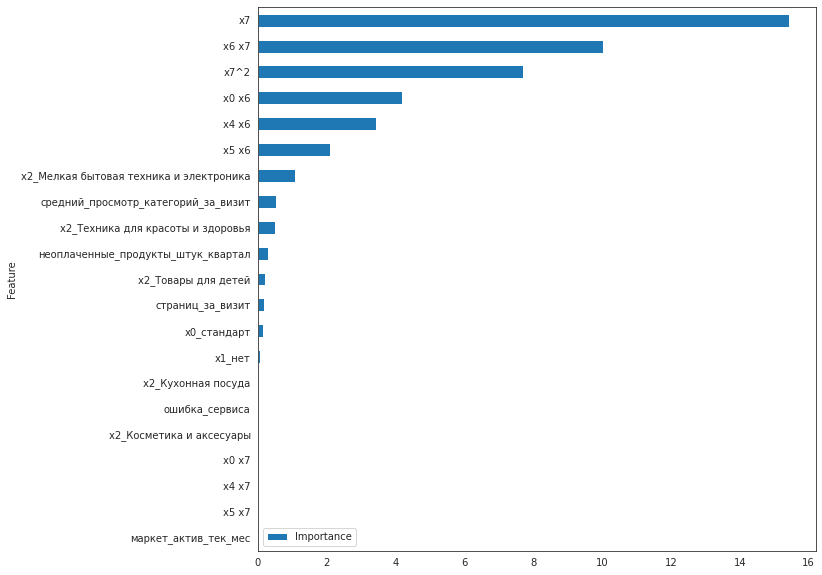

In [237]:
coefficients = model.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 10)).legend = False

interval columns not set, guessing: ['x0_стандарт', 'x1_нет', 'x2_Косметика и аксесуары', 'x2_Кухонная посуда', 'x2_Мелкая бытовая техника и электроника', 'x2_Техника для красоты и здоровья', 'x2_Товары для детей', 'x7', 'x0 x6', 'x0 x7', 'x4 x6', 'x4 x7', 'x5 x6', 'x5 x7', 'x6 x7', 'x7^2', 'маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'cтраниц_за_визит']


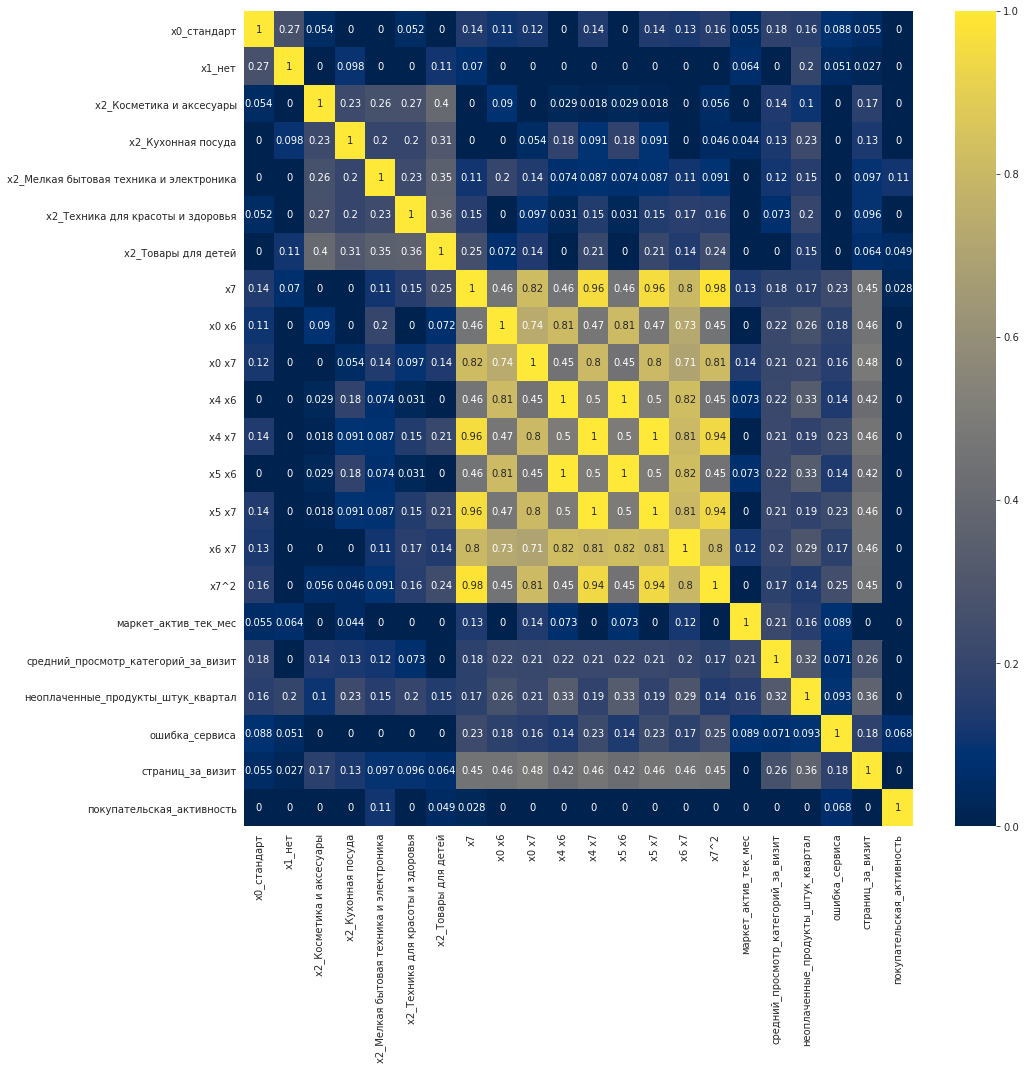

In [238]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(pd.concat([X_train, y_train], axis=1).phik_matrix(), annot=True, cmap='cividis',).legend = False

Фильтрация признаков с наименьшими коэффициентами регрессии и коэффициентами корреляции выше 0.9

In [239]:
X_train = X_train[['x0_стандарт', 'x1_нет', 'x2_Косметика и аксесуары',
       'x2_Кухонная посуда', 'x2_Мелкая бытовая техника и электроника',
       'x2_Техника для красоты и здоровья', 'x2_Товары для детей', 'x7',
       'x0 x6', 'x0 x7', 'x4 x6', 'x6 x7',
       'маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'cтраниц_за_визит']]
X_test = X_test[['x0_стандарт', 'x1_нет', 'x2_Косметика и аксесуары',
       'x2_Кухонная посуда', 'x2_Мелкая бытовая техника и электроника',
       'x2_Техника для красоты и здоровья', 'x2_Товары для детей', 'x7',
       'x0 x6', 'x0 x7', 'x4 x6', 'x6 x7', 
       'маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'cтраниц_за_визит']]

In [240]:
model = LogisticRegression(
                random_state=RANDOM_STATE, 
                solver='liblinear', 
                penalty='l1',
                C=7
            )

model = model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Метрика ROC-AUC на тестовой выборке: 0.8674570694912533


interval columns not set, guessing: ['x0_стандарт', 'x1_нет', 'x2_Косметика и аксесуары', 'x2_Кухонная посуда', 'x2_Мелкая бытовая техника и электроника', 'x2_Техника для красоты и здоровья', 'x2_Товары для детей', 'x7', 'x0 x6', 'x0 x7', 'x4 x6', 'x6 x7', 'маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'cтраниц_за_визит']


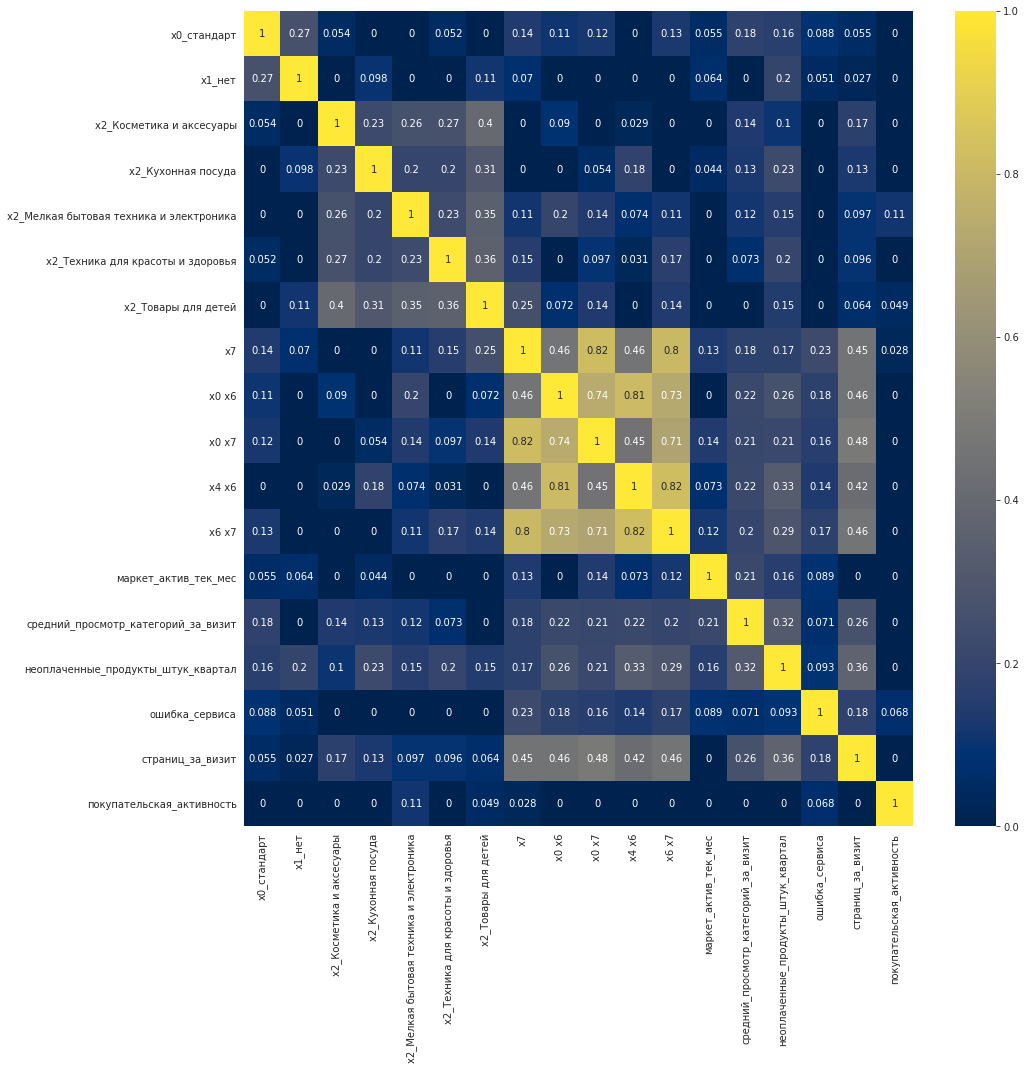

In [241]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(pd.concat([X_train, y_train], axis=1).phik_matrix(), annot=True, cmap='cividis',).legend = False

Посмотрим на лучшие модели полученные на текущих данных

In [242]:
model = LogisticRegression(random_state=RANDOM_STATE)

parameters = {
    'C': [i*0.1 for i in range(1, 10)]+[i for i in range(1, 30)],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['saga', 'liblinear']
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 LogisticRegression(C=21, random_state=42, solver='liblinear')
Метрика лучшей модели на тренировочной выборке: 0.8902172064626608
Метрика ROC-AUC на тестовой выборке: 0.8674570694912533


In [243]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE)

parameters = {
    'max_depth': range(1, 30),
    'max_features': range(1, 30),
    'min_samples_split': range(1, 50, 3)
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 DecisionTreeClassifier(max_depth=24, max_features=2, min_samples_split=22,
                       random_state=42)
Метрика лучшей модели на тренировочной выборке: 0.8771239719057901
Метрика ROC-AUC на тестовой выборке: 0.8488404750441343


In [244]:
model = KNeighborsClassifier()

parameters = {
    'n_neighbors': range(1, 1000, 10),
    'metric': ['cityblock', 'euclidean']
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 KNeighborsClassifier(metric='cityblock', n_neighbors=301)
Метрика лучшей модели на тренировочной выборке: 0.871773433350706
Метрика ROC-AUC на тестовой выборке: 0.8445474241694753


In [245]:
model = SVC(kernel='rbf')

parameters = {
    'C': range(0, 101, 5)
}

randomized_search = RandomizedSearchCV(
    model, 
    parameters, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
y_test_pred = randomized_search.predict(X_test)
y_test_bi = y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Лучшая модель и её параметры:

 SVC(C=10)
Метрика лучшей модели на тренировочной выборке: 0.8945481919936464
Метрика ROC-AUC на тестовой выборке: 0.8768054886856042


Все модели показали на тестовой выборке результат хуже чем у базовой модели

Зафиксируем результат лучшей модели

#### Фиксирование лучшей модели

Подготовка, масштабирование, кодирование, введение полиномиальных фич, применение селектора на все признаки(k=15), отбор признаков с наименьшими коэффициентами регрессии и коэффициентами корреляции выше 0.9, обучение лучшей модели полученной на этих признаках

In [246]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['покупательская_активность','id'], axis=1),
    df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['покупательская_активность'])



ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
ord_columns = ['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'cтраниц_за_визит']
num_columns = ['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'выручка_текущий_месяц',
               'выручка_препредыдущий_месяц', 'выручка_препредыдущий_месяц', 'минут_текущий_месяц', 
              'минут_предыдущий_месяц']

encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])

encoder_col_names = encoder.get_feature_names()

X_train_num = X_train[num_columns]
X_test_num = X_test[num_columns]

poly = PolynomialFeatures(2)
X_train_num = poly.fit_transform(X_train_num)
X_test_num = poly.transform(X_test_num)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=poly.get_feature_names())
X_test_scaled = pd.DataFrame(X_test_scaled, columns=poly.get_feature_names())

X_train_sub = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_sub = pd.concat([X_test_ohe, X_test_scaled], axis=1)

ordered_encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=np.nan, 
    categories=[
                    [3, 4, 5], 
                    [1, 2, 3, 4, 5, 6],
                    [0 ,1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
                ]
)

X_train_ord = ordered_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ordered_encoder.transform(X_test[ord_columns])

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_columns)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_columns)

X_train = pd.concat([X_train_sub, X_train_ord], axis=1)
X_test = pd.concat([X_test_sub, X_test_ord], axis=1)

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
features_names = X_train.columns[selector.get_support(indices=True)]

X_train1 = X_train[list(features_names)]
X_test1 = X_test[list(features_names)]

best_y_train = y_train
best_y_test = y_test
best_X_train = X_train1[['x2', 'x6', 'x7', 'x0 x4', 'x0 x6', 'x0 x7', 'x3 x7',
'x6 x7', 'cтраниц_за_визит']]
best_X_test = X_test1[['x2', 'x6', 'x7', 'x0 x4', 'x0 x6', 'x0 x7', 'x3 x7',
'x6 x7', 'cтраниц_за_визит']]

best_model = SVC(kernel='rbf', C=35)

best_model = best_model.fit(best_X_train, best_y_train)

y_test_pred = best_model.predict(best_X_test)
y_test_bi = best_y_test.apply(lambda x: 0 if x == 'Прежний уровень' else 1)
y_test_pred_bi = pd.Series(y_test_pred).apply(lambda x: 0 if x == 'Прежний уровень' else 1)

result = cross_val_score(best_model, best_X_train, best_y_train, scoring='roc_auc')
mn = np.mean(result)
std = np.std(result)

print(f'Метрика ROC-AUC на кросс-валидации: {mn} с стандартным отклонением: {std}')
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_bi, y_test_pred_bi)}')

Метрика ROC-AUC на кросс-валидации: 0.8830805896805897 с стандартным отклонением: 0.01869219240114043
Метрика ROC-AUC на тестовой выборке: 0.8923326913818007


In [247]:
X_train1.columns

Index(['x2', 'x6', 'x7', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x3 x7', 'x4 x6',
       'x4 x7', 'x5 x6', 'x5 x7', 'x6 x7', 'x7^2', 'cтраниц_за_визит'],
      dtype='object')

### Сегментация покупателей

#### Cамые важные признаки в данных

За неимением возможности интерпретировать гиперпространство радиальной базисной функции у лучшей модели, построим диаграмму Шепли для модели SVM с теми же параметрами но с линейным ядром(возможность построения на диаграмме многомерное пространство признаков с проекцией гиперплоскости), для выявления самых важных признаков и того как они влияют на предсказание модели

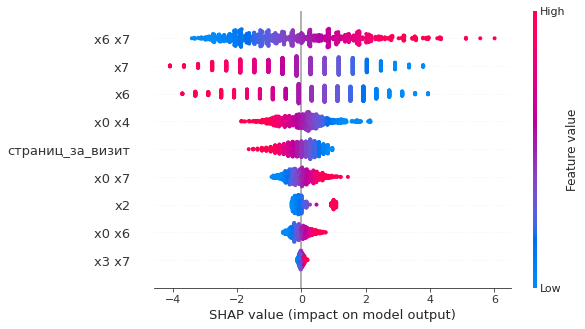

In [248]:
model = SVC(kernel='linear', C=35)
model = model.fit(best_X_train, best_y_train)

explainer = shap.LinearExplainer(model, best_X_train)
shap_values = explainer(best_X_train)

shap.plots.beeswarm(shap_values)

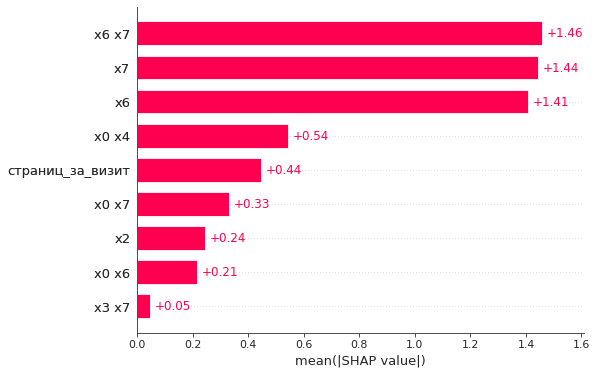

In [249]:
shap.plots.bar(shap_values) 

Построим диаграмму Шепли на модели регрессии с гиперпараметрами подобранными на кросс-валидации у текущих данных

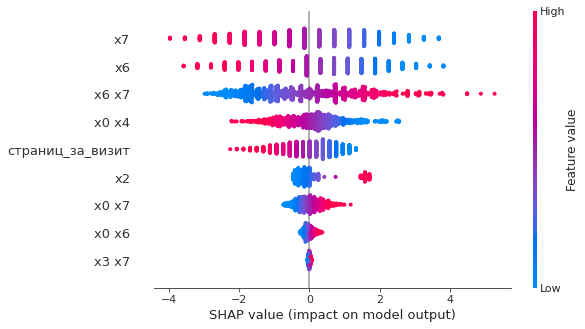

In [250]:
model = LogisticRegression(C=21, random_state=42, solver='liblinear')
model = model.fit(best_X_train, best_y_train)

explainer = shap.LinearExplainer(model, best_X_train)
shap_values = explainer(best_X_train)

shap.plots.beeswarm(shap_values)

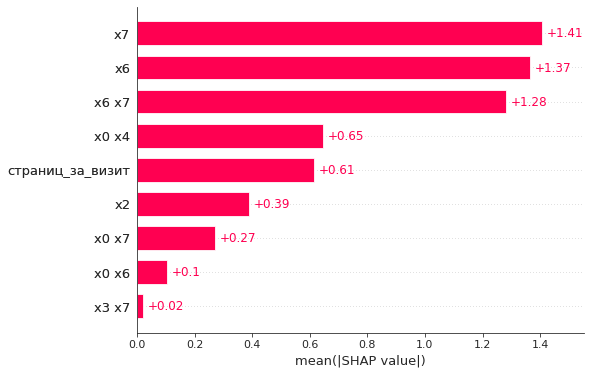

In [251]:
shap.plots.bar(shap_values) 

Резюмируя выше построенные диаграммы наблюдаем что входные признаки имеют идентичные веса и типичную склонность моделей предсказывать целевой признак при положительных или отрицательных значениях входных признаков. Благодоря чему можно выделить сегмент покупателей с прежним уровнем покупательской активности и у которых такие признаки(не считая полиномы) что по диаграмме Шепли склоняют покупательскую активность к 'прежнему уровню':

-необходимо повышать значение времени которое покупатель провёл на сайте в текщем месяце

-необходимо повышать значение времени которое покупатель провёл на сайте в предыдущем месяце

-необходимо повышать среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца

#### Выделение сегмента покпателей 

Выделим сегмент покупателей со сниженной покупательской активностью, проанализируем его и выявим его особенности

In [252]:
df_low = df[df['покупательская_активность'] == 'Снизилась']
df_low = df_low.merge(df_m,on='id', how='inner')
df_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 0 to 494
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   495 non-null    int64  
 1   покупательская_активность            495 non-null    object 
 2   тип_сервиса                          495 non-null    object 
 3   разрешить_сообщать                   495 non-null    object 
 4   маркет_актив_6_мес                   495 non-null    float64
 5   маркет_актив_тек_мес                 495 non-null    int64  
 6   длительность                         495 non-null    int64  
 7   акционные_покупки                    495 non-null    float64
 8   популярная_категория                 495 non-null    object 
 9   средний_просмотр_категорий_за_визит  495 non-null    int64  
 10  неоплаченные_продукты_штук_квартал   495 non-null    int64  
 11  ошибка_сервиса                  

#### Уровень сервиса

In [253]:
t = df_low.groupby('тип_сервиса')['id'].count()
t = t/len(df_low) * 100
t

тип_сервиса
премиум     34.141414
стандарт    65.858586
Name: id, dtype: float64

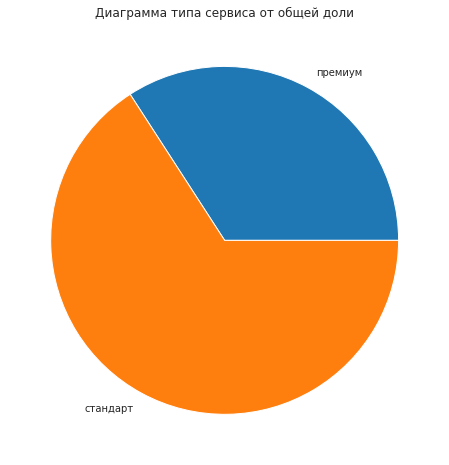

In [254]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма типа сервиса от общей доли').legend = False

Общее: У большинства покупателей сервис 'стандартного' уровня (71.07%) у меньшего числа покупателей 'премиум' (28.92%)

Различие: Меньше покупателей сервиса 'стандартного' уровня (65.86%) и больше покупателей 'премиум'(34.13%)

#### Информация о том, можно ли присылать покупателю дополнительные предложения о товаре

In [255]:
t = df_low.groupby('разрешить_сообщать')['id'].count()
t = t/len(df_low) * 100
t

разрешить_сообщать
да     74.343434
нет    25.656566
Name: id, dtype: float64

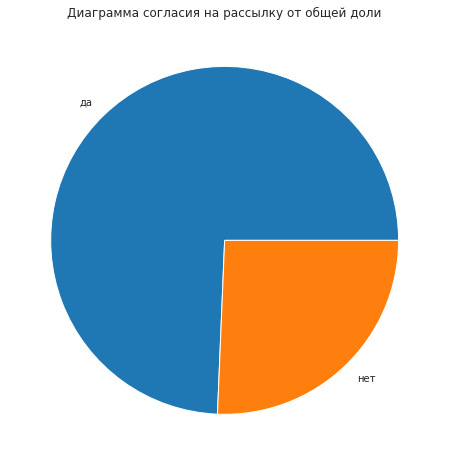

In [256]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма согласия на рассылку от общей доли').legend = False

Общее: Большинства покупателей дали согласие на рассылку (74%), меньшинство отказалось (26%)

Различие: Соотношение незначительно поменялось покупателей дали согласие на рассылку (74.49%), отказалось (25.5%)

#### Cр.месячное значение маркетинговых коммуникаций компании,  на покупателя за 6 месяцев

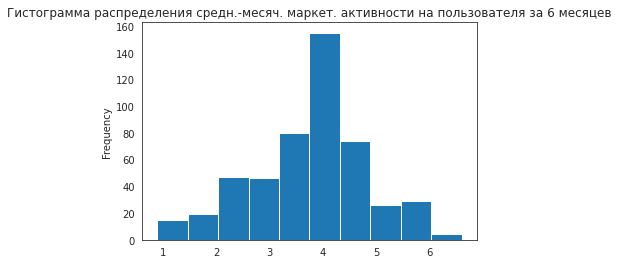

In [257]:
df_low['маркет_актив_6_мес'].plot(kind='hist',
                                 title = 'Гистограмма распределения средн.-месяч. маркет. активности на пользователя за 6 месяцев'
                                ).legend = False

In [258]:
df_low['маркет_актив_6_мес'].describe()

count    495.000000
mean       3.743030
std        1.055728
min        0.900000
25%        3.100000
50%        3.900000
75%        4.400000
max        6.600000
Name: маркет_актив_6_мес, dtype: float64

Общее: Гистограмма напомминает нормальное распределение чуть скошенное вправо, разброс наблюдается от 0.9 до 6.6, в среднем на покупателя 4.25 коммуникации, медианное значение слегка отличается (4.2) от среднего из-за 'скоса вправо'

Различие: Среднее значение отличается (3.74) как и медиана (3.9), гистограмма более 'нормализованна'

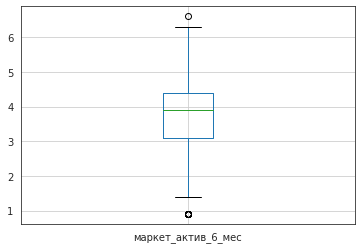

In [259]:
df_low.boxplot(column=['маркет_актив_6_мес']).legend = False

Общее: Наблюдаем выход некоторых значений за границы межквартильного размаха, не столь экстремальные чтобы делать с ними что-то, вероятнее всего данные соответствуют реальности

Различие: аналогично

#### Количество маркетинговых коммуникаций в текущем месяце

In [260]:
t = df_low.groupby('маркет_актив_тек_мес')['id'].count()
t = t/len(df_low) * 100
t

маркет_актив_тек_мес
3    24.646465
4    50.101010
5    25.252525
Name: id, dtype: float64

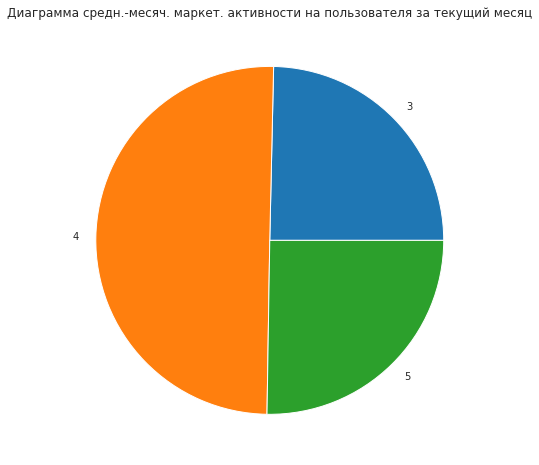

In [261]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма средн.-месяч. маркет. активности на пользователя за текущий месяц').legend = False

Общее: Большинство покупателей сталкиваются с 4-мя коммуникациями за месяц (51.46%), меньше покупателей сталкиваются с 5 коммуникациями (24.84%) и с 3 сталкиваются (23.69%) пользователей

Различие: Соотношение слегка отличается 4-мя(49.79%), 5(25.7%) и 3-мя(24.49%)

#### Cколько дней прошло с момента регистрации

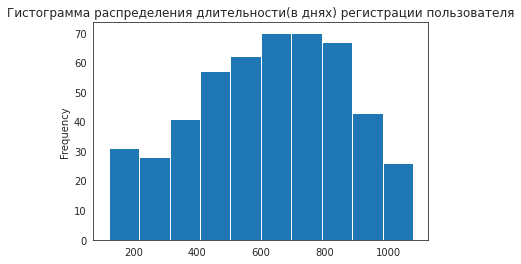

In [262]:
df_low['длительность'].plot(kind='hist',
                                 title = 'Гистограмма распределения длительности(в днях) регистрации пользователя'
                                ).legend = False

In [263]:
df_low['длительность'].describe()

count     495.000000
mean      622.862626
std       237.577077
min       121.000000
25%       449.000000
50%       637.000000
75%       812.000000
max      1079.000000
Name: длительность, dtype: float64

Общее: Гистограмма напоминает нормальное распределение, разброс дней варьируется от 110 до 1079, в среднем 601 дней прошло с момента регистрации покупателя

Различие: Незначительно поменялось ср.значение 619

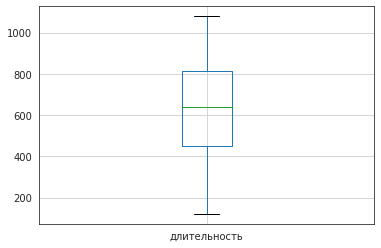

In [264]:
df_low.boxplot(column=['длительность']).legend = False

Общее: Аномальных значений не наблюдаем

Различие: аналогично

#### Ср.месячная доля покупок по акции

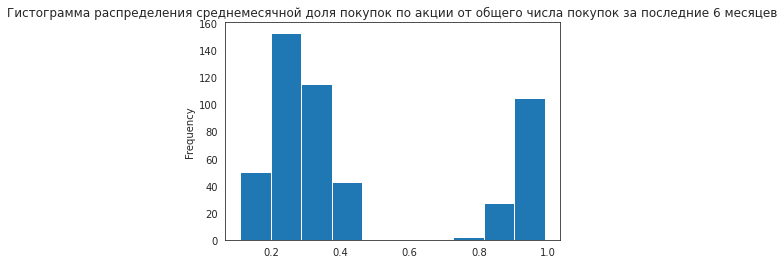

In [265]:
df_low['акционные_покупки'].plot(kind='hist',
                                 title = 'Гистограмма распределения среднемесячной доля покупок по акции от общего числа покупок за последние 6 месяцев'
                                ).legend = False

In [266]:
df_low['акционные_покупки'].describe()

count    495.000000
mean       0.453697
std        0.304908
min        0.110000
25%        0.240000
50%        0.310000
75%        0.890000
max        0.990000
Name: акционные_покупки, dtype: float64

Общее: Напоминает распределение Пуасона со 'скосом' к левому краю с провалом на значениях ~0.5-0.8 разброс доли покупок варьируется от 0 до 0.99, в среднем 0.31

Различие: Среднее значение весомо сместилось (0.45) 

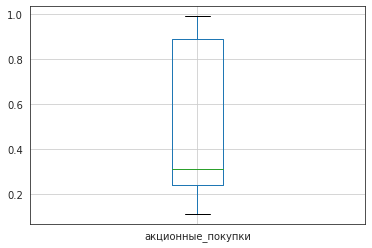

In [267]:
df_low.boxplot(column=['акционные_покупки']).legend = False

Общее: Значения находящиеся в правой части слегка выбиваются из общей массы значений, не будем принимать эти значения аномалльными т.к. они похоже на истинные

Различие: Аномальных значений не наблюдаем

####  Cамая популярная категория товаров

In [268]:
t = df_low.groupby('популярная_категория')['id'].count()
t = t/len(df_low) * 100
t

популярная_категория
Домашний текстиль                       20.404040
Косметика и аксесуары                   21.212121
Кухонная посуда                         13.333333
Мелкая бытовая техника и электроника     5.454545
Техника для красоты и здоровья          10.303030
Товары для детей                        29.292929
Name: id, dtype: float64

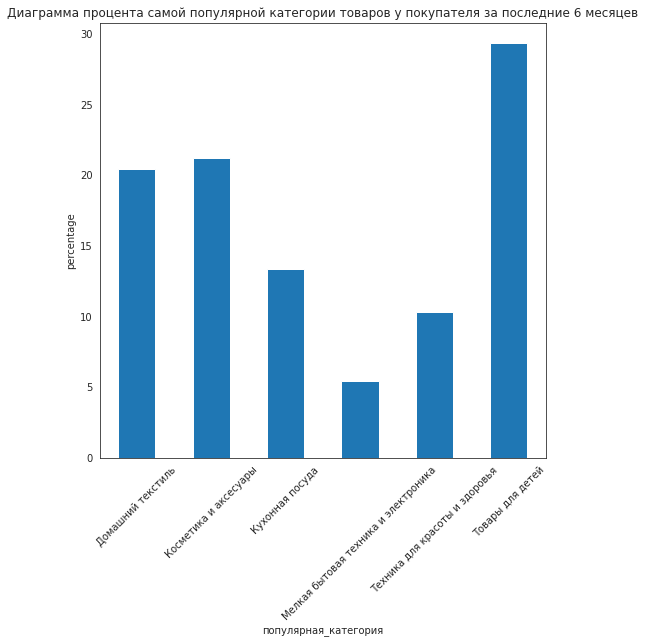

In [269]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента самой популярной категории товаров у покупателя за последние 6 месяцев'
      ).legend = False

Общее: По диаграмме видим что больше всего популярностью у покупателей пользуется Товары для детей(25.38%) по убыванию: Домашний текстиль(19.3%), Косметика и аксесуары(17.15%), Техника для красоты и здоровья(14.15%), Мелкая бытовая техника и электроника(13.38%), Кухонная посуда(10.61%)

Различие: Наблюдаем изменение в соотношении популярных категорий товаров. Товары для детей(29.31%) по убыванию: Косметика и аксесуары(21.08%), Домашний текстиль(20.48%), Кухонная посуда(13.25%), Техника для красоты и здоровья(10.44%), Мелкая бытовая техника и электроника(5.42%)

#### Cколько в среднем категорий покупатель просмотрел за визит

In [270]:
t = df_low.groupby('средний_просмотр_категорий_за_визит')['id'].count()
t = t/len(df_low) * 100
t

средний_просмотр_категорий_за_визит
1    16.969697
2    35.555556
3    26.868687
4    12.525253
5     5.050505
6     3.030303
Name: id, dtype: float64

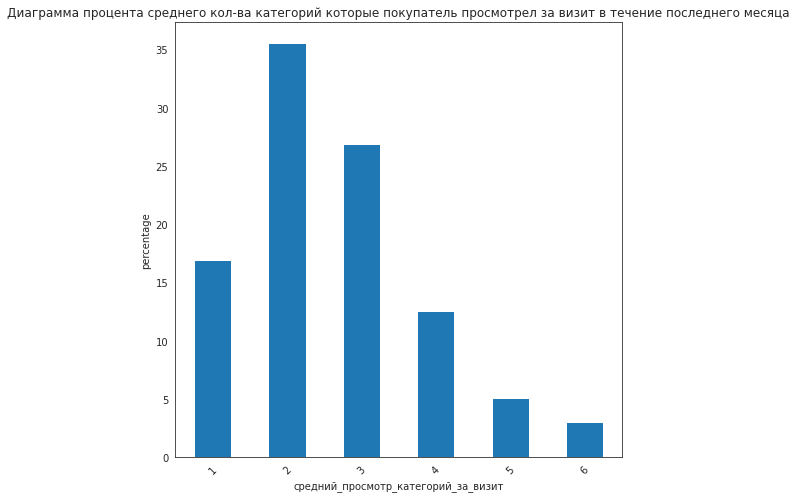

In [271]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента среднего кол-ва категорий которые покупатель просмотрел за визит в течение последнего месяца'
      ).legend = False

Общее: В среднем 3 категории просматривают (27.38%) пользователей за визит, 2 категории(24%), 4 категории(20.23%), 5 категорий(13.61%), 1 категорию(8.15%) и 6 категорий(6.61%). Напоминает нормальное распределение

Различие: Изменение в соотношении кол-ва категорий которые просматривает покупатель за визит. 2 категории(35.34%), 3 категории просматривают (27.9%) пользователей за визит, 1 категорию(16.86%), 4 категории(12.65%), 5 категорий(5.02%) и 6 категорий(3.21%)

#### Общее число неоплаченных товаров в корзине за 3 месяца

In [272]:
t = df_low.groupby('неоплаченные_продукты_штук_квартал')['id'].count()
t = t/len(df_low) * 100
t

неоплаченные_продукты_штук_квартал
0      5.858586
1     12.323232
2     16.363636
3     14.545455
4     15.151515
5     14.343434
6      8.282828
7      6.464646
8      3.838384
9      2.020202
10     0.808081
Name: id, dtype: float64

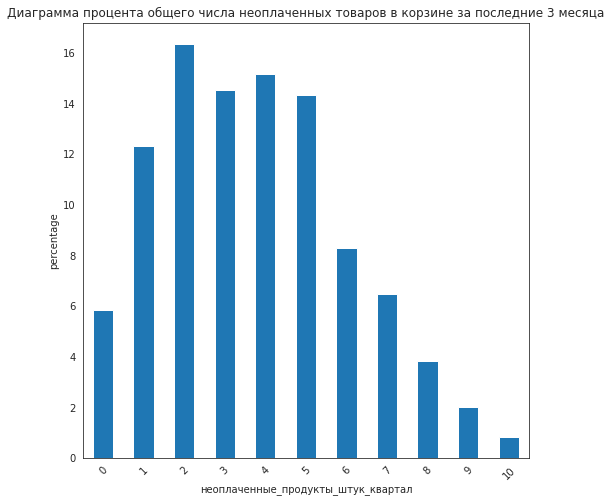

In [273]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента общего числа неоплаченных товаров в корзине за последние 3 месяца'
      ).legend = False

Общее: Большинство покупателей оставляют неоплаченными в корзине 1 (20.07%) и 2 (20.07%) товара, 3 товара (16.76%), 4 (15.15%), 5 (10.38%), 0 (8.92%), 6 (3.38%), 7 (2.61%), 8 (1.53%), 9 (0.76%) и меньше всего 10 (0.3%) товаров, напоминает распределение Пуассоа смещенное влево

Различие: Изменение в соотношении числа неоплаченных товаров в корзине. 2 (16.66%) и 4 (15.06%), 3 товара (14.65%), 5 (14.25%), 1 (12.24%), 6 (8.23%), 7 (6.42%), 0 (5.82%),8 (3.81%), 9 (2%)  и меньше всего 10 (0.8%) товаров

#### Число сбоев

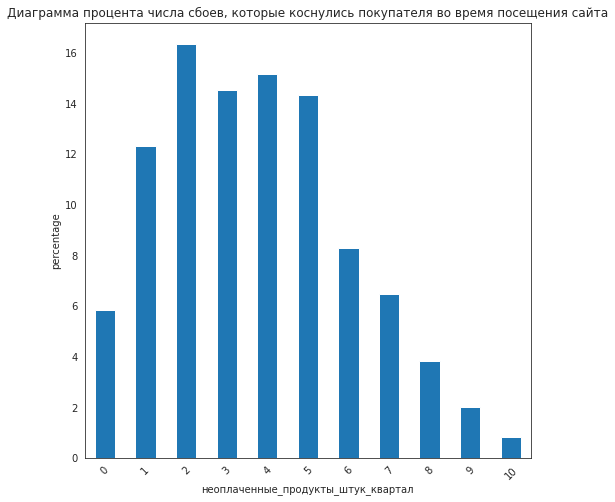

In [274]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента числа сбоев, которые коснулись покупателя во время посещения сайта'
      ).legend = False

In [275]:
t = df_low.groupby('ошибка_сервиса')['id'].count()
t = t/len(df_low) * 100
t

ошибка_сервиса
1     6.262626
2    19.393939
3    21.414141
4    18.787879
5    13.131313
6     8.686869
7     7.272727
8     4.646465
9     0.404040
Name: id, dtype: float64

Общее: Большинства покупателей преследует 4 (20.07%) сбоя, 3 сбоя(17.38%), 5 (16%), 2 (14.53%), 6 (12%), 7 (7.07%), 1 (5.69%), 8 (5.07%), 0 (1.3%) и 9 (1.15%) у меньше всего пользователей, напоминает нормальное распределение

Различие: Изменения в соотношении числа сбоев, которые коснулись покупателя во время посещения сайта. 3 сбоя(21.28%), 2 (19.27%), 4 (18.87%), 5 (13.05%), 6 (8.63%), 7 (7.22%), 1 (6.42%), 8 (4.61%) и 9 (0.6%) у меньше всего пользователей

#### Cреднее количество страниц за один визит на сайт

In [276]:
t = df_low.groupby('cтраниц_за_визит')['id'].count()
t = t/len(df_low) * 100
t

cтраниц_за_визит
1      4.040404
2     11.515152
3     13.737374
4     15.959596
5     15.757576
6     12.323232
7      7.474747
8      2.222222
9      3.030303
10     2.828283
11     3.232323
12     2.020202
13     1.616162
14     1.010101
15     1.010101
16     0.808081
17     1.212121
18     0.202020
Name: id, dtype: float64

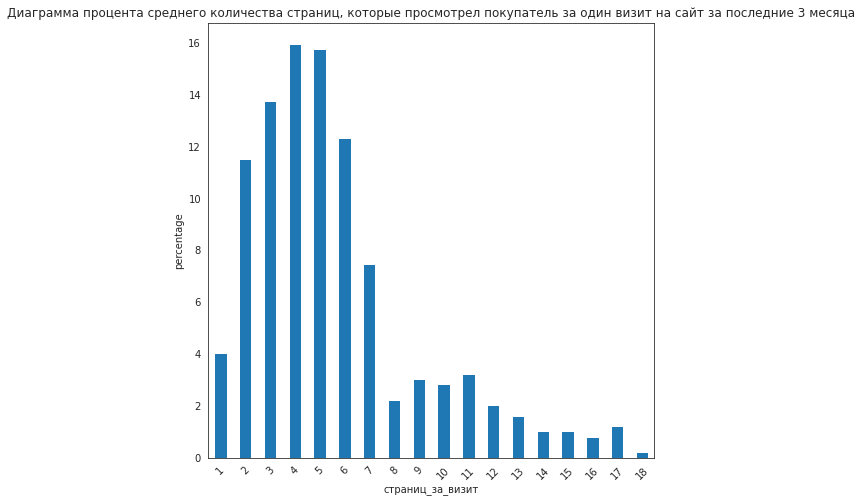

In [277]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца'
      ).legend = False

In [278]:
t.sort_values(ascending=False)

cтраниц_за_визит
4     15.959596
5     15.757576
3     13.737374
6     12.323232
2     11.515152
7      7.474747
1      4.040404
11     3.232323
9      3.030303
10     2.828283
8      2.222222
12     2.020202
13     1.616162
17     1.212121
14     1.010101
15     1.010101
16     0.808081
18     0.202020
Name: id, dtype: float64

Общее: Чаще всего покупатели посещают 6(9.76%) страниц за визит на сайт, (8.8-7%) пользователей посещают: 5, 4, 8, 9, 10, 7, 11 страниц соответственно; (5.8-4%) посещают: 3, 12, 13, 2, 14 страниц; меньше всего (2.7-0%) пользователей посещают: 15, 16, 1, 17, 18, 19, 20 страниц. Напоминает нормальное распределение со слегка выбивающиемся значениями 4, 5, 6 страниц за визит

Различие: Изменение в кол-ве посещенных страниц за один визит на сайт. Чаще всего покупатели посещают 5, 4, 3, 6, 2(16.06-11.64%) страниц за визит на сайт, (7.42-4.01%) пользователей посещают: 7, 1 страниц соответственно; (3.21-2%) посещают: 11, 9, 10, 8, 12 страниц; меньше всего (1.6-0%) пользователей посещают: 13, 17, 14, 15, 16, 18 страниц. Распределение поменялось на Пуассона со скосом влево

#### Cумма выручки за текущий месяц

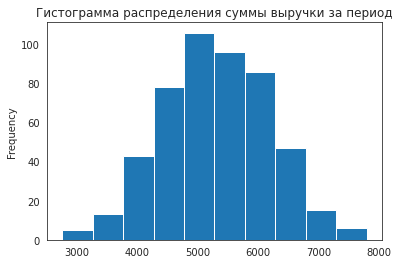

In [279]:
df_low['выручка_текущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения суммы выручки за период'
                                ).legend = False

In [280]:
df_low['выручка_текущий_месяц'].describe()

count     495.000000
mean     5306.133485
std       895.529583
min      2758.700000
25%      4651.250000
50%      5294.100000
75%      5956.650000
max      7799.400000
Name: выручка_текущий_месяц, dtype: float64

Пользователи с покупательской способностью: Гистограмма напомминает нормальное распределение, разброс выручки наблюдается от 2952 до 7547, в среднем выручка на пользователя с покупательской способностью за текущий месяц составляет 5197.7

Различие: Изменение в разбросе выручки текущего месяца от 2758 до 7799, ср. значение слегка сместилось 5302

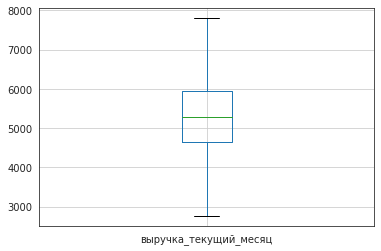

In [281]:
df_low.boxplot(column=['выручка_текущий_месяц']).legend = False

Пользователи с покупательской способностью: Наблюдаем слегка выбивающиеся значения

Различие: Аномальных значений не наблюдаем

#### Cумма выручки за предыдущий месяц

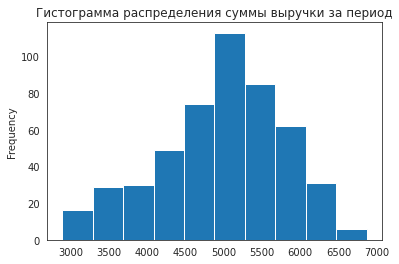

In [282]:
df_low['выручка_предыдущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения суммы выручки за период'
                                ).legend = False

In [283]:
df_low['выручка_предыдущий_месяц'].describe()

count     495.000000
mean     4973.907071
std       809.584804
min      2890.000000
25%      4487.000000
50%      5053.000000
75%      5547.000000
max      6869.500000
Name: выручка_предыдущий_месяц, dtype: float64

Пользователи с покупательской способностью: Гистограмма напомминает нормальное распределение чуть скошенное вправо,  разброс выручки наблюдается от 2970 до 6537, в среднем выручка на пользователя с покупательской способностью за предыдущий месяц составляет 4932

Различие: Изменение в разбросе выручки предыдущего месяца от 0 до 6869, ср. значение слегка сместилось 4943, на гистограмме есть 'хвост' из-за нулевых значений

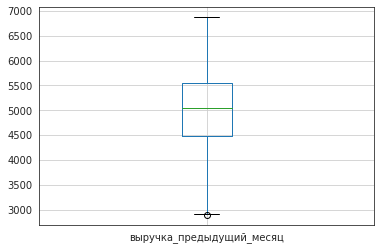

In [284]:
df_low.boxplot(column=['выручка_предыдущий_месяц']).legend = False

Пользователи с покупательской способностью: Значения находящиеся в левой части распределения слегка выбиваются из общей массы значений

Различие: Есть нулевые значения которые выбиваются из общей массы

#### Cумма выручки за препредыдущий месяц

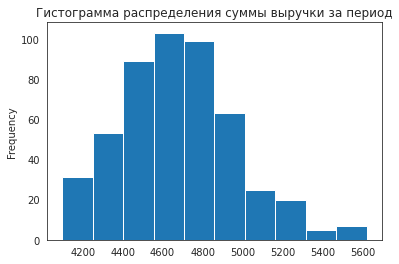

In [285]:
df_low['выручка_препредыдущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения суммы выручки за период'
                                ).legend = False

In [286]:
df_low['выручка_препредыдущий_месяц'].describe()

count     495.000000
mean     4679.034343
std       291.596507
min      4098.000000
25%      4467.500000
50%      4668.000000
75%      4849.500000
max      5621.000000
Name: выручка_препредыдущий_месяц, dtype: float64

Пользователи с покупательской способностью: Напоминает нормальное распределение со 'скосом' по левому краю, разброс выручки за препредыдущий месяц варьируется от 4338 до 5663, в среднем 4933

Различие: Изменение в разбросе выручки препредыдущего месяца от 0 до 5621, ср. значение сместилось 4650 на гистограмме есть 'хвост' из-за нулевых значений

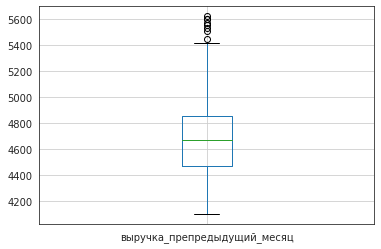

In [287]:
df_low.boxplot(column=['выручка_препредыдущий_месяц']).legend = False

Пользователи с покупательской способностью: Аномальных значений не наблюдаем

Различие: Есть нулевые значения которые выбиваются из общей массы и значения слегка выбивающиеся по правому краю

#### Значение времени за текущий месяц, проведённого на сайте, в минутах

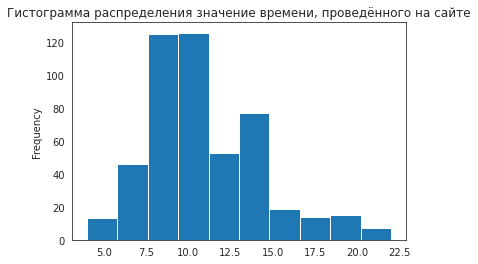

In [288]:
df_low['минут_текущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения значение времени, проведённого на сайте'
                                ).legend = False

In [289]:
df_low['минут_текущий_месяц'].describe()

count    495.000000
mean      10.953535
std        3.417605
min        4.000000
25%        9.000000
50%       10.000000
75%       13.000000
max       22.000000
Name: минут_текущий_месяц, dtype: float64

Пользователи с покупательской способностью: Нормальное распределение со 'скосом' к правому краю, разброс времени за текущий месяц: от 4 до 23, в среднем 14.6

Различие: распределение Пуассона со 'скосом' к левому краю, разброс времени за текущий месяц идентичный пользователям со стабилной покупательской активностью, среднее значение сместилось 10.94

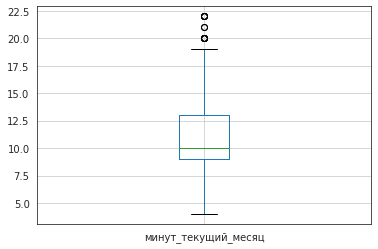

In [290]:
df_low.boxplot(column=['минут_текущий_месяц']).legend = False

Пользователи с покупательской способностью: Аномальных значений не наблюдаем

Различие: Несколько выбивающихся значений по правому краю

#### Значение времени за предыдущий месяц, проведённого на сайте, в минутах

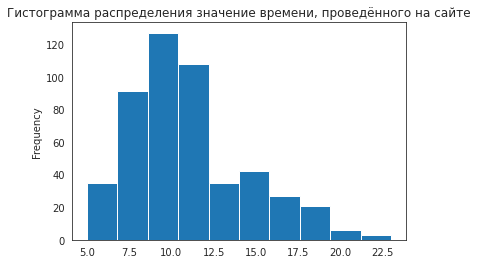

In [291]:
df_low['минут_предыдущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения значение времени, проведённого на сайте'
                                ).legend = False

In [292]:
df_low['минут_предыдущий_месяц'].describe()

count    495.000000
mean      10.941414
std        3.473235
min        5.000000
25%        8.000000
50%       10.000000
75%       13.000000
max       23.000000
Name: минут_предыдущий_месяц, dtype: float64

Пользователи с покупательской способностью: Напоминает нормальное распределение с 2-мя пиковыми значениями 13мин и 16 мин, разброс времени за предыдущий месяц варьируется от 7 до 23, в среднем 15

Различие: распределение Пуассона со 'скосом' к левому краю, разброс времени за предыдущий месяц от 5 до 23 минут, среднее значение сместилось 10.95

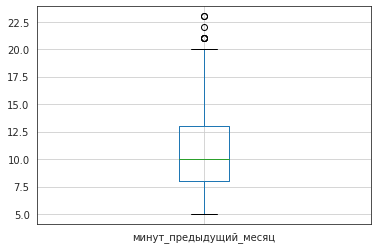

In [293]:
df_low.boxplot(column=['минут_предыдущий_месяц']).legend = False

Пользователи с покупательской способностью: Аномальных значений не наблюдаем

Различие: Несколько выбивающихся значений по правому краю

#### Вывод по анализу сегмента клиентов с низкой покупательской активностью:

Промежуточный вывод по анализу сегмента с низкой покупательской активностью:

-Меньше покупателей сервиса 'стандартного' уровня (65.86%) и больше покупателей 'премиум'(34.13%)

-Среднее значение маркет. активности за 6 месяцев отличается (3.74) как и медиана (3.9), гистограмма более 'нормализованна'

-Среднее значение акционных покупок весомо сместилось (0.45) 

-Изменение в соотношении популярных категорий товаров. Товары для детей(29.31%) по убыванию: Косметика и аксесуары(21.08%), Домашний текстиль(20.48%), Кухонная посуда(13.25%), Техника для красоты и здоровья(10.44%), Мелкая бытовая техника и электроника(5.42%)

-Изменение в соотношении кол-ва категорий которые просматривает покупатель за визит. 2 категории(35.34%), 3 категории просматривают (27.9%) пользователей за визит, 1 категорию(16.86%), 4 категории(12.65%), 5 категорий(5.02%) и 6 категорий(3.21%)

-Изменение в соотношении числа неоплаченных товаров в корзине. 2 (16.66%) и 4 (15.06%), 3 товара (14.65%), 5 (14.25%), 1 (12.24%), 6 (8.23%), 7 (6.42%), 0 (5.82%),8 (3.81%), 9 (2%) и меньше всего 10 (0.8%) товаров

-Изменения в соотношении числа сбоев, которые коснулись покупателя во время посещения сайта. 3 сбоя(21.28%), 2 (19.27%), 4 (18.87%), 5 (13.05%), 6 (8.63%), 7 (7.22%), 1 (6.42%), 8 (4.61%) и 9 (0.6%) у меньше всего пользователей

-Изменение в кол-ве посещенных страниц за один визит на сайт. Чаще всего покупатели посещают 5, 4, 3, 6, 2(16.06-11.64%) страниц за визит на сайт, (7.42-4.01%) пользователей посещают: 7, 1 страниц соответственно; (3.21-2%) посещают: 11, 9, 10, 8, 12 страниц; меньше всего (1.6-0%) пользователей посещают: 13, 17, 14, 15, 16, 18 страниц. Распределение поменялось на Пуассона со скосом влево

Проведенно сравнение распределения выручки (за текущий, предыдущий, препредыдущий месяц) и времени (за текущий, предыдущий месяц), проведенного на сайте для пользователей с покупательской способностью и пользователей с низкой покупательской способностью:

-Изменение в разбросе выручки текущего месяца от 2758 до 7799, ср. значение слегка сместилось 5302

-Изменение в разбросе выручки предыдущего месяца от 0 до 6869, ср. значение слегка сместилось 4943, на гистограмме есть 'хвост' из-за нулевых значений

-Изменение в разбросе выручки препредыдущего месяца от 0 до 5621, ср. значение сместилось 4650 на гистограмме есть 'хвост' из-за нулевых значений

-Изменилось распределение на Пуассона со 'скосом' к левому краю, разброс времени за текущий месяц идентичный пользователям со стабилной покупательской активностью, среднее значение сместилось 10.94

-Изменилось распределение на Пуассона со 'скосом' к левому краю, разброс времени за предыдущий месяц от 5 до 23 минут, среднее значение сместилось 10.95

### Сегмент покупателей товаров с длинным жизненным циклом

#### Выделение сегмента

Получение сегмента покупателей с длинным жизненным циклом

In [294]:
df_long =  df[(df['покупательская_активность'] == 'Снизилась'
   ) & ((df['популярная_категория'] == 'Домашний текстиль'
        ) | (df['популярная_категория'] == 'Техника для красоты и здоровья'
            ) | (df['популярная_категория'] == 'Мелкая бытовая техника и электроника'))]
df_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 2 to 593
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   179 non-null    int64  
 1   покупательская_активность            179 non-null    object 
 2   тип_сервиса                          179 non-null    object 
 3   разрешить_сообщать                   179 non-null    object 
 4   маркет_актив_6_мес                   179 non-null    float64
 5   маркет_актив_тек_мес                 179 non-null    int64  
 6   длительность                         179 non-null    int64  
 7   акционные_покупки                    179 non-null    float64
 8   популярная_категория                 179 non-null    object 
 9   средний_просмотр_категорий_за_визит  179 non-null    int64  
 10  неоплаченные_продукты_штук_квартал   179 non-null    int64  
 11  ошибка_сервиса                  

#### Уровень сервиса

In [295]:
t = df_long.groupby('тип_сервиса')['id'].count()
t = t/len(df_long) * 100
t

тип_сервиса
премиум     31.284916
стандарт    68.715084
Name: id, dtype: float64

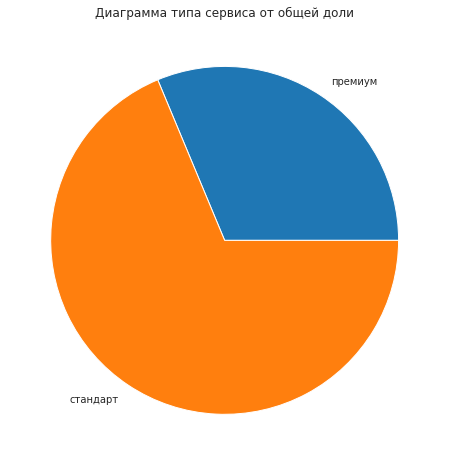

In [296]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма типа сервиса от общей доли').legend = False

Общее: У большинства покупателей сервис 'стандартного' уровня (71.07%) у меньшего числа покупателей 'премиум' (28.92%)

Различие: Меньше покупателей сервиса 'стандартного' уровня (68.81%) и больше покупателей 'премиум'(31.28%)

#### Информация о том, можно ли присылать покупателю дополнительные предложения о товаре

In [297]:
t = df_long.groupby('разрешить_сообщать')['id'].count()
t = t/len(df_long) * 100
t

разрешить_сообщать
да     75.418994
нет    24.581006
Name: id, dtype: float64

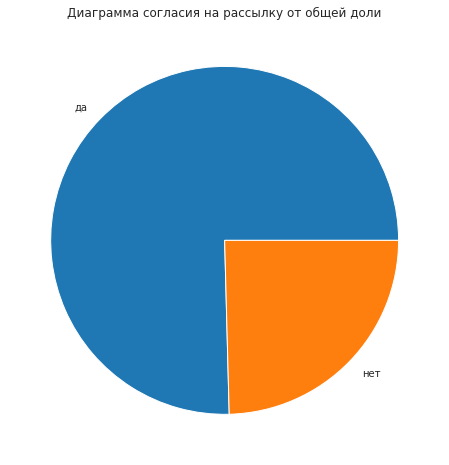

In [298]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма согласия на рассылку от общей доли').legend = False

Общее: Большинства покупателей дали согласие на рассылку (74%), меньшинство отказалось (26%)

Различие: Соотношение незначительно поменялось покупателей дали согласие на рассылку (75.41%), отказалось (24.58%)

#### Cр.месячное значение маркетинговых коммуникаций компании,  на покупателя за 6 месяцев

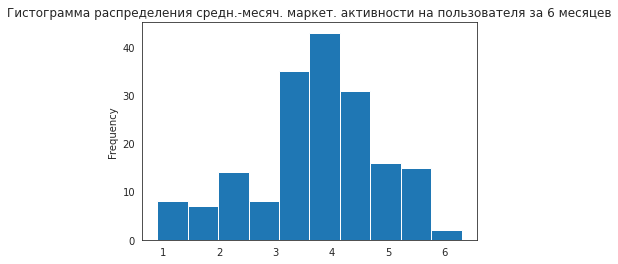

In [299]:
df_long['маркет_актив_6_мес'].plot(kind='hist',
                                 title = 'Гистограмма распределения средн.-месяч. маркет. активности на пользователя за 6 месяцев'
                                ).legend = False

In [300]:
df_long['маркет_актив_6_мес'].describe()

count    179.000000
mean       3.756983
std        1.135432
min        0.900000
25%        3.300000
50%        3.900000
75%        4.400000
max        6.300000
Name: маркет_актив_6_мес, dtype: float64

Общее: Гистограмма напомминает нормальное распределение чуть скошенное вправо, разброс наблюдается от 0.9 до 6.6, в среднем на покупателя 4.25 коммуникации, медианное значение слегка отличается (4.2) от среднего из-за 'скоса вправо'

Различие: Среднее значение отличается (3.75) как и медиана (3.9), гистограмма более 'нормализованна'

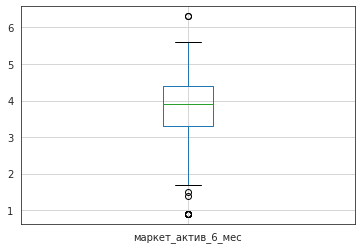

In [301]:
df_long.boxplot(column=['маркет_актив_6_мес']).legend = False

Общее: Наблюдаем выход некоторых значений за границы межквартильного размаха, не столь экстремальные чтобы делать с ними что-то, вероятнее всего данные соответствуют реальности

Различие: аналогично

#### Количество маркетинговых коммуникаций в текущем месяце

In [302]:
t = df_long.groupby('маркет_актив_тек_мес')['id'].count()
t = t/len(df_long) * 100
t

маркет_актив_тек_мес
3    25.139665
4    51.396648
5    23.463687
Name: id, dtype: float64

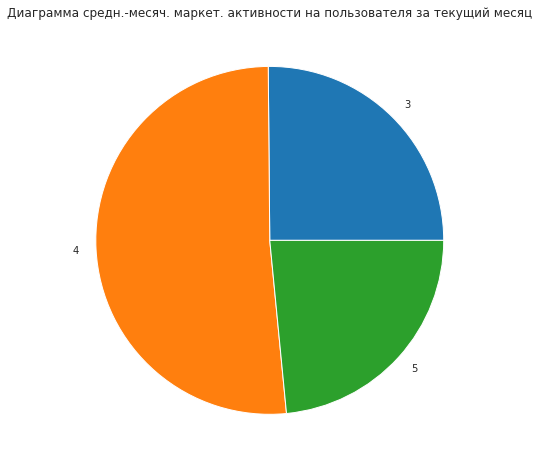

In [303]:
t.plot(kind='pie', rot=45,figsize = [8, 8], ylabel='',
       title = 'Диаграмма средн.-месяч. маркет. активности на пользователя за текущий месяц').legend = False

Общее: Большинство покупателей сталкиваются с 4-мя коммуникациями за месяц (51.46%), меньше покупателей сталкиваются с 5 коммуникациями (24.84%) и с 3 сталкиваются (23.69%) пользователей

Различие: Соотношение слегка отличается 4-мя(51.39%), 5(23.46%) и 3-мя(25.13%)

#### Cколько дней прошло с момента регистрации

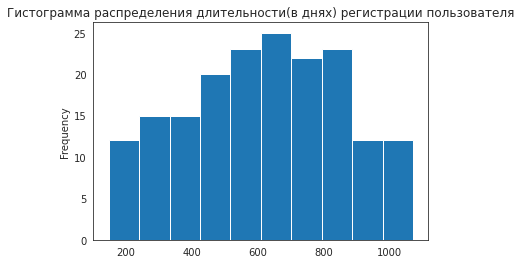

In [304]:
df_long['длительность'].plot(kind='hist',
                                 title = 'Гистограмма распределения длительности(в днях) регистрации пользователя'
                                ).legend = False

In [305]:
df_long['длительность'].describe()

count     179.000000
mean      616.050279
std       236.929807
min       147.000000
25%       448.000000
50%       627.000000
75%       802.500000
max      1072.000000
Name: длительность, dtype: float64

Общее: Гистограмма напоминает нормальное распределение, разброс дней варьируется от 110 до 1079, в среднем 601 дней прошло с момента регистрации покупателя

Различие: Незначительно поменялось ср.значение 616 и разброс от 147 до 1072

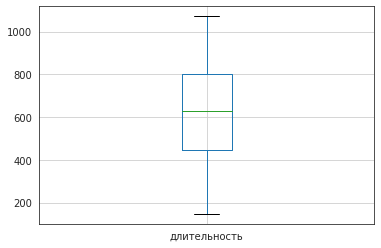

In [306]:
df_long.boxplot(column=['длительность']).legend = False

Общее: Аномальных значений не наблюдаем

Различие: аналогично

#### Ср.месячная доля покупок по акции

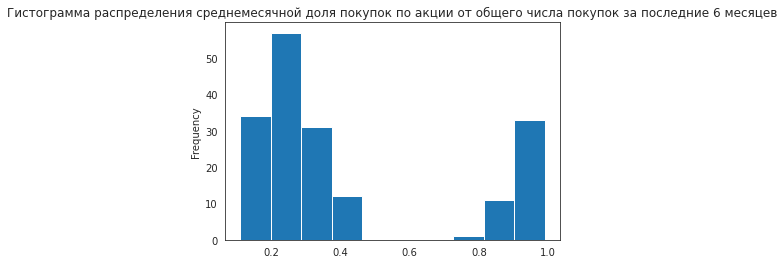

In [307]:
df_long['акционные_покупки'].plot(kind='hist',
                                 title = 'Гистограмма распределения среднемесячной доля покупок по акции от общего числа покупок за последние 6 месяцев'
                                ).legend = False

In [308]:
df_long['акционные_покупки'].describe()

count    179.000000
mean       0.421453
std        0.307936
min        0.110000
25%        0.220000
50%        0.280000
75%        0.570000
max        0.990000
Name: акционные_покупки, dtype: float64

Общее: Напоминает распределение Пуасона со 'скосом' к левому краю с провалом на значениях ~0.5-0.8 разброс доли покупок варьируется от 0 до 0.99, в среднем 0.31

Различие: Среднее значение весомо сместилось (0.42) 

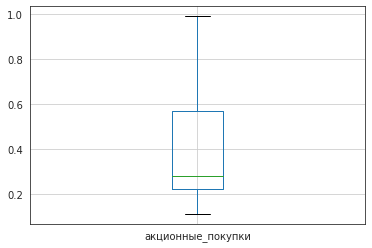

In [309]:
df_long.boxplot(column=['акционные_покупки']).legend = False

Общее: Значения находящиеся в правой части слегка выбиваются из общей массы значений, не будем принимать эти значения аномалльными т.к. они похоже на истинные

Различие: Аномальных значений не наблюдаем

####  Cамая популярная категория товаров

In [310]:
t = df_long.groupby('популярная_категория')['id'].count()
t = t/len(df_long) * 100
t

популярная_категория
Домашний текстиль                       56.424581
Мелкая бытовая техника и электроника    15.083799
Техника для красоты и здоровья          28.491620
Name: id, dtype: float64

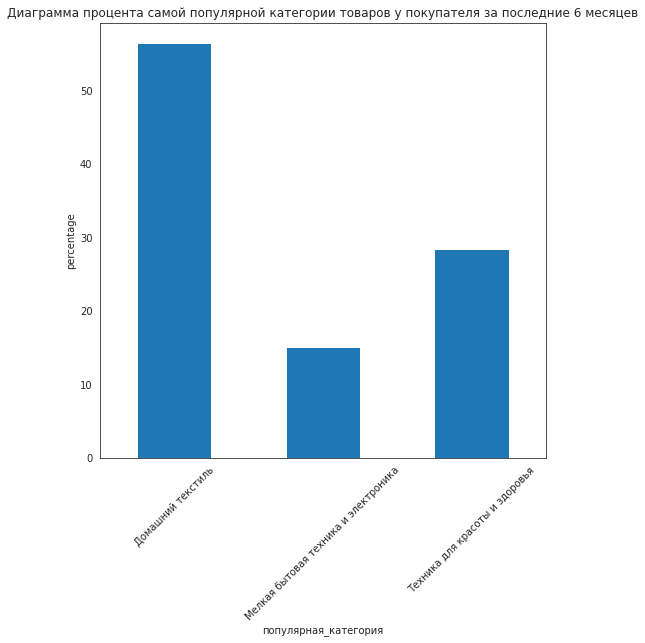

In [311]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента самой популярной категории товаров у покупателя за последние 6 месяцев'
      ).legend = False

Общее: По диаграмме видим что больше всего популярностью у покупателей пользуется Товары для детей(25.38%) по убыванию: Домашний текстиль(19.3%), Косметика и аксесуары(17.15%), Техника для красоты и здоровья(14.15%), Мелкая бытовая техника и электроника(13.38%), Кухонная посуда(10.61%)

Различие: Наблюдаем изменение в соотношении популярных категорий товаров. Домашний текстиль(56.42%) по убыванию: Техника для красоты и здоровья(28.49%), Мелкая бытовая техника и электроника(15.08%)

#### Cколько в среднем категорий покупатель просмотрел за визит

In [312]:
t = df_long.groupby('средний_просмотр_категорий_за_визит')['id'].count()
t = t/len(df_long) * 100
t

средний_просмотр_категорий_за_визит
1    17.318436
2    35.754190
3    22.905028
4    12.849162
5     6.145251
6     5.027933
Name: id, dtype: float64

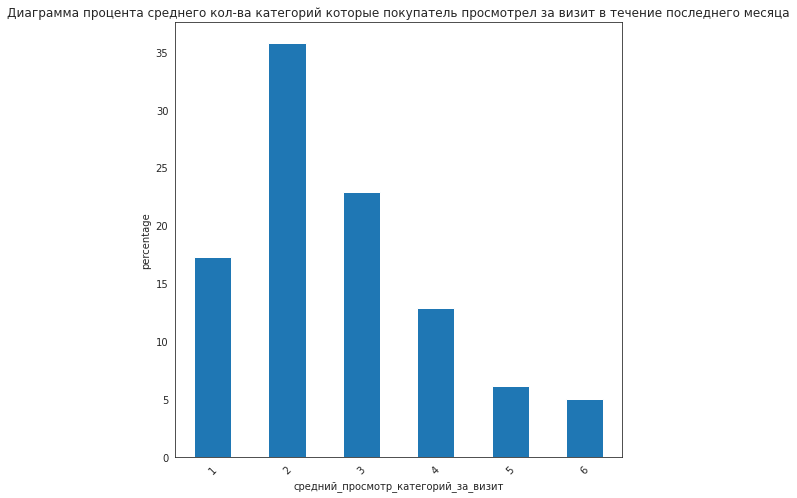

In [313]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента среднего кол-ва категорий которые покупатель просмотрел за визит в течение последнего месяца'
      ).legend = False

Общее: В среднем 3 категории просматривают (27.38%) пользователей за визит, 2 категории(24%), 4 категории(20.23%), 5 категорий(13.61%), 1 категорию(8.15%) и 6 категорий(6.61%). Напоминает нормальное распределение

Различие: Изменение в соотношении кол-ва категорий которые просматривает покупатель за визит. 2 категории(35.75%), 3 категории просматривают (22.9%) пользователей за визит, 1 категорию(17.31%), 4 категории(12.84%), 5 категорий(6.14%) и 6 категорий(5.02%)

#### Общее число неоплаченных товаров в корзине за 3 месяца

In [314]:
t = df_long.groupby('неоплаченные_продукты_штук_квартал')['id'].count()
t = t/len(df_long) * 100
t

неоплаченные_продукты_штук_квартал
0      2.793296
1     16.201117
2     15.642458
3     16.201117
4     14.525140
5     11.731844
6      6.145251
7      9.497207
8      2.793296
9      2.234637
10     2.234637
Name: id, dtype: float64

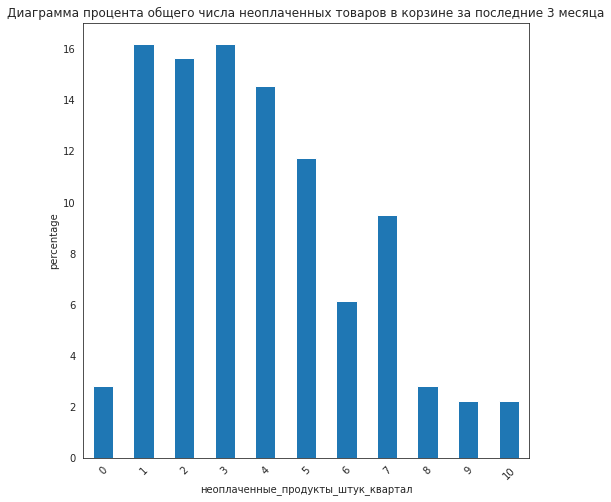

In [315]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента общего числа неоплаченных товаров в корзине за последние 3 месяца'
      ).legend = False

Общее: Большинство покупателей оставляют неоплаченными в корзине 1 (20.07%) и 2 (20.07%) товара, 3 товара (16.76%), 4 (15.15%), 5 (10.38%), 0 (8.92%), 6 (3.38%), 7 (2.61%), 8 (1.53%), 9 (0.76%) и меньше всего 10 (0.3%) товаров, напоминает распределение Пуассоа смещенное влево

Различие: Изменение в соотношении числа неоплаченных товаров в корзине. 2 (15.64%) и 4 (14.52%), 3 товара (16.2%), 5 (11.73%), 1 (16.2%), 6 (6.14%), 7 (9.49%), 0 (2.79%),8 (2.79%), 9 (2.23%)  и меньше всего 10 (2.23%) товаров

#### Число сбоев

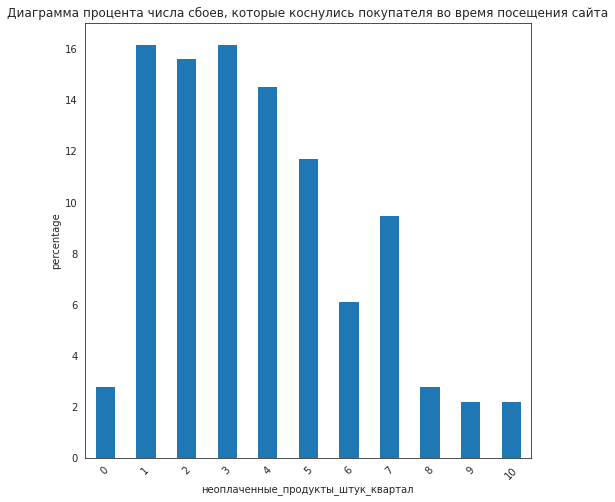

In [316]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента числа сбоев, которые коснулись покупателя во время посещения сайта'
      ).legend = False

In [317]:
t = df_long.groupby('ошибка_сервиса')['id'].count()
t = t/len(df_long) * 100
t

ошибка_сервиса
1     3.910615
2    22.905028
3    21.229050
4    16.759777
5    12.290503
6     9.497207
7     6.703911
8     6.145251
9     0.558659
Name: id, dtype: float64

Общее: Большинства покупателей преследует 4 (20.07%) сбоя, 3 сбоя(17.38%), 5 (16%), 2 (14.53%), 6 (12%), 7 (7.07%), 1 (5.69%), 8 (5.07%), 0 (1.3%) и 9 (1.15%) у меньше всего пользователей, напоминает нормальное распределение

Различие: Изменения в соотношении числа сбоев, которые коснулись покупателя во время посещения сайта. 3 сбоя(21.22%), 2 (22.9%), 4 (16.75%), 5 (12.29%), 6 (9.49%), 7 (6.7%), 1 (3.91%), 8 (6.14%) и 9 (0.55%) у меньше всего пользователей

#### Cреднее количество страниц за один визит на сайт

In [318]:
t = df_long.groupby('cтраниц_за_визит')['id'].count()
t = t/len(df_long) * 100
t

cтраниц_за_визит
1      3.351955
2      7.821229
3     15.083799
4     16.201117
5     15.642458
6     11.173184
7      7.821229
8      1.117318
9      2.793296
10     6.145251
11     2.793296
12     2.793296
13     2.234637
14     0.558659
15     1.117318
16     1.117318
17     1.675978
18     0.558659
Name: id, dtype: float64

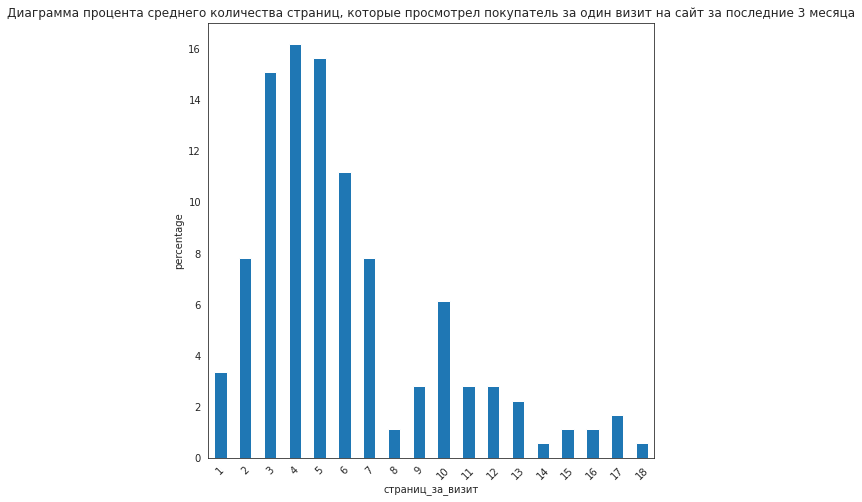

In [319]:
t.plot(kind='bar', rot=45,
       figsize = [8,8], ylabel='percentage', title = 'Диаграмма процента среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца'
      ).legend = False

In [320]:
t.sort_values(ascending=False)

cтраниц_за_визит
4     16.201117
5     15.642458
3     15.083799
6     11.173184
2      7.821229
7      7.821229
10     6.145251
1      3.351955
9      2.793296
11     2.793296
12     2.793296
13     2.234637
17     1.675978
8      1.117318
15     1.117318
16     1.117318
14     0.558659
18     0.558659
Name: id, dtype: float64

Общее: Чаще всего покупатели посещают 6(9.76%) страниц за визит на сайт, (8.8-7%) пользователей посещают: 5, 4, 8, 9, 10, 7, 11 страниц соответственно; (5.8-4%) посещают: 3, 12, 13, 2, 14 страниц; меньше всего (2.7-0%) пользователей посещают: 15, 16, 1, 17, 18, 19, 20 страниц. Напоминает нормальное распределение со слегка выбивающиемся значениями 4, 5, 6 страниц за визит

Различие: Изменение в кол-ве посещенных страниц за один визит на сайт. Чаще всего покупатели посещают 4, 5, 3, 6 (16.2-11.17%) страниц за визит на сайт, (7.82-6.14%) пользователей посещают: 2, 7, 10 страниц соответственно; (3.35-2.23%) посещают: 1, 9, 11, 12, 13 страниц; меньше всего (1.67-0%) пользователей посещают: 17, 8, 15, 16, 14, 18 страниц. Распределение поменялось на Пуассона со скосом влево

#### Cумма выручки за текущий месяц

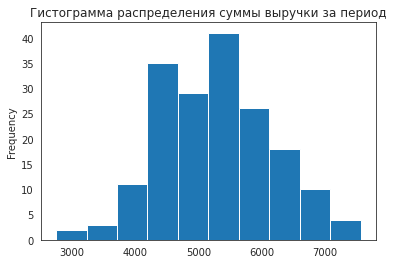

In [321]:
df_long['выручка_текущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения суммы выручки за период'
                                ).legend = False

In [322]:
df_long['выручка_текущий_месяц'].describe()

count     179.000000
mean     5269.450698
std       877.733368
min      2758.700000
25%      4605.950000
50%      5202.600000
75%      5865.100000
max      7557.000000
Name: выручка_текущий_месяц, dtype: float64

Пользователи с покупательской способностью: Гистограмма напомминает нормальное распределение, разброс выручки наблюдается от 2952 до 7547, в среднем выручка на пользователя с покупательской способностью за текущий месяц составляет 5197.7

Различие: Изменение в разбросе выручки текущего месяца от 2758 до 7557, ср. значение слегка сместилось 5269

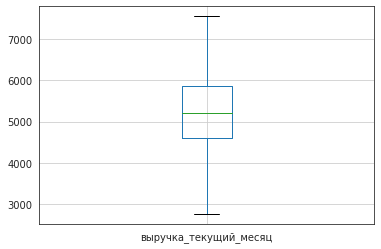

In [323]:
df_long.boxplot(column=['выручка_текущий_месяц']).legend = False

Пользователи с покупательской способностью: Наблюдаем слегка выбивающиеся значения

Различие: Аномальных значений не наблюдаем

#### Cумма выручки за предыдущий месяц

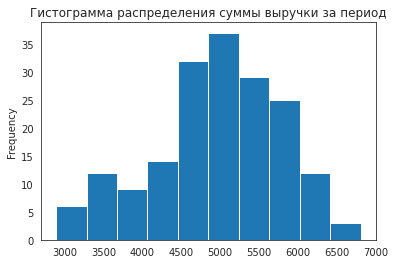

In [324]:
df_long['выручка_предыдущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения суммы выручки за период'
                                ).legend = False

In [325]:
df_long['выручка_предыдущий_месяц'].describe()

count     179.000000
mean     4961.455307
std       824.711552
min      2890.000000
25%      4502.000000
50%      5035.000000
75%      5548.250000
max      6809.000000
Name: выручка_предыдущий_месяц, dtype: float64

Пользователи с покупательской способностью: Гистограмма напомминает нормальное распределение чуть скошенное вправо,  разброс выручки наблюдается от 2970 до 6537, в среднем выручка на пользователя с покупательской способностью за предыдущий месяц составляет 4932

Различие: Изменение в разбросе выручки предыдущего месяца от 2890 до 6809, ср. значение слегка сместилось 4961

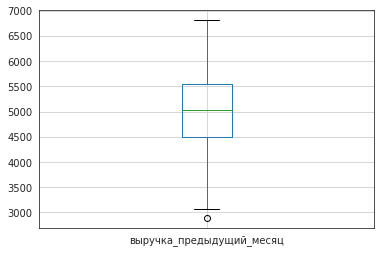

In [326]:
df_long.boxplot(column=['выручка_предыдущий_месяц']).legend = False

Пользователи с покупательской способностью: Значения находящиеся в левой части распределения слегка выбиваются из общей массы значений

Различие: Аномальных значений не наблюдаем

#### Cумма выручки за препредыдущий месяц

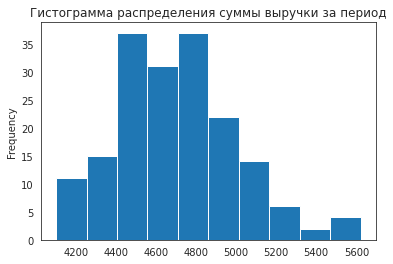

In [327]:
df_long['выручка_препредыдущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения суммы выручки за период'
                                ).legend = False

In [328]:
df_long['выручка_препредыдущий_месяц'].describe()

count     179.000000
mean     4699.497207
std       305.295314
min      4102.000000
25%      4483.000000
50%      4692.000000
75%      4881.500000
max      5621.000000
Name: выручка_препредыдущий_месяц, dtype: float64

Пользователи с покупательской способностью: Напоминает нормальное распределение со 'скосом' по левому краю, разброс выручки за препредыдущий месяц варьируется от 4338 до 5663, в среднем 4933

Различие: Изменение в разбросе выручки препредыдущего месяца от 4102 до 5621, ср. значение сместилось 4699

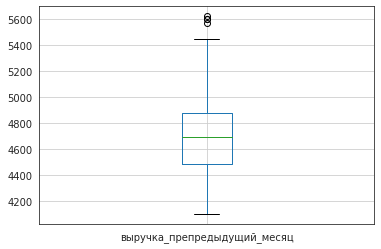

In [329]:
df_long.boxplot(column=['выручка_препредыдущий_месяц']).legend = False

Пользователи с покупательской способностью: Аномальных значений не наблюдаем

Различие: Есть значения слегка выбивающиеся по правому краю

#### Значение времени за текущий месяц, проведённого на сайте, в минутах

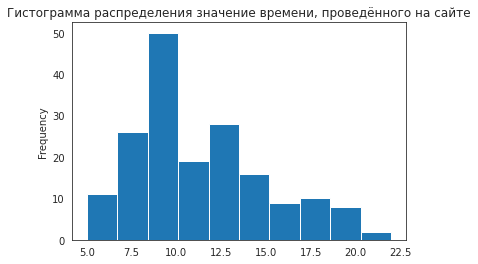

In [330]:
df_long['минут_текущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения значение времени, проведённого на сайте'
                                ).legend = False

In [331]:
df_long['минут_текущий_месяц'].describe()

count    179.000000
mean      11.458101
std        3.686017
min        5.000000
25%        9.000000
50%       11.000000
75%       13.500000
max       22.000000
Name: минут_текущий_месяц, dtype: float64

Пользователи с покупательской способностью: Нормальное распределение со 'скосом' к правому краю, разброс времени за текущий месяц: от 4 до 23, в среднем 14.6

Различие: распределение Пуассона со 'скосом' к левому краю, разброс времени за текущий месяц немного сместился от 5 до 22, среднее значение сместилось 11.45

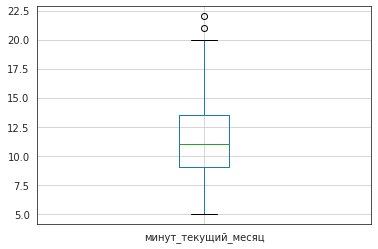

In [332]:
df_long.boxplot(column=['минут_текущий_месяц']).legend = False

Пользователи с покупательской способностью: Аномальных значений не наблюдаем

Различие: Несколько выбивающихся значений по правому краю

#### Значение времени за предыдущий месяц, проведённого на сайте, в минутах

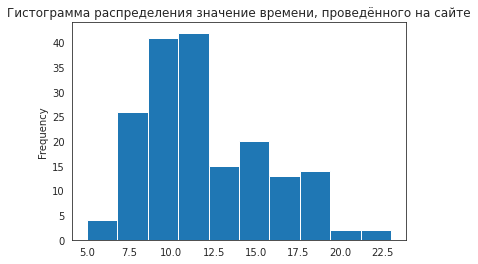

In [333]:
df_long['минут_предыдущий_месяц'].plot(kind='hist',
                                 title = 'Гистограмма распределения значение времени, проведённого на сайте'
                                ).legend = False

In [334]:
df_long['минут_предыдущий_месяц'].describe()

count    179.000000
mean      11.927374
std        3.552223
min        5.000000
25%        9.000000
50%       11.000000
75%       14.000000
max       23.000000
Name: минут_предыдущий_месяц, dtype: float64

Пользователи с покупательской способностью: Напоминает нормальное распределение с 2-мя пиковыми значениями 13мин и 16 мин, разброс времени за предыдущий месяц варьируется от 7 до 23, в среднем 15

Различие: распределение Пуассона со 'скосом' к левому краю, разброс времени за предыдущий месяц от 5 до 23 минут, среднее значение сместилось 10.92

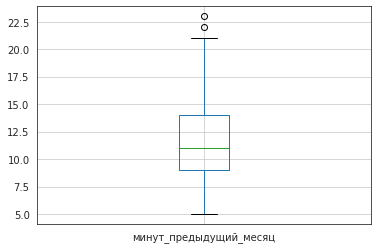

In [335]:
df_long.boxplot(column=['минут_предыдущий_месяц']).legend = False

Пользователи с покупательской способностью: Аномальных значений не наблюдаем

Различие: Несколько выбивающихся значений по правому краю

Промежуточный вывод по анализу сегмента покупателей с низкой покупательской активностью и предпочтением товаров с длинным жизненным циклом:

-Меньше покупателей сервиса 'стандартного' уровня (68.81%) и больше покупателей 'премиум'(31.28%)

-Среднее значение маркет. активности за 6 месяцев отличается (3.75) как и медиана (3.9), гистограмма более 'нормализованна'

-Среднее значение акционных покупок весомо сместилось (0.42) 

-Изменение в соотношении популярных категорий товаров. Домашний текстиль(56.42%) по убыванию: Техника для красоты и здоровья(28.49%), Мелкая бытовая техника и электроника(15.08%)

-Изменение в соотношении кол-ва категорий которые просматривает покупатель за визит. 2 категории(35.75%), 3 категории просматривают (22.9%) пользователей за визит, 1 категорию(17.31%), 4 категории(12.84%), 5 категорий(6.14%) и 6 категорий(5.02%)

-Изменение в соотношении числа неоплаченных товаров в корзине. 2 (15.64%) и 4 (14.52%), 3 товара (16.2%), 5 (11.73%), 1 (16.2%), 6 (6.14%), 7 (9.49%), 0 (2.79%),8 (2.79%), 9 (2.23%) и меньше всего 10 (2.23%) товаров

-Изменения в соотношении числа сбоев, которые коснулись покупателя во время посещения сайта. 3 сбоя(21.22%), 2 (22.9%), 4 (16.75%), 5 (12.29%), 6 (9.49%), 7 (6.7%), 1 (3.91%), 8 (6.14%) и 9 (0.55%) у меньше всего пользователей

-Изменение в кол-ве посещенных страниц за один визит на сайт. Чаще всего покупатели посещают  4, 5, 3, 6 (16.2-11.17%) страниц за визит на сайт, (7.82-6.14%) пользователей посещают: 2, 7, 10 страниц соответственно; (3.35-2.23%) посещают: 1, 9, 11, 12, 13 страниц; меньше всего (1.67-0%) пользователей посещают: 17, 8, 15, 16, 14, 18 страниц. Распределение поменялось на Пуассона со скосом влево

Проведенно сравнение распределения выручки (за текущий, предыдущий, препредыдущий месяц) и времени (за текущий, предыдущий месяц), проведенного на сайте для пользователей с покупательской способностью и пользователей с низкой покупательской способностью и предпочтением товаров с длинным жизненным циклом:

-Изменение в разбросе выручки текущего месяца от 2758 до 7557, ср. значение слегка сместилось 5269

-Изменение в разбросе выручки предыдущего месяца от 2890 до 6809, ср. значение слегка сместилось 4961

-Изменение в разбросе выручки препредыдущего месяца от 4102 до 5621, ср. значение сместилось 4699

-Изменилось распределение Пуассона со 'скосом' к левому краю, разброс времени за текущий месяц немного сместился от 5 до 22, среднее значение сместилось 11.45

-Изменилось распределение Пуассона со 'скосом' к левому краю, разброс времени за предыдущий месяц от 5 до 23 минут, среднее значение сместилось 10.92

### Общий вывод

В проделанной работе есть промежуточные выводы, в общем выводе я бы хотел обобщить их и подвести итог по работе с данными

<h4>Загрузка данных</h4>

**Данные представленны в 4 файлах:**

-В первой таблице 4 колонки типа object: покупательская_активность, тип_сервиса, разрешить_сообщать, популярная_категория;

7 колонок типа int: id, маркет_актив_тек_мес, длительность, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, ошибка_сервиса, cтраниц_за_визит

2 колонки типа float: маркет_актив_6_мес, акционные_покупки

-Во второй таблице колонка типа object (период), колонка типа int (id) и колонка типа float (выручка)

-В третьей таблице колонка типа object (период) и  2 колонки типа int (id, минут)

-В четвертой таблице колонка типа float (прибыль) и колонка типа int (id)

Была проделанна работа по приведению названия колонок к единому формату

<h4>Предобработка данных</h4>

Была проведена проверка на наличе пропусков в данных, пропусков не обнаружилось

Явных дубликатов в данных не обнаружилось

Была проведена работа по приведению значений категориальной переменной df_mf к единому формату (тип_сервиса), дубликатов не появилось

Прибыль приведена в корректный масштаб

Типы данных в фреймах представленны корректно

<h4>Исследовательский анализ данных</h4>

-большинство покупателей находятся на 'Прежнем уровне' (61.69%) у меньшего числа покупательская активность 'Снизилась' (38.3%)

-У большинства покупателей сервис 'стандартного' уровня (71.07%) у меньшего числа покупателей 'премиум' (28.92%)

-Большинства покупателей дали согласие на рассылку (74%), меньшинство отказалось (26%)

-Распределение ср.месячного значения маркетинговых коммуникаций компании,  на покупателя за 6 месяцев напомминает нормальное, чуть скошенное вправо, разброс наблюдается от 0.9 до 6.6, в среднем на покупателя 4.25 коммуникации, медианное значение слегка отличается (4.2) от среднего из-за 'скоса вправо'

-Большинство покупателей сталкиваются с 4-мя коммуникациями за месяц (51.46%), меньше покупателей сталкиваются с 5 коммуникациями (24.84%) и с 3 сталкиваются (23.69%) пользователей

-Распределение длительности(в днях) регистрации пользователя напоминает нормальное, разброс дней варьируется от 110 до 1079, в среднем 601 дней прошло с момента регистрации покупателя

-Распределение ср.месячная доля покупок по акции напоминает распределение Пуасона со 'скосом' к левому краю с провалом на значениях ~0.5-0.8 разброс доли покупок варьируется от 0 до 0.99, в среднем 0.31

-Больше всего популярностью у покупателей пользуется Товары для детей(25.38%) по убыванию: Домашний текстиль(19.3%), Косметика и аксесуары(17.15%), Техника для красоты и здоровья(14.15%), Мелкая бытовая техника и электроника(13.38%), Кухонная посуда(10.61%)

-В среднем 3 категории просматривают (27.38%) пользователей за визит, 2 категории(24%), 4 категории(20.23%), 5 категорий(13.61%), 1 категорию(8.15%) и 6 категорий(6.61%). Напоминает нормальное распределение

-Большинство покупателей оставляют неоплаченными в корзине 1 (20.07%) и 2 (20.07%) товара, 3 товара (16.76%), 4 (15.15%), 5 (10.38%), 0 (8.92%), 6 (3.38%), 7 (2.61%), 8 (1.53%), 9 (0.76%) и меньше всего 10 (0.3%) товаров, напоминает распределение Пуассоа смещенное влево

-Большинства покупателей преследует 4 (20.07%) сбоя, 3 сбоя(17.38%), 5 (16%), 2 (14.53%), 6 (12%), 7 (7.07%), 1 (5.69%), 8 (5.07%), 0 (1.3%) и 9 (1.15%) у меньше всего пользователей, напоминает нормальное распределение

-Чаще всего покупатели посещают 6(9.76%) страниц за визит на сайт, (8.8-7%) пользователей посещают: 5, 4, 8, 9, 10, 7, 11 страниц соответственно; (5.8-4%) посещают: 3, 12, 13, 2, 14 страниц; меньше всего (2.7-0%) пользователей посещают: 15, 16, 1, 17, 18, 19, 20 страниц. Напоминает нормальное распределение со слегка выбивающиемся значениями 4, 5, 6 страниц за визит

-Значения периода во время которого зафиксирована выручка делятся на 3 равные части, у нас для каждого id 3 значения периода и эти значения делят выборку на 3 равных части

-Cумма выручки за период: приведенно аномальное значение к 'усам' боксплота, слегка выбивающиеся значения по обе стороны графика, есть нулевые значения. Гистограмма напоминает нормальное распределение с 'хвостом' по левому краю, разброс выручки варьируется от 0 до 7799.4, в среднем выручка на покупателя 4999.96

-Значения периода во время которого зафиксировано общее время делятся на 2 равные части,на каждый id 2 значения периода и эти значения делят выборку на 2 равных части

-Значение времени, проведённого на сайте, в минутах напоминает нормальное распределение, разброс времени варьируется от 4 до 23 минут, в среднем покупатели проводят на сайте 13.33 минут

-Значение прибыли, напоминает нормальное распределение, разброс прибыли варьируется от 860 до 7430, в среднем прибыль на покупателя составляет 3996.63

<h4>Объединение таблиц</h4>

Были выделены отдельные таблицы с 'выручкой' и 'минутами' за каждый период который есть в исходных таблицах, объединение происходило по 'id' поочередно соединяя все таблицы методом 'merge'

<h4>Анализ клиентов с покупательской способностью не менее трёх месяцев</h4>

Проведя анализ клиентов с покупательной способностью были найдены следующие отличительные черты этого кластера:

-Чуть больше покупателей сервиса 'стандартного' уровня (74.31%) и меньше покупателей 'премиум'(25.68%)

-На распределении среднемесячной доля покупок по акции от общего числа покупок за последние 6 месяцев изменение провала на значениях ~0.5-0.9, среднее значение значимо сместилось (0.23)

-Изменение в соотношении популярных категорий товаров. Товары для детей(22.94%) по убыванию: Домашний текстиль(18.57%), Мелкая бытовая техника и электроника(18.32%), Техника для красоты и здоровья(16.45%), Косметика и аксесуары(14.71%), Кухонная посуда(8.97%)

-Изменение в соотношении кол-ва категорий которые просматривает покупатель за визит. 3 категории просматривают (27.68%) пользователей за визит, 2 категории(16.95%), 4 категории(24.93%), 5 категорий(18.95%), 1 категорию(2.74%) и 6 категорий(8.72%)

-Изменение в соотношении числа неоплаченных товаров в корзине. 1 (24.93%) и 2 (22.19%) товара, 3 товара (18.07%), 4 (15.21%), 5 (7.98%), 0 (10.84%), 6 (0.37%), 7 (0.24%) и меньше всего 8 (0.12%) товаров

-Небольшие изменения в соотношении числа сбоев, которые коснулись покупателя во время посещения сайта. 4 (20.32%) сбоя, 3 сбоя(14.96%), 5 (17.83%), 2 (11.59%), 6 (14.08%), 7 (6.98%), 1 (5.23%), 8 (5.36%), 0 (2.11%) и 9 (1.49%) у меньше всего пользователей

-Изменение в кол-ве посещенных страниц за один визит на сайт. Чаще всего покупатели посещают 8, 9, 10(12.21-11.22%) страниц за визит на сайт, (9.47-7.85%) пользователей посещают: 11, 6, 7, 12 страниц соответственно; (6.6-3.8%) посещают: 13, 14, 5, 4, 15 страниц; меньше всего (2.11-0%) пользователей посещают: 16, 17, 3, 18, 19, 20 страниц. Слегка выбивается значение 8 страниц за визит из общего нормального распределения

Проанализированы распределения выручки (за текущий, предыдущий, препредыдущий месяц) и времени (за текущий, предыдущий месяц), проведенного на сайте для пользователей с покупательской способностью:

-Выручка за текущий месяц напоминает нормальное распределение, разброс выручки наблюдается от 2952 до 7547, в среднем выручка на пользователя с покупательской способностью за текущий месяц составляет 5197.7

-Выручка за предыдущий месяц напомминает нормальное распределение чуть скошенное вправо, разброс выручки наблюдается от 2970 до 6537, в среднем выручка на пользователя с покупательской способностью за предыдущий месяц составляет 4932

-Выручка за препредыдущий месяц напоминает нормальное распределение со 'скосом' по левому краю, разброс выручки за препредыдущий месяц варьируется от 4338 до 5663, в среднем 4933

-Значение времени за текущий месяц напоминает нормальное распределение со 'скосом' к правому краю, разброс времени за текущий месяц: от 4 до 23, в среднем 14.6

-Значение времени за предыдущий месяц напоминает нормальное распределение с 2-мя пиковыми значениями 13мин и 16 мин, разброс времени за предыдущий месяц варьируется от 7 до 23, в среднем 15

<h4>Корреляционный анализ</h4>

Был построен "хитмап" по матрице корреляций Фика для отслеживания мультиколлинеарности, мультиколлинеарности в данных не прослеживается

Проведен анализ переменных которые имеют коффицент корриляции с целевым признаком выше 0.5

-У пользователей с коммуникацией ниже 4 в большенстве покупательская активность сниженная, нежели у пользователей с коммуникацией больше 4 - покупательская активность на прежнем уровне

-Преобладание покупателей с покупательской активностью на прежнем уровне у пользователей которых доля покупок по акции ниже 0.3, при доле покупок по акции свыше ~0.35 идет перевес в сторону пользователей со сниженной покупательской активностью

-При ср. просмотре категорий за визит равном 2 идет перевес в сторону сниженной покупательской активности и при снижении просмотра категорий повышается доля пользователей со сниженной покупателской активностью, при ср. просмотре категорий за визит равном 3 идет перевес в сторону прежнего уровня покупательской активности и при повышении просмотра категорий повышается доля пользователей с прежним уровнем покупателской активности

-При числе неоплаченных товаров в корзине за 3 месяца равных 5 доли покупателей со сниженной покупательской активностью и с покупательской активностью на прежнем уровне равные, при повышении неоплачнных продуктов преобладает сниженная покупательская активность, при понижении прежний уровень

-При ср. количестве страниц за один визит на сайт равном 5 идет перевес в сторону сниженной покупательской активности и при снижении количества страниц повышается доля пользователей со сниженной покупателской активностью, при ср. количестве страниц за один визит на сайт равном 6 идет перевес в сторону прежнего уровня покупательской активности и при повышении количества страниц повышается доля пользователей с прежним уровнем покупательской активности

-При времени за текущий месяц, проведённого на сайте равном 10 минут идет перевес в сторону сниженной покупательской активности и при снижении времени повышается доля пользователей с прежним уровнем покупателской активности до значения ~равных долей, при времени равном 12 минут идет перевес в сторону прежнего уровня покупательской активности и при повышении времени повышается доля пользователей с прежним уровнем покупательской активности

-При времени за предыдущий месяц, проведённого на сайте равном 11 минут идет перевес в сторону сниженной покупательской активности и при снижении времени повышается доля пользователей со сниженной покупателской активностью, при времени равном 12 минут идет перевес в сторону прежнего уровня покупательской активности и при повышении времени повышается доля пользователей с прежним уровнем покупательской активности

<h4>Использование пайплайнов</h4>

Создан пайплайн для подготовки данных и моделирования(pipe_final)

Заданны параметры для кросс-валидации и перебора моделей с гиперпараметрами, в качестве моделей перебрали(SVM, LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier)

В качестве метрики была использована ROC-AUC

Лучшей моделью на кросс-валидации получилась логистическая регрессия с лассо-регуляризацией и силой регуляризации равной 7

Метрика модели на тренировочной выборке: 0.9018107611743975

Метрика на тестовой выборке: 0.8662534103675172

<h4>Анализ важности признаков</h4>

Модель в своем базовом варианте преимущественно ориентируется, при оценки класса целевого признака, на количественные входные признаки, меньший вес имеет значение 2-ой ('популярная_категория') категориальной переменной. Категориальные признаки порядкового значения имеют наименьший вес

Топ значимости признаков для нашей модели по Шепли, по убыванию значимость признаков:страниц_за_визит, средний_просмотр_категорий_за_визит, минут_предыдущий_месяц, минут_текущий_месяц, неоплаченные_продукты_штук_квартал, акционные_покупки и тд

**В ходе feathers engineering:**

Были введены полиномиальные фичи, примененен селектор на все признаки(k=15), отобранны признаки с наименьшими коэффициентами регрессии и коэффициентами корреляции выше 0.9, обучение на RandomizedSearchCV лучшей модели SVM

Параметры лучшей модели: SVC(C=85, karnel='rbf')

Метрика ROC-AUC на кросс-валидации: 0.8861623582259945 с стандартным отклонением: 0.006522086713412811

Метрика ROC-AUC на тестовой выборке: 0.893275557695394

<h4>Сегментация покупателей</h4>

За неимением возможности интерпретировать гиперпространство радиальной базисной функции у лучшей модели, построена диаграмма Шепли для модели SVM с теми же параметрами но с линейным ядром(возможность построения на диаграмме многомерное пространство признаков с проекцией гиперплоскости) и на модели регрессии с гиперпараметрами подобранными на кросс-валидации у итоговых входных данных.

Входные признаки имеют идентичные веса и типичную склонность моделей предсказывать целевой признак при положительных или отрицательных значениях входных признаков. Благодоря чему можно выделить сегмент покупателей с прежним уровнем покупательской активности и у которых такие признаки(не считая полиномы) что по диаграмме Шепли склоняют покупательскую активность к 'прежнему уровню':

-повышение значения времени которое покупатель провёл на сайте в текщем месяце

-повышение значения времени которое покупатель провёл на сайте в предыдущем месяце

-повышение среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца

Выделив сегмент покупателей с низкой покупательской активностью выявил его особенности:

-Меньше покупателей сервиса 'стандартного' уровня (65.86%) и больше покупателей 'премиум'(34.13%)

-Среднее значение маркет. активности за 6 месяцев отличается (3.74) как и медиана (3.9), гистограмма более 'нормализованна'

-Среднее значение акционных покупок весомо сместилось (0.45) 

-Изменение в соотношении популярных категорий товаров. Товары для детей(29.31%) по убыванию: Косметика и аксесуары(21.08%), Домашний текстиль(20.48%), Кухонная посуда(13.25%), Техника для красоты и здоровья(10.44%), Мелкая бытовая техника и электроника(5.42%)

-Изменение в соотношении кол-ва категорий которые просматривает покупатель за визит. 2 категории(35.34%), 3 категории просматривают (27.9%) пользователей за визит, 1 категорию(16.86%), 4 категории(12.65%), 5 категорий(5.02%) и 6 категорий(3.21%)

-Изменение в соотношении числа неоплаченных товаров в корзине. 2 (16.66%) и 4 (15.06%), 3 товара (14.65%), 5 (14.25%), 1 (12.24%), 6 (8.23%), 7 (6.42%), 0 (5.82%),8 (3.81%), 9 (2%) и меньше всего 10 (0.8%) товаров

-Изменения в соотношении числа сбоев, которые коснулись покупателя во время посещения сайта. 3 сбоя(21.28%), 2 (19.27%), 4 (18.87%), 5 (13.05%), 6 (8.63%), 7 (7.22%), 1 (6.42%), 8 (4.61%) и 9 (0.6%) у меньше всего пользователей

-Изменение в кол-ве посещенных страниц за один визит на сайт. Чаще всего покупатели посещают 5, 4, 3, 6, 2(16.06-11.64%) страниц за визит на сайт, (7.42-4.01%) пользователей посещают: 7, 1 страниц соответственно; (3.21-2%) посещают: 11, 9, 10, 8, 12 страниц; меньше всего (1.6-0%) пользователей посещают: 13, 17, 14, 15, 16, 18 страниц. Распределение поменялось на Пуассона со скосом влево

Проведенно сравнение распределения выручки (за текущий, предыдущий, препредыдущий месяц) и времени (за текущий, предыдущий месяц), проведенного на сайте для пользователей с покупательской способностью и пользователей с низкой покупательской способностью:

-Изменение в разбросе выручки текущего месяца от 2758 до 7799, ср. значение слегка сместилось 5302

-Изменение в разбросе выручки предыдущего месяца от 0 до 6869, ср. значение слегка сместилось 4943, на гистограмме есть 'хвост' из-за нулевых значений

-Изменение в разбросе выручки препредыдущего месяца от 0 до 5621, ср. значение сместилось 4650 на гистограмме есть 'хвост' из-за нулевых значений

-Изменилось распределение на Пуассона со 'скосом' к левому краю, разброс времени за текущий месяц идентичный пользователям со стабилной покупательской активностью, среднее значение сместилось 10.94

-Изменилось распределение на Пуассона со 'скосом' к левому краю, разброс времени за предыдущий месяц от 5 до 23 минут, среднее значение сместилось 10.95

<h4>Сегмент покупателей товаров с длинным жизненным циклом</h4>

Вывод по анализу сегмента покупателей с низкой покупательской активностью и предпочтением товаров с длинным жизненным циклом:

-Меньше покупателей сервиса 'стандартного' уровня (68.81%) и больше покупателей 'премиум'(31.28%)

-Среднее значение маркет. активности за 6 месяцев отличается (3.75) как и медиана (3.9), гистограмма более 'нормализованна'

-Среднее значение акционных покупок весомо сместилось (0.42) 

-Изменение в соотношении популярных категорий товаров. Домашний текстиль(56.42%) по убыванию: Техника для красоты и здоровья(28.49%), Мелкая бытовая техника и электроника(15.08%)

-Изменение в соотношении кол-ва категорий которые просматривает покупатель за визит. 2 категории(35.75%), 3 категории просматривают (22.9%) пользователей за визит, 1 категорию(17.31%), 4 категории(12.84%), 5 категорий(6.14%) и 6 категорий(5.02%)

-Изменение в соотношении числа неоплаченных товаров в корзине. 2 (15.64%) и 4 (14.52%), 3 товара (16.2%), 5 (11.73%), 1 (16.2%), 6 (6.14%), 7 (9.49%), 0 (2.79%),8 (2.79%), 9 (2.23%) и меньше всего 10 (2.23%) товаров

-Изменения в соотношении числа сбоев, которые коснулись покупателя во время посещения сайта. 3 сбоя(21.22%), 2 (22.9%), 4 (16.75%), 5 (12.29%), 6 (9.49%), 7 (6.7%), 1 (3.91%), 8 (6.14%) и 9 (0.55%) у меньше всего пользователей

-Изменение в кол-ве посещенных страниц за один визит на сайт. Чаще всего покупатели посещают  4, 5, 3, 6 (16.2-11.17%) страниц за визит на сайт, (7.82-6.14%) пользователей посещают: 2, 7, 10 страниц соответственно; (3.35-2.23%) посещают: 1, 9, 11, 12, 13 страниц; меньше всего (1.67-0%) пользователей посещают: 17, 8, 15, 16, 14, 18 страниц. Распределение поменялось на Пуассона со скосом влево

Проведенно сравнение распределения выручки (за текущий, предыдущий, препредыдущий месяц) и времени (за текущий, предыдущий месяц), проведенного на сайте для пользователей с покупательской способностью и пользователей с низкой покупательской способностью и предпочтением товаров с длинным жизненным циклом:

-Изменение в разбросе выручки текущего месяца от 2758 до 7557, ср. значение слегка сместилось 5269

-Изменение в разбросе выручки предыдущего месяца от 2890 до 6809, ср. значение слегка сместилось 4961

-Изменение в разбросе выручки препредыдущего месяца от 4102 до 5621, ср. значение сместилось 4699

-Изменилось распределение Пуассона со 'скосом' к левому краю, разброс времени за текущий месяц немного сместился от 5 до 22, среднее значение сместилось 11.45

-Изменилось распределение Пуассона со 'скосом' к левому краю, разброс времени за предыдущий месяц от 5 до 23 минут, среднее значение сместилось 10.92